### Kütüphaneleri yüklüyoruz.

In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
from arch import arch_model
warnings.filterwarnings("ignore")

#### Verileri çekiyoruz.

In [2]:
evds=evdsAPI('5kQnRdxBC4')

In [3]:
# dolar kuru
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace = True)

usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

usd


,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082


In [4]:
#TÜFE (EVDS'den çekildi)
enf=evds.get_data(["TP.FE.OKTG01"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]
inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
210,2023-8,1614.31
211,2023-9,1691.04
212,2023-10,1749.11
213,2023-11,1806.50


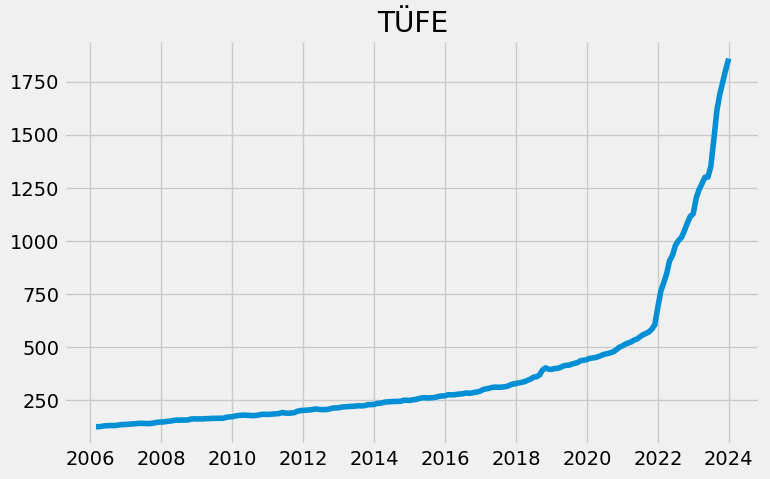

In [5]:
#enflasyon grafiğinin çizimi

dates=pd.date_range(start="2006-02-28",periods=len(enf) , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("TÜFE")
plt.plot(df)
plt.show()


In [6]:
# USD/TRY'yi float'a çeviri ve df6'ya tanımlama. 
df6=pd.DataFrame()
df6["USD/TRY"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TRY"]=df6["USD/TRY"].astype(float)
df6

,USD/TRY
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082


In [7]:
# M3 Para Arzı verisi

money=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del money["Tarih"]
money=pd.DataFrame(money)
money.columns=["M3 Para Arzi"]
money=money/1e+08
money=money.set_index(pd.date_range('2006-02-28',periods=len(money), freq='1M'))
money

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-09-30,126.661059
2023-10-31,130.934676
2023-11-30,134.161244
2023-12-31,140.183543


In [8]:
#İşsizlik verisi

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",periods=len(issizlik),freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-07-31,9.3
2023-08-31,9.1
2023-09-30,9.0
2023-10-31,8.5


In [9]:
#Toplam Kredi Hacmi

kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
dates=pd.date_range('2006-02-01',periods=len(kredi) , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi Hacmi"]
kredi["Kredi Hacmi"]=kredi["Kredi Hacmi"]/1e+08

df3=pd.DataFrame()
df3["Kredi Hacmi"]=kredi["Kredi Hacmi"]
df3["TIME"]=pd.date_range(start="2006-02-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28',periods=len(df3) , freq='1M'))
df3

,Kredi Hacmi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-09-30,102.582870
2023-10-31,104.793503
2023-11-30,107.866144
2023-12-31,111.894756


In [10]:
#TCMB Ağırlıklı Ortalama Fonlama Maliyeti (Politika Faizi)
#2011 yılına kadar veri gelmediği için aşağıda verilerin bir bölümü manuel girilmiştir.

pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
211,2023-9,31.00
212,2023-10,33.00
213,2023-11,41.09
214,2023-12,42.50


In [11]:
#Index ataması yapıldı.

dates=pd.date_range('2006-02-28',periods=len(pfaiz) , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-09-30,31.00
2023-10-31,33.00
2023-11-30,41.09


In [12]:
# Tüketici Kredisi (TL Üzerinden Acılan)(İhtiyaç+Taşıt+Konut) (Akım Veri) -- Kredi Faizi

kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del kfaiz["Tarih"]
del kfaiz["YEARWEEK"]
kfaiz=kfaiz.set_index(pd.date_range(start="2006-02-01",periods=len(kfaiz),freq="1W"))
kfaiz=kfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])
kfaiz.columns=["Kredi Faizi"]
kfaiz

,Kredi Faizi
2006-02-28,17.02
2006-03-31,16.88
2006-04-30,15.84
2006-05-31,16.60
2006-06-30,20.35
...,...
2023-09-30,57.56
2023-10-31,58.43
2023-11-30,58.61
2023-12-31,58.16


In [45]:
motorin=pd.read_excel("./motorin.xlsx")
motorin1=motorin.iloc[0:,1:].astype(float)
motorin1=pd.DataFrame(motorin1)
motorin1.columns=["motorin"]
motorin1=motorin.set_index(pd.date_range(start="2014-01-01",periods=len(motorin1),freq="1M"))
del motorin1["Tarih"]
motorin1

,Motorin
2014-01-31,4.66
2014-02-28,4.77
2014-03-31,4.73
2014-04-30,4.35
2014-05-31,4.34
...,...
2023-09-30,37.87
2023-10-31,40.11
2023-11-30,38.00
2023-12-31,37.59


In [48]:
# 3 Aya Kadar Vadeli (TL Üzerinden Açılan Mevduatlar) (Akım %)
# Bankalarca Açılan Mevduatlara Uygulanan Ağırlıklı Ortalama Faiz Oranları (Akım %)

mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="03-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
#mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2024-01-01",freq="1M"))
del mfaiz["YEARWEEK"]
del mfaiz["Tarih"]
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-03",periods=len(mfaiz),freq="W"))
mfaiz=mfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])

mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.70
2006-03-31,14.84
2006-04-30,14.87
2006-05-31,14.84
2006-06-30,15.57
...,...
2023-09-30,42.74
2023-10-31,41.72
2023-11-30,46.07
2023-12-31,52.50


In [51]:
# Piyasa Katılımcıları Anketi - 12 Ay Sonrasının Yıllık TÜFE Beklentisi (%)- Standart Sapma

from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",periods=len(enf_belirsizlik),freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-08-31,6.81
2023-09-30,7.30
2023-10-31,5.57
2023-11-30,4.49


#### Verileri birleştirme ve düzenleme yapıyoruz.

In [54]:
# verilerimizi tek tabloda topluyoruz.
# pct_change -> Yüzdesel değişim (percentage change)

data=pd.DataFrame()
data["USD/TRY"]=df6["USD/TRY"]
#data["USD/TRY"]=df6["USD/TRY"]
data["M3 Para Arzi"]=money["M3 Para Arzi"]
data["Motorin"]=motorin1["Motorin"]
data["Kredi Hacmi"]=df3["Kredi Hacmi"]
#data["Kredi Hacmi"]=df3["Kredi Hacmi"]
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.dropna(axis=0)

# buraya kadar olan verilerimizi yüzdesel değişim olarak değiştirdik. Sonraki verileri direkt gireceğiz.
# aşağıdaki veriler yüzdesel olduğu için yukarıdaki değişimi uygulamadık.

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
data=data.dropna(axis=0)
data=data[['USD/TRY','Motorin','Kredi Faizi','Enflasyon Belirsizliği','M3 Para Arzi','Kredi Hacmi','Mevduat Faizi','İşsizlik','Politika Faizi','TÜFE']]
data


,USD/TRY,Motorin,Kredi Faizi,Enflasyon Belirsizliği,M3 Para Arzi,Kredi Hacmi,Mevduat Faizi,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,
2014-02-28,-0.184635,2.360515,15.54,0.73,0.229599,0.117933,10.75,9.5,10.23,0.428192
2014-03-31,0.227393,-0.838574,16.05,0.80,0.730196,0.565506,11.65,9.5,10.27,1.125608
2014-04-30,-4.072871,-8.033827,15.65,0.73,-0.093468,-0.303714,10.75,9.7,10.03,1.344970
2014-05-31,-1.723376,-0.229885,15.36,0.80,-1.027834,1.243522,10.43,9.7,9.53,0.395224
2014-06-30,1.192281,0.921659,14.33,0.72,2.717431,2.478370,9.92,9.7,8.82,0.310791
...,...,...,...,...,...,...,...,...,...,...
2023-07-31,14.560243,23.450413,44.58,7.70,5.968276,2.951410,29.32,9.3,17.50,9.488824
2023-08-31,1.997667,52.343096,45.29,6.81,4.845313,0.781062,30.76,9.1,23.50,9.086793
2023-09-30,-0.035852,4.009887,57.56,7.30,2.614384,3.370496,42.74,9.0,31.00,4.753114


In [55]:
features=['USD/TRY','Motorin','Kredi Faizi','Enflasyon Belirsizliği','M3 Para Arzi','Kredi Hacmi','Mevduat Faizi','İşsizlik','Politika Faizi','TÜFE']
train=data[features].iloc[:-3,:]
test=data[features].iloc[-3:,:]



In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [57]:
# train test boyutlarını belirliyoruz.

test_period = 3 
test_size = test_period  

train_data = data[:-test_size]
test_data = data[-test_size:]

# Bağımsız değişkenleri ve TÜFE'yi ayırdık.

X_train = train.drop(['TÜFE'], axis=1).values
y_train = train['TÜFE'].values
X_test = test.drop(['TÜFE'], axis=1).values
y_test = test['TÜFE'].values



##### Korelasyon kontrolü

In [58]:
cor_matrix=data.corr()
cor_matrix["TÜFE"].sort_values(ascending=False)

TÜFE                      1.000000
Motorin                   0.643830
Enflasyon Belirsizliği    0.627335
Kredi Faizi               0.507711
USD/TRY                   0.490943
Mevduat Faizi             0.418636
M3 Para Arzi              0.309880
Kredi Hacmi               0.238513
Politika Faizi            0.230953
İşsizlik                 -0.200973
Name: TÜFE, dtype: float64

<Axes: >

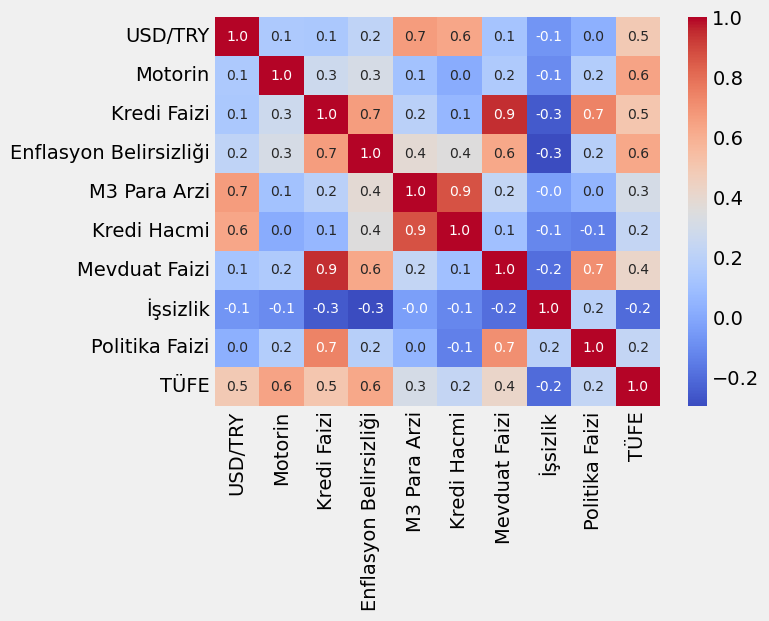

In [59]:
# Korelasyon matrisini hesaplayalım
korelasyon_matrisi = data.corr()

# Seaborn kütüphanesi ile ısı haritası (heatmap) grafiğini çizelim
sns.heatmap(korelasyon_matrisi, annot=True, cmap='coolwarm', linewidths=0, fmt=".1f",annot_kws={"size": 10})

LSTM için model hazırlıklarını yapıyoruz.

In [60]:
# LSTM için Kütüphaneleri import ediyoruz.

import tensorflow as tf
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import keras

# Rastgele sayı üreticisini ayarlıyoruz.
keras.utils.set_random_seed(1)

#Verileri normalize ediyoruz. (MinMaxScaler kullanıldı)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

#Modeli oluşturuyoruz.LSTM tabanlı bir derin öğrenme modeli tanımlar.
#Modelde bir LSTM katmanı ve ardından gelen üç tam bağlı katman (dense layer) bulunmaktadır.
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(X_train_scaled.shape[1],1)))
model.add(tf.keras.layers.Dense(64,activation='selu'))
model.add(tf.keras.layers.Dense(64,activation='elu'))
model.add(tf.keras.layers.Dense(1))

#Model derlenmesi. Kayıp fonksiyonu olarak ortalama karesel hata kullanıldı.
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rms, loss='mean_squared_error')

# Overfitting olmaması için erken durdurma parametresini belirliyoruz. Eğer kayıp fonksiyonunda 25 kere ardarda ilerleme
# olmazsa model duracak. (epoch >= 50)
early_stopping = EarlyStopping(patience=50, restore_best_weights=True)

#Modeli eğitiyoruz.
model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])




Epoch 1/500

4/4 [==============================] - 2s 107ms/step - loss: 6.5290 - val_loss: 0.4245
Epoch 2/500
4/4 [==============================] - 0s 16ms/step - loss: 0.1784 - val_loss: 0.0125
Epoch 3/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0281 - val_loss: 0.0061
Epoch 4/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0254 - val_loss: 0.0053
Epoch 5/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0240 - val_loss: 0.0051
Epoch 6/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0252 - val_loss: 0.0082
Epoch 7/500
4/4 [==============================] - 0s 28ms/step - loss: 0.0240 - val_loss: 0.0122
Epoch 8/500
4/4 [==============================] - 0s 27ms/step - loss: 0.0226 - val_loss: 0.0073
Epoch 9/500
4/4 [==============================] - 0s 25ms/step - loss: 0.0210 - val_loss: 0.0056
Epoch 10/500
4/4 [==============================] - 0s 25ms/step - loss: 0.0282 - val_loss: 0.1222
Epoch 11/500
4/4

4/4 [==============================] - 0s 16ms/step - loss: 0.0128 - val_loss: 0.0925
Epoch 80/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0163 - val_loss: 0.1108
Epoch 81/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0134 - val_loss: 0.0039
Epoch 82/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0083 - val_loss: 0.0041
Epoch 83/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0067 - val_loss: 0.0273
Epoch 84/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0094 - val_loss: 0.1482
Epoch 85/500
4/4 [==============================] - 0s 15ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 86/500
4/4 [==============================] - 0s 14ms/step - loss: 0.0075 - val_loss: 0.0390
Epoch 87/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0078 - val_loss: 0.0121


### Modeldeki hiperparametre seçimi için Grid Search (Izgara Taraması) yapıyoruz.

In [62]:

# Burada ise modeldeki hiperparametrelerin optimizasyonu için Grid Search (Izgara taraması) yapacağız.

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import ParameterGrid


# Model fonksiyonunu tanımlayın
def create_model(neurons=128, activation='relu', optimizer='adam', epochs=100):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(patience=25, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])
    return model


# Grid Search için hiperparametre kombinasyonlarını tanımlıyoruz.
param_grid = {
    'neurons': [64, 128],
    'activation': ['relu', 'tanh','selu','sigmoid','elu','gelu','linear'],
    'optimizer': ['adam', 'rmsprop','Adadelta','Adagrad','Adamax','Nadam','Ftrl'],
    'epochs': [500]
}
#Root Mean Squared Error -> ortalama Karekök sapması
#Grid Search algoritması çalıştırılmış ve en iyi hiperparametre seti ve buna karşılık gelen en küçük RMSE atanacak.

best_rmse = float('inf')
best_params = None

#Grid Search algoritması çalıştırılacak ve en iyi hiperparametre seti ve buna karşılık gelen en küçük RMSE atanacak.
for params in ParameterGrid(param_grid):
    model = create_model(neurons=params['neurons'], activation=params['activation'], optimizer=params['optimizer'], epochs=params['epochs'])
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test_scaled, y_pred)
    rmse = np.sqrt(mse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

#En iyi RMSE ve parametreleri yazdırıyoruz.
print("En iyi RMSE:", best_rmse)
print("En iyi parametreler:", best_params)



1/1 [==============================] - 0s 204ms/step
En iyi RMSE: 0.0324554764196491
En iyi parametreler: {'activation': 'selu', 'epochs': 500, 'neurons': 64, 'optimizer': 'Adadelta'}


In [63]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Modelinizi eğittikten sonra tahminlerimizi yapıyoruz.
y_pred = model.predict(X_test_scaled)

# Tahminleri gerçek değerlerle karşılaştırarak MSE hesaplıyoruz.
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)

print(f"Validation MSE: {mse}")
print(f"Validation RMSE: {rmse}")


1/1 [==============================] - 0s 21ms/step
Validation MSE: 0.0711828751575902
Validation RMSE: 0.26680119032266364


In [64]:
y_pred_original_scale = scaler.inverse_transform(y_pred)

# Tahmin edilen değerleri inceleyin
np.sqrt(mean_squared_error(y_test,y_pred_original_scale))

4.006929601086012

### Features seçimi yapıyoruz.

In [65]:
X=data[features]
y=data[["TÜFE"]]
scalerX = StandardScaler().fit(X)
scalery = StandardScaler().fit(y)
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
X_train = pd.DataFrame(scalerX.transform(X_train),index=X.index[:-3],columns=X.columns)
y_train = pd.DataFrame(scalery.transform(y_train),index=y.index[:-3],columns=y.columns)
X_test = pd.DataFrame(scalerX.transform(X_test),index=X.index[-3:],columns=X.columns)
y_test = pd.DataFrame(scalery.transform(y_test),y.index[-3:],columns=y.columns)

In [69]:

from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
features=['USD/TRY','Motorin','Kredi Faizi','Enflasyon Belirsizliği','M3 Para Arzi','Kredi Hacmi',
          'Mevduat Faizi','İşsizlik','Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
best_mse=float("inf")
best_features=[]
for r in range(3,11):
   for combo in combinations(features, 7):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        model = sm.RLM(y_train, X_train_subset, M=sm.robust.norms.HuberT()).fit()
        y_pred=model.predict(X_test_subset)
        rmse1=np.sqrt(mean_squared_error(y_test,y_pred))
        

        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features
            

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi RMSE değeri:", best_mse)


En iyi özellik kombinasyonu:
['Motorin', 'Kredi Faizi', 'Enflasyon Belirsizliği', 'Kredi Hacmi', 'Mevduat Faizi', 'İşsizlik', 'Politika Faizi']
En iyi RMSE değeri: 0.5897035445558189


### Features seçiminde olmasa da eklediğimiz değerler olacak. (Verilerin anlamlı olacağını düşünerek.)

### Farklı modeller ile tahminlerimizi yapıyoruz.

In [70]:
#en iyi öznitelik kombinasyonuna bazı öznitelikleri de ekleyerek lineer regresyon tahminliyoruz.

features = ['USD/TRY','Motorin', 'Kredi Faizi', 'Enflasyon Belirsizliği',
            'Kredi Hacmi', 'Mevduat Faizi', 'İşsizlik', 'Politika Faizi']
X = data[features]
y=data[["TÜFE"]]
X_train, X_test, y_train, y_test = X.iloc[:-3, :], X.iloc[-3:, :], y.iloc[:-3, :], y.iloc[-3:, :]
model = LinearRegression().fit(X_train, y_train)
pred = model.predict(X_test)
rmse=[]
rmse.append(np.sqrt(mean_squared_error(y_test, pred)))
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=pred

pred

array([[2.2869996 ],
       [2.80183354],
       [0.64399171]])

In [74]:
features = ['USD/TRY','Motorin', 'Kredi Faizi', 'Enflasyon Belirsizliği',
            'Kredi Hacmi', 'Mevduat Faizi', 'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
model = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT())
results = model.fit()
pred=results.predict(X_test)
tahminler["Robust Regression"]=pred
rmse.append(np.sqrt(mean_squared_error(y_test,pred)))

In [75]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['USD/TRY','Motorin', 'Kredi Faizi', 'Enflasyon Belirsizliği',
            'Kredi Hacmi', 'Mevduat Faizi', 'İşsizlik', 'Politika Faizi']
X = data[features]
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [76]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TRY','Motorin', 'Kredi Faizi', 'Enflasyon Belirsizliği',
            'Kredi Hacmi', 'Mevduat Faizi', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [77]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TRY','Motorin', 'Kredi Faizi', 'Enflasyon Belirsizliği',
            'Kredi Hacmi', 'Mevduat Faizi', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [78]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TRY','Motorin', 'Kredi Faizi', 'Enflasyon Belirsizliği',
            'Kredi Hacmi', 'Mevduat Faizi', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [79]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USD/TRY','Motorin', 'Kredi Faizi', 'Enflasyon Belirsizliği',
            'Kredi Hacmi', 'Mevduat Faizi', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train)

tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [80]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USD/TRY','Motorin', 'Kredi Faizi', 'Enflasyon Belirsizliği',
            'Kredi Hacmi', 'Mevduat Faizi', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [81]:
tahminler["LSTM"]=y_pred_original_scale
rmse.append(np.sqrt(mean_squared_error(y_test,y_pred_original_scale)))

In [83]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[0:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Linear Regression,1.342705
Robust Regression,1.342705
Bayesian Regression,1.537783
Lasso Regression,1.603397
SGD Regressor,1.612837
Gaussian Regression,2.095766
Kernel Regression,2.100923
Aylık Enflasyon,2.116259
Lars Regression,2.299347
LSTM,4.006930


In [84]:
tahminler.index.strftime("%Y-%m")

Index(['2023-09', '2023-10', '2023-11'], dtype='object', name='Tarih')

In [85]:
tahminler=tahminler.set_index(pd.date_range(start="2023-09",periods=3,freq="M"))
tahminler.index=tahminler.index.strftime("%Y-%m")

<Axes: >

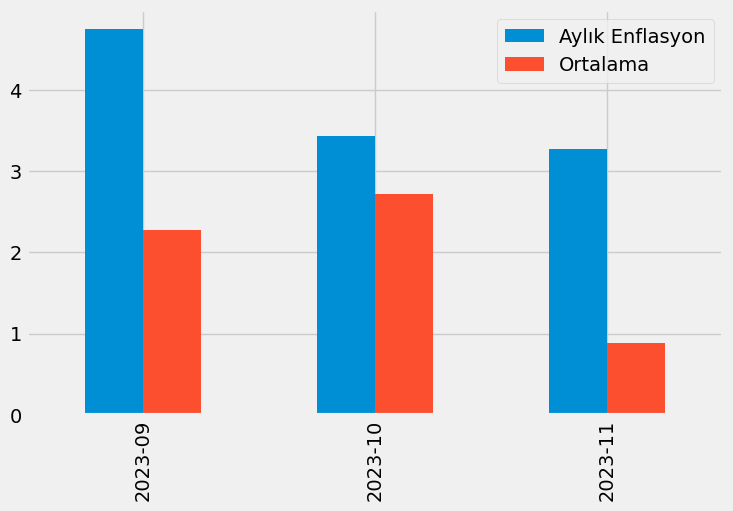

In [86]:
tahminler["Ortalama"]=tahminler.iloc[:,1:].mean(axis=1)
tahminler[["Aylık Enflasyon","Ortalama"]].plot(kind="bar",figsize=(8,5))

### Bağımsız değişkenlerimizin tahminlerini yapıyoruz. (exog prediction)

In [87]:
# Politika faizi için tahmin değil beklentilere yönelik manuel veri girişi yapıldı.

model=auto_arima(pfaiz["Politika Faizi"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(28)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:,0]},index=pd.date_range(start="2023-11-30",end="2024-02-28",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin.iloc[4:,0]=[42.5,45,45,45,45,45,45,45,45,45,42.5,40,40,40,40,40,40,40,40,40,40,37.5,35,35,35,35,35]
faiztahmin

,Politika Faizi
2023-11-30,41.090000
2023-12-31,42.500000
2024-01-31,42.500000
2024-02-29,43.667857
2024-03-31,42.500000
2024-04-30,45.000000
2024-05-31,45.000000
2024-06-30,45.000000
2024-07-31,45.000000
2024-08-31,45.000000


In [88]:
#arima ile kredi faizinin gelecek verisini tahminliyoruz.

model=auto_arima(kfaiz["Kredi Faizi"],seasonal=True,m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"])

forecast = model_fit.predict(26)
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:,0]},index=pd.date_range(start="2024-01-31",end="2024-01-31",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2024-01-31,62.080000
2024-02-29,62.487036
2024-03-31,63.739910
2024-04-30,63.140805
2024-05-31,63.980462
2024-06-30,63.245752
2024-07-31,64.009176
2024-08-31,63.268563
2024-09-30,64.006409
2024-10-31,63.278946


In [89]:
trainexog=kfaiz[47:-1]
trainexog

,Kredi Faizi
2010-01-31,13.76
2010-02-28,13.36
2010-03-31,13.10
2010-04-30,13.18
2010-05-31,13.25
...,...
2023-08-31,45.29
2023-09-30,57.56
2023-10-31,58.43
2023-11-30,58.61


In [90]:
testexog=kfaiztahmin[4:]
testexog

,Kredi Faizi
2024-05-31,63.980462
2024-06-30,63.245752
2024-07-31,64.009176
2024-08-31,63.268563
2024-09-30,64.006409
2024-10-31,63.278946
2024-11-30,63.999098
2024-12-31,63.287318
2025-01-31,63.991261
2025-02-28,63.295238


In [91]:
faiztahmin[5:]

,Politika Faizi
2024-04-30,45.0
2024-05-31,45.0
2024-06-30,45.0
2024-07-31,45.0
2024-08-31,45.0
2024-09-30,45.0
2024-10-31,45.0
2024-11-30,45.0
2024-12-31,45.0
2025-01-31,42.5


In [92]:
model=auto_arima(mfaiz["Mevduat Faizi"],X=pfaiz[:],trace=False,seasonal=False,information_criterion="aic")
mfaiztahmin=pd.DataFrame(model.predict(26,X=faiztahmin[5:]))
mfaiztahmin.columns=["Mevduat Faizi"]
row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[-2:,0]},index=pd.date_range(start="2024-01-31",end="2024-01-31",freq="1M"))
mfaiztahmin=pd.concat([row,mfaiztahmin],axis=0)
mfaiztahmin



,Mevduat Faizi
2024-01-31,51.290000
2024-02-29,50.758418
2024-03-31,52.269808
2024-04-30,52.226070
2024-05-31,51.606011
2024-06-30,51.962263
2024-07-31,52.032439
2024-08-31,51.842460
2024-09-30,51.916006
2024-10-31,51.956895


In [98]:
exog=pd.DataFrame()
exog["X"]=motorin1["Motorin"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2014-01-31,4.66
2014-02-28,4.77
2014-03-31,4.73
2014-04-30,4.35
2014-05-31,4.34
...,...
2023-09-30,37.87
2023-10-31,40.11
2023-11-30,38.00
2023-12-31,37.59


In [99]:
faiztahmin.columns=["Faiz"]

In [100]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [101]:
exog=pfaiz["Politika Faizi"].iloc[94:-3]
exog=np.array(exog).reshape(-1,1)

In [102]:
exogtest=faiztahmin.iloc[3:]
exogtest=np.array(exogtest).reshape(-1,1)

In [103]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(28,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2023-12-31,8.786814
2024-01-31,8.756800
2024-02-29,8.901400
2024-03-31,8.952587
2024-04-30,8.965938
2024-05-31,9.061040
2024-06-30,9.105634
2024-07-31,9.136871
2024-08-31,9.192203
2024-09-30,9.230379


In [104]:
from prophet import Prophet
df6.shape

(216, 1)

### Tahminlerimiz için hiperparametre seçimlerini yapıyoruz.

In [105]:
# her bir tahmin için bu şekilde parametre belirleyeceğiz.
"""
import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,500)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df6.index
    sn["y"]=df6.values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=14,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-14])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)


[I 2024-01-18 10:10:52,968] A new study created in memory with name: no-name-dc402c19-5963-49aa-bfaf-93c987448342
10:10:57 - cmdstanpy - INFO - Chain [1] start processing
10:10:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:10:59,359] Trial 0 finished with value: 2.791867127266347 and parameters: {'changepoint_prior_scale': 1.7569829223871498, 'changepoint_range': 0.5256737999419688, 'growth': 'logistic', 'seasonality_prior_scale': 2.6724688135156, 'n_changepoints': 25, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 29.01747735951876}. Best is trial 0 with value: 2.791867127266347.
10:10:59 - cmdstanpy - INFO - Chain [1] start processing
10:10:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:10:59,891] Trial 1 finished with value: 1.0913969559543877 and parameters: {'changepoint_prior_scale': 1.705002098843875, 'changepoint_range': 0.486323248181506, 'growth': 'logistic', 'seasonality_prior_scale': 9.879139837806392, 'n_changepoint

[I 2024-01-18 10:11:11,486] Trial 15 finished with value: 0.537613800165653 and parameters: {'changepoint_prior_scale': 9.539397424698496, 'changepoint_range': 0.7331438398745094, 'growth': 'logistic', 'seasonality_prior_scale': 6.642694618138147, 'n_changepoints': 17, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'cap': 324.0474320720728}. Best is trial 14 with value: 0.26529125926427494.
10:11:11 - cmdstanpy - INFO - Chain [1] start processing
10:11:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:11:12,122] Trial 16 finished with value: 0.3096389277732779 and parameters: {'changepoint_prior_scale': 7.92983150877182, 'changepoint_range': 0.9836158615773253, 'growth': 'logistic', 'seasonality_prior_scale': 7.024360754164768, 'n_changepoints': 16, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'cap': 330.8422974824394}. Best is trial 14 with value: 0.26529125926427494.
10:11:12 - cmdstanpy - INFO - Chain [1] start processing
10:11:12 - cmdsta

10:11:21 - cmdstanpy - INFO - Chain [1] start processing
10:11:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:11:22,277] Trial 31 finished with value: 0.31279305222441245 and parameters: {'changepoint_prior_scale': 6.053577398419641, 'changepoint_range': 0.9226041610306936, 'growth': 'logistic', 'seasonality_prior_scale': 4.640085455484345, 'n_changepoints': 11, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 331.59413473891107}. Best is trial 14 with value: 0.26529125926427494.
10:11:22 - cmdstanpy - INFO - Chain [1] start processing
10:11:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:11:22,981] Trial 32 finished with value: 0.37265180189262326 and parameters: {'changepoint_prior_scale': 8.51178755774633, 'changepoint_range': 0.7987335388616961, 'growth': 'logistic', 'seasonality_prior_scale': 7.054699210908232, 'n_changepoints': 14, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 279.60646965895955}. Best is tria

10:11:32 - cmdstanpy - INFO - Chain [1] start processing
10:11:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:11:33,105] Trial 47 finished with value: 0.29122055961042786 and parameters: {'changepoint_prior_scale': 2.7981397156798353, 'changepoint_range': 0.9491407667166077, 'growth': 'logistic', 'seasonality_prior_scale': 7.468181990905197, 'n_changepoints': 16, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 196.96082140667284}. Best is trial 45 with value: 0.22200239309076686.
10:11:33 - cmdstanpy - INFO - Chain [1] start processing
10:11:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:11:33,711] Trial 48 finished with value: 1.3936683959375347 and parameters: {'changepoint_prior_scale': 2.903731845903562, 'changepoint_range': 0.7674235532483085, 'growth': 'linear', 'seasonality_prior_scale': 8.15518053899575, 'n_changepoints': 17, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 197.9134167338775}. Best is tria

10:11:46 - cmdstanpy - INFO - Chain [1] start processing
10:11:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:11:46,722] Trial 63 finished with value: 0.2665768920479121 and parameters: {'changepoint_prior_scale': 3.391401727221824, 'changepoint_range': 0.8965059860994301, 'growth': 'logistic', 'seasonality_prior_scale': 9.945675757529663, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 114.72806810497397}. Best is trial 45 with value: 0.22200239309076686.
10:11:46 - cmdstanpy - INFO - Chain [1] start processing
10:11:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:11:47,393] Trial 64 finished with value: 0.3386030377756135 and parameters: {'changepoint_prior_scale': 1.1168996665567705, 'changepoint_range': 0.8434974768401983, 'growth': 'logistic', 'seasonality_prior_scale': 9.928187936707834, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 118.80734588921942}. Best is t

10:11:58 - cmdstanpy - INFO - Chain [1] start processing
10:11:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:11:58,508] Trial 79 finished with value: 0.15891793452348857 and parameters: {'changepoint_prior_scale': 1.0348953383540476, 'changepoint_range': 0.9539900968855264, 'growth': 'linear', 'seasonality_prior_scale': 9.041661534239784, 'n_changepoints': 21, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 89.09147841383535}. Best is trial 79 with value: 0.15891793452348857.
10:11:58 - cmdstanpy - INFO - Chain [1] start processing
10:11:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:11:58,982] Trial 80 finished with value: 0.32455371974933733 and parameters: {'changepoint_prior_scale': 0.6542961435246992, 'changepoint_range': 0.9390281682261274, 'growth': 'linear', 'seasonality_prior_scale': 9.036175593735104, 'n_changepoints': 21, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 1.6771401020835555}. Best is tri

10:12:05 - cmdstanpy - INFO - Chain [1] start processing
10:12:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:06,201] Trial 95 finished with value: 0.14475374994596132 and parameters: {'changepoint_prior_scale': 0.8878218362404253, 'changepoint_range': 0.9504177353964969, 'growth': 'linear', 'seasonality_prior_scale': 9.37681588814408, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 26.894743803533686}. Best is trial 95 with value: 0.14475374994596132.
10:12:06 - cmdstanpy - INFO - Chain [1] start processing
10:12:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:06,648] Trial 96 finished with value: 0.17246139476665173 and parameters: {'changepoint_prior_scale': 0.8963288964273609, 'changepoint_range': 0.947762569828751, 'growth': 'linear', 'seasonality_prior_scale': 9.479786848164782, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 23.931759141347243}. Best is tria

10:12:13 - cmdstanpy - INFO - Chain [1] start processing
10:12:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:13,434] Trial 111 finished with value: 0.146938470874125 and parameters: {'changepoint_prior_scale': 1.4854559260102445, 'changepoint_range': 0.9579706932382126, 'growth': 'linear', 'seasonality_prior_scale': 7.514314133580196, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 42.534191809058825}. Best is trial 102 with value: 0.13340719350105235.
10:12:13 - cmdstanpy - INFO - Chain [1] start processing
10:12:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:14,021] Trial 112 finished with value: 0.14618785666309006 and parameters: {'changepoint_prior_scale': 2.0695076497024507, 'changepoint_range': 0.956532653795727, 'growth': 'linear', 'seasonality_prior_scale': 7.511706947975499, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 69.01439291244776}. Best is tri

10:12:22 - cmdstanpy - INFO - Chain [1] start processing
10:12:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:22,526] Trial 127 finished with value: 0.36140928743573625 and parameters: {'changepoint_prior_scale': 0.9407372017610869, 'changepoint_range': 0.9173050554723302, 'growth': 'linear', 'seasonality_prior_scale': 7.503875897196769, 'n_changepoints': 23, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 30.112532997797185}. Best is trial 114 with value: 0.13291492499445215.
10:12:22 - cmdstanpy - INFO - Chain [1] start processing
10:12:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:23,101] Trial 128 finished with value: 0.15065241893925496 and parameters: {'changepoint_prior_scale': 5.4155238499344245, 'changepoint_range': 0.9509047942666092, 'growth': 'linear', 'seasonality_prior_scale': 6.624120230301797, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 18.631291259893477}. Best is

10:12:30 - cmdstanpy - INFO - Chain [1] start processing
10:12:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:30,972] Trial 143 finished with value: 0.16695374901251053 and parameters: {'changepoint_prior_scale': 4.73086791890499, 'changepoint_range': 0.9485064859719459, 'growth': 'linear', 'seasonality_prior_scale': 7.745446632739078, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 39.24342091610461}. Best is trial 114 with value: 0.13291492499445215.
10:12:31 - cmdstanpy - INFO - Chain [1] start processing
10:12:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:32,489] Trial 144 finished with value: 0.20156979722047647 and parameters: {'changepoint_prior_scale': 5.976595090702061, 'changepoint_range': 0.9403569316131164, 'growth': 'linear', 'seasonality_prior_scale': 7.611630671293927, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 60.05303442242984}. Best is tria

10:12:40 - cmdstanpy - INFO - Chain [1] start processing
10:12:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:41,443] Trial 159 finished with value: 0.18413216761081821 and parameters: {'changepoint_prior_scale': 4.762932611488032, 'changepoint_range': 0.9453440158668506, 'growth': 'linear', 'seasonality_prior_scale': 7.641475114026756, 'n_changepoints': 23, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 63.788569926007014}. Best is trial 114 with value: 0.13291492499445215.
10:12:41 - cmdstanpy - INFO - Chain [1] start processing
10:12:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:41,852] Trial 160 finished with value: 0.3555631547200547 and parameters: {'changepoint_prior_scale': 1.6914011425977338, 'changepoint_range': 0.9193491337273849, 'growth': 'linear', 'seasonality_prior_scale': 8.586215844562531, 'n_changepoints': 22, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 129.08353073300705}. Best is t

10:12:49 - cmdstanpy - INFO - Chain [1] start processing
10:12:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:50,213] Trial 175 finished with value: 0.2081027188781023 and parameters: {'changepoint_prior_scale': 2.056136070158593, 'changepoint_range': 0.9423692477047068, 'growth': 'linear', 'seasonality_prior_scale': 8.469721902664704, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 50.85402363604484}. Best is trial 164 with value: 0.13278545544011627.
10:12:50 - cmdstanpy - INFO - Chain [1] start processing
10:12:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:50,627] Trial 176 finished with value: 0.17013421087480582 and parameters: {'changepoint_prior_scale': 2.231543214365566, 'changepoint_range': 0.9870174003039147, 'growth': 'linear', 'seasonality_prior_scale': 8.172528498700764, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 16.587203664148504}. Best is tri

10:12:59 - cmdstanpy - INFO - Chain [1] start processing
10:12:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:59,343] Trial 191 finished with value: 0.1852254761139749 and parameters: {'changepoint_prior_scale': 2.260772840324164, 'changepoint_range': 0.9483021921153554, 'growth': 'linear', 'seasonality_prior_scale': 7.534181441027615, 'n_changepoints': 23, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 55.45081199086694}. Best is trial 164 with value: 0.13278545544011627.
10:12:59 - cmdstanpy - INFO - Chain [1] start processing
10:12:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:12:59,780] Trial 192 finished with value: 0.13293345236206008 and parameters: {'changepoint_prior_scale': 2.0408712022505857, 'changepoint_range': 0.9557403424319163, 'growth': 'linear', 'seasonality_prior_scale': 7.91035738479189, 'n_changepoints': 23, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 29.67664320274671}. Best is tria

10:13:06 - cmdstanpy - INFO - Chain [1] start processing
10:13:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:07,081] Trial 207 finished with value: 0.34444320526243816 and parameters: {'changepoint_prior_scale': 2.8286333028154553, 'changepoint_range': 0.9059566856147665, 'growth': 'linear', 'seasonality_prior_scale': 8.131525340259437, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 28.24447545217575}. Best is trial 194 with value: 0.1322565325786163.
10:13:07 - cmdstanpy - INFO - Chain [1] start processing
10:13:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:07,480] Trial 208 finished with value: 0.2644967889469334 and parameters: {'changepoint_prior_scale': 4.635509796377269, 'changepoint_range': 0.9360863532036784, 'growth': 'linear', 'seasonality_prior_scale': 7.726671770954839, 'n_changepoints': 23, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 10.342546492688992}. Best is tri

10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:15,641] Trial 223 finished with value: 0.13644769951304042 and parameters: {'changepoint_prior_scale': 3.8474490702821487, 'changepoint_range': 0.987581745499086, 'growth': 'linear', 'seasonality_prior_scale': 7.60352714609551, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 11.923074266949653}. Best is trial 194 with value: 0.1322565325786163.
10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:16,163] Trial 224 finished with value: 0.1369831402219494 and parameters: {'changepoint_prior_scale': 3.1979236420750974, 'changepoint_range': 0.9885238305214897, 'growth': 'linear', 'seasonality_prior_scale': 7.630422587011943, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 14.503309510479466}. Best is tri

10:13:24 - cmdstanpy - INFO - Chain [1] start processing
10:13:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:25,135] Trial 239 finished with value: 0.136465144429718 and parameters: {'changepoint_prior_scale': 3.482331693874253, 'changepoint_range': 0.9899067774753425, 'growth': 'linear', 'seasonality_prior_scale': 6.412321884978814, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'cap': 17.304395708423982}. Best is trial 194 with value: 0.1322565325786163.
10:13:25 - cmdstanpy - INFO - Chain [1] start processing
10:13:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:25,576] Trial 240 finished with value: 0.2369815310227008 and parameters: {'changepoint_prior_scale': 3.3023882309882717, 'changepoint_range': 0.9710432044722714, 'growth': 'linear', 'seasonality_prior_scale': 6.973286154724543, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'cap': 21.833505795142855}. Best is tr

10:13:33 - cmdstanpy - INFO - Chain [1] start processing
10:13:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:33,977] Trial 255 finished with value: 0.24148301330502756 and parameters: {'changepoint_prior_scale': 3.2535623614552653, 'changepoint_range': 0.9396460126291762, 'growth': 'linear', 'seasonality_prior_scale': 7.217197099114419, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'cap': 31.89049015578282}. Best is trial 194 with value: 0.1322565325786163.
10:13:34 - cmdstanpy - INFO - Chain [1] start processing
10:13:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:34,432] Trial 256 finished with value: 0.21001806024291625 and parameters: {'changepoint_prior_scale': 3.678322863710166, 'changepoint_range': 0.9662049878990616, 'growth': 'linear', 'seasonality_prior_scale': 6.429943537857267, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'cap': 22.38195340068734}. Best is t

10:13:43 - cmdstanpy - INFO - Chain [1] start processing
10:13:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:43,421] Trial 271 finished with value: 0.25319918653632845 and parameters: {'changepoint_prior_scale': 3.7428514119195566, 'changepoint_range': 0.9693218563886955, 'growth': 'linear', 'seasonality_prior_scale': 6.913119728576653, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'cap': 28.727256452851094}. Best is trial 194 with value: 0.1322565325786163.
10:13:43 - cmdstanpy - INFO - Chain [1] start processing
10:13:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:43,839] Trial 272 finished with value: 0.3129914387224599 and parameters: {'changepoint_prior_scale': 3.327099185544036, 'changepoint_range': 0.9287713450713706, 'growth': 'linear', 'seasonality_prior_scale': 7.410133322172884, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 10.641909891519138}. Best is t

10:13:50 - cmdstanpy - INFO - Chain [1] start processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:51,211] Trial 287 finished with value: 0.2108317327726597 and parameters: {'changepoint_prior_scale': 2.439507693242776, 'changepoint_range': 0.9659862955872097, 'growth': 'linear', 'seasonality_prior_scale': 7.227315219612568, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'cap': 32.60111339434258}. Best is trial 194 with value: 0.1322565325786163.
10:13:51 - cmdstanpy - INFO - Chain [1] start processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:51,649] Trial 288 finished with value: 11.030494800956149 and parameters: {'changepoint_prior_scale': 7.842054821042845, 'changepoint_range': 0.30026089968964, 'growth': 'linear', 'seasonality_prior_scale': 7.481203059117445, 'n_changepoints': 22, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 9.044687609374767}. Best is trial 1

10:13:58 - cmdstanpy - INFO - Chain [1] start processing
10:13:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:58,712] Trial 303 finished with value: 0.24613903094588754 and parameters: {'changepoint_prior_scale': 2.348326431565364, 'changepoint_range': 0.973149246234275, 'growth': 'linear', 'seasonality_prior_scale': 6.972959740841216, 'n_changepoints': 25, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 47.795575970025084}. Best is trial 194 with value: 0.1322565325786163.
10:13:58 - cmdstanpy - INFO - Chain [1] start processing
10:13:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:13:59,176] Trial 304 finished with value: 0.2845794942002373 and parameters: {'changepoint_prior_scale': 3.117685932449266, 'changepoint_range': 0.9367966333297592, 'growth': 'linear', 'seasonality_prior_scale': 8.218680305661636, 'n_changepoints': 22, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'cap': 39.5855698865998}. Best is trial

10:14:07 - cmdstanpy - INFO - Chain [1] start processing
10:14:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:14:07,261] Trial 319 finished with value: 0.3642953878449371 and parameters: {'changepoint_prior_scale': 3.96359998269428, 'changepoint_range': 0.9235392079604546, 'growth': 'linear', 'seasonality_prior_scale': 7.59376551413333, 'n_changepoints': 21, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 41.54516394731608}. Best is trial 194 with value: 0.1322565325786163.
10:14:07 - cmdstanpy - INFO - Chain [1] start processing
10:14:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:14:07,710] Trial 320 finished with value: 0.13302999522878767 and parameters: {'changepoint_prior_scale': 1.9006029440587051, 'changepoint_range': 0.9562136392632767, 'growth': 'linear', 'seasonality_prior_scale': 7.113707501814571, 'n_changepoints': 23, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 30.69079339161309}. Best is trial 

10:14:14 - cmdstanpy - INFO - Chain [1] start processing
10:14:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:14:14,885] Trial 335 finished with value: 0.35423792961743783 and parameters: {'changepoint_prior_scale': 2.6652780501050386, 'changepoint_range': 0.8892683101105526, 'growth': 'linear', 'seasonality_prior_scale': 6.459279727613018, 'n_changepoints': 23, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 280.4275453460286}. Best is trial 194 with value: 0.1322565325786163.
10:14:15 - cmdstanpy - INFO - Chain [1] start processing
10:14:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:14:15,313] Trial 336 finished with value: 0.19212626034616773 and parameters: {'changepoint_prior_scale': 4.1008812277827476, 'changepoint_range': 0.9462957768352763, 'growth': 'linear', 'seasonality_prior_scale': 5.154002120612802, 'n_changepoints': 22, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 288.18434687991083}. Best is t

10:14:25 - cmdstanpy - INFO - Chain [1] start processing
10:14:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:14:25,902] Trial 351 finished with value: 0.19307413751479602 and parameters: {'changepoint_prior_scale': 2.4397453560016955, 'changepoint_range': 0.9461904204168822, 'growth': 'linear', 'seasonality_prior_scale': 7.991150439847441, 'n_changepoints': 22, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 353.5553898846664}. Best is trial 194 with value: 0.1322565325786163.
10:14:26 - cmdstanpy - INFO - Chain [1] start processing
10:14:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:14:26,347] Trial 352 finished with value: 0.25490931240400194 and parameters: {'changepoint_prior_scale': 2.2753324547368643, 'changepoint_range': 0.9715994580080209, 'growth': 'linear', 'seasonality_prior_scale': 0.11560733661503304, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 254.67071466403752}. Best is

10:14:36 - cmdstanpy - INFO - Chain [1] start processing
10:14:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:14:36,649] Trial 367 finished with value: 0.14655152840824345 and parameters: {'changepoint_prior_scale': 1.7266333855506129, 'changepoint_range': 0.95801945803567, 'growth': 'linear', 'seasonality_prior_scale': 7.413013227404264, 'n_changepoints': 24, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 43.071550506967085}. Best is trial 194 with value: 0.1322565325786163.
10:14:36 - cmdstanpy - INFO - Chain [1] start processing
10:14:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:14:37,120] Trial 368 finished with value: 0.34447258963818705 and parameters: {'changepoint_prior_scale': 6.303210990066841, 'changepoint_range': 0.9163970550845165, 'growth': 'linear', 'seasonality_prior_scale': 0.7636040266540045, 'n_changepoints': 23, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 272.3606725204084}. Best is tri

10:14:46 - cmdstanpy - INFO - Chain [1] start processing
10:14:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:14:46,819] Trial 383 finished with value: 0.13285493643352447 and parameters: {'changepoint_prior_scale': 2.120188131097862, 'changepoint_range': 0.9582405861721051, 'growth': 'linear', 'seasonality_prior_scale': 1.523974142322107, 'n_changepoints': 23, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 38.30951427919853}. Best is trial 194 with value: 0.1322565325786163.
10:14:46 - cmdstanpy - INFO - Chain [1] start processing
10:14:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:14:47,273] Trial 384 finished with value: 0.34662005553335384 and parameters: {'changepoint_prior_scale': 2.1061263792746128, 'changepoint_range': 0.9079744009652747, 'growth': 'linear', 'seasonality_prior_scale': 2.2244484492156165, 'n_changepoints': 23, 'yearly_seasonality': False, 'weekly_seasonality': False, 'cap': 41.161544329091704}. Best is t

10:14:58 - cmdstanpy - INFO - Chain [1] start processing
10:14:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:14:58,918] Trial 399 finished with value: 0.12010167498942838 and parameters: {'changepoint_prior_scale': 2.358556948051904, 'changepoint_range': 0.9539743731367732, 'growth': 'linear', 'seasonality_prior_scale': 1.4470409741948336, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 81.17452302353}. Best is trial 386 with value: 0.11995868251442292.
10:14:59 - cmdstanpy - INFO - Chain [1] start processing
10:14:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:14:59,410] Trial 400 finished with value: 0.3400173988274007 and parameters: {'changepoint_prior_scale': 2.3873583490227652, 'changepoint_range': 0.9174055356361029, 'growth': 'linear', 'seasonality_prior_scale': 0.9703836236193819, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 95.8589043679423}. Best is trial 3

10:15:12 - cmdstanpy - INFO - Chain [1] start processing
10:15:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:15:12,736] Trial 415 finished with value: 1.7461893511711197 and parameters: {'changepoint_prior_scale': 2.1085338865828938, 'changepoint_range': 0.3263430163597556, 'growth': 'logistic', 'seasonality_prior_scale': 0.9455574505750651, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 55.260835207874095}. Best is trial 386 with value: 0.11995868251442292.
10:15:12 - cmdstanpy - INFO - Chain [1] start processing
10:15:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:15:14,215] Trial 416 finished with value: 0.31654244735677406 and parameters: {'changepoint_prior_scale': 2.743381664246842, 'changepoint_range': 0.9052038814353772, 'growth': 'linear', 'seasonality_prior_scale': 0.44885114420510996, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 49.34741951800885}. Best is 

10:15:22 - cmdstanpy - INFO - Chain [1] start processing
10:15:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:15:23,224] Trial 431 finished with value: 0.24765135336925753 and parameters: {'changepoint_prior_scale': 2.6435271888060616, 'changepoint_range': 0.9413683791468981, 'growth': 'linear', 'seasonality_prior_scale': 1.0043102768487373, 'n_changepoints': 21, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 123.81832621915831}. Best is trial 423 with value: 0.11983829206606444.
10:15:23 - cmdstanpy - INFO - Chain [1] start processing
10:15:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:15:23,795] Trial 432 finished with value: 0.17904121822591915 and parameters: {'changepoint_prior_scale': 2.5634216912697885, 'changepoint_range': 0.9634534124104669, 'growth': 'linear', 'seasonality_prior_scale': 1.2661973888508973, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 109.31353098194411}. Best is

10:15:35 - cmdstanpy - INFO - Chain [1] start processing
10:15:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:15:37,666] Trial 447 finished with value: 0.22230140991728942 and parameters: {'changepoint_prior_scale': 3.0248219508962046, 'changepoint_range': 0.9438945408477125, 'growth': 'linear', 'seasonality_prior_scale': 0.30675318227881243, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 108.48452813774506}. Best is trial 423 with value: 0.11983829206606444.
10:15:37 - cmdstanpy - INFO - Chain [1] start processing
10:15:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:15:38,142] Trial 448 finished with value: 0.3284705607999797 and parameters: {'changepoint_prior_scale': 2.7696652089467055, 'changepoint_range': 0.9099751711561774, 'growth': 'linear', 'seasonality_prior_scale': 1.1506808156448327, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 71.68276218164328}. Best is 

10:15:47 - cmdstanpy - INFO - Chain [1] start processing
10:15:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:15:48,668] Trial 463 finished with value: 0.33968430781358 and parameters: {'changepoint_prior_scale': 2.669355446446618, 'changepoint_range': 0.8901080303546114, 'growth': 'linear', 'seasonality_prior_scale': 0.732018154529532, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 285.4209528344684}. Best is trial 423 with value: 0.11983829206606444.
10:15:48 - cmdstanpy - INFO - Chain [1] start processing
10:15:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:15:49,168] Trial 464 finished with value: 0.1327302708776036 and parameters: {'changepoint_prior_scale': 2.963707811521722, 'changepoint_range': 0.9572365607884185, 'growth': 'linear', 'seasonality_prior_scale': 0.9385478166122263, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 294.68027136466}. Best is trial 423 

10:15:58 - cmdstanpy - INFO - Chain [1] start processing
10:15:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:15:59,029] Trial 479 finished with value: 0.280994613637692 and parameters: {'changepoint_prior_scale': 3.1316952011181924, 'changepoint_range': 0.972734334428763, 'growth': 'linear', 'seasonality_prior_scale': 0.6871190308072028, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 264.1997677180613}. Best is trial 423 with value: 0.11983829206606444.
10:15:59 - cmdstanpy - INFO - Chain [1] start processing
10:15:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:15:59,489] Trial 480 finished with value: 0.32376155013617924 and parameters: {'changepoint_prior_scale': 9.201712315945713, 'changepoint_range': 0.9056864919735305, 'growth': 'linear', 'seasonality_prior_scale': 0.9690711581821163, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 402.5746385196552}. Best is trial 

10:16:08 - cmdstanpy - INFO - Chain [1] start processing
10:16:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:16:08,618] Trial 495 finished with value: 0.2896071721360654 and parameters: {'changepoint_prior_scale': 4.955216118924354, 'changepoint_range': 0.9742621940311906, 'growth': 'linear', 'seasonality_prior_scale': 5.001943096042066, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 321.71570308265}. Best is trial 423 with value: 0.11983829206606444.
10:16:08 - cmdstanpy - INFO - Chain [1] start processing
10:16:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:16:09,137] Trial 496 finished with value: 0.29536364789556185 and parameters: {'changepoint_prior_scale': 2.4232330428249265, 'changepoint_range': 0.9333220881825932, 'growth': 'linear', 'seasonality_prior_scale': 0.5126960914607486, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 317.74818662657583}. Best is trial

10:16:19 - cmdstanpy - INFO - Chain [1] start processing
10:16:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:16:19,420] Trial 511 finished with value: 4.651449748303849 and parameters: {'changepoint_prior_scale': 3.3577828024206307, 'changepoint_range': 0.6052567746865649, 'growth': 'linear', 'seasonality_prior_scale': 1.1459368302997848, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 340.901559926116}. Best is trial 510 with value: 0.11981503966803196.
10:16:19 - cmdstanpy - INFO - Chain [1] start processing
10:16:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:16:20,914] Trial 512 finished with value: 0.26976900922095204 and parameters: {'changepoint_prior_scale': 2.9135780756070293, 'changepoint_range': 0.9384913095832305, 'growth': 'linear', 'seasonality_prior_scale': 8.881849832171884, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 349.633763575569}. Best is trial 

10:16:29 - cmdstanpy - INFO - Chain [1] start processing
10:16:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:16:30,377] Trial 527 finished with value: 0.24484628740660253 and parameters: {'changepoint_prior_scale': 2.5478790144086996, 'changepoint_range': 0.9394990835480237, 'growth': 'linear', 'seasonality_prior_scale': 0.8854872945046828, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 405.2261510087065}. Best is trial 520 with value: 0.11454631344015682.
10:16:30 - cmdstanpy - INFO - Chain [1] start processing
10:16:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:16:30,946] Trial 528 finished with value: 0.25743245818992433 and parameters: {'changepoint_prior_scale': 2.672315829174188, 'changepoint_range': 0.9732726788183189, 'growth': 'linear', 'seasonality_prior_scale': 3.7442946542167377, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 201.1273634174142}. Best is tri

10:16:41 - cmdstanpy - INFO - Chain [1] start processing
10:16:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:16:41,970] Trial 543 finished with value: 6.028136921507649 and parameters: {'changepoint_prior_scale': 2.4569980519375063, 'changepoint_range': 0.5373813261386914, 'growth': 'linear', 'seasonality_prior_scale': 1.2194104443067493, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 470.590673897142}. Best is trial 520 with value: 0.11454631344015682.
10:16:42 - cmdstanpy - INFO - Chain [1] start processing
10:16:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:16:42,528] Trial 544 finished with value: 0.33373886869753305 and parameters: {'changepoint_prior_scale': 2.214772325336038, 'changepoint_range': 0.9215941585013377, 'growth': 'linear', 'seasonality_prior_scale': 4.5273224434914425, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 493.41798121093325}. Best is trial 

10:16:52 - cmdstanpy - INFO - Chain [1] start processing
10:16:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:16:52,467] Trial 559 finished with value: 0.12823993414985516 and parameters: {'changepoint_prior_scale': 2.69433397165691, 'changepoint_range': 0.9535924620140829, 'growth': 'linear', 'seasonality_prior_scale': 0.9813884262845373, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 484.72304205080223}. Best is trial 520 with value: 0.11454631344015682.
10:16:52 - cmdstanpy - INFO - Chain [1] start processing
10:16:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:16:53,025] Trial 560 finished with value: 0.32594872239209494 and parameters: {'changepoint_prior_scale': 2.64828343037666, 'changepoint_range': 0.9240589491107829, 'growth': 'linear', 'seasonality_prior_scale': 1.0046917888963247, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 469.4259876854602}. Best is trial 

10:17:03 - cmdstanpy - INFO - Chain [1] start processing
10:17:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:17:03,552] Trial 575 finished with value: 0.21402960832797574 and parameters: {'changepoint_prior_scale': 3.071052274006269, 'changepoint_range': 0.9385227070364851, 'growth': 'logistic', 'seasonality_prior_scale': 0.4875014499533978, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 449.98192870124535}. Best is trial 573 with value: 0.11434059369059156.
10:17:03 - cmdstanpy - INFO - Chain [1] start processing
10:17:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:17:04,150] Trial 576 finished with value: 0.1295282775723503 and parameters: {'changepoint_prior_scale': 2.9330962952531383, 'changepoint_range': 0.9600086172362695, 'growth': 'linear', 'seasonality_prior_scale': 0.6187281025055025, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 426.75636661438654}. Best is t

10:17:13 - cmdstanpy - INFO - Chain [1] start processing
10:17:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:17:13,782] Trial 591 finished with value: 0.2336915323031592 and parameters: {'changepoint_prior_scale': 3.086149371197311, 'changepoint_range': 0.9892559921802774, 'growth': 'linear', 'seasonality_prior_scale': 1.6408691872227732, 'n_changepoints': 22, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 458.3363850131798}. Best is trial 573 with value: 0.11434059369059156.
10:17:13 - cmdstanpy - INFO - Chain [1] start processing
10:17:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:17:14,301] Trial 592 finished with value: 0.12180887477803255 and parameters: {'changepoint_prior_scale': 2.550339275875859, 'changepoint_range': 0.9575103616388124, 'growth': 'linear', 'seasonality_prior_scale': 0.9924392010054528, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 437.94285611215594}. Best is tri

10:17:24 - cmdstanpy - INFO - Chain [1] start processing
10:17:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:17:24,679] Trial 607 finished with value: 0.13726115122539412 and parameters: {'changepoint_prior_scale': 3.2805776443001897, 'changepoint_range': 0.9565101476262421, 'growth': 'linear', 'seasonality_prior_scale': 1.4752614390151357, 'n_changepoints': 21, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 401.70231502306564}. Best is trial 573 with value: 0.11434059369059156.
10:17:24 - cmdstanpy - INFO - Chain [1] start processing
10:17:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:17:26,640] Trial 608 finished with value: 0.2636666151760752 and parameters: {'changepoint_prior_scale': 2.707657033467186, 'changepoint_range': 0.9358607826374049, 'growth': 'linear', 'seasonality_prior_scale': 1.2521969529188968, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 432.7498212255054}. Best is tria

10:17:34 - cmdstanpy - INFO - Chain [1] start processing
10:17:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:17:34,955] Trial 623 finished with value: 0.3347313049303634 and parameters: {'changepoint_prior_scale': 2.76385772206027, 'changepoint_range': 0.9229622239565503, 'growth': 'linear', 'seasonality_prior_scale': 2.348649045622982, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 470.16009067784057}. Best is trial 573 with value: 0.11434059369059156.
10:17:35 - cmdstanpy - INFO - Chain [1] start processing
10:17:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:17:35,483] Trial 624 finished with value: 0.31375956106452074 and parameters: {'changepoint_prior_scale': 2.404147502518459, 'changepoint_range': 0.9602031200420146, 'growth': 'linear', 'seasonality_prior_scale': 1.6069767251165306, 'n_changepoints': 13, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 472.7426537899527}. Best is trial 5

10:17:43 - cmdstanpy - INFO - Chain [1] start processing
10:17:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:17:44,085] Trial 639 finished with value: 3.776477204473685 and parameters: {'changepoint_prior_scale': 2.415767343307181, 'changepoint_range': 0.6453996206996172, 'growth': 'linear', 'seasonality_prior_scale': 5.369190521164657, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 499.6368403106194}. Best is trial 573 with value: 0.11434059369059156.
10:17:44 - cmdstanpy - INFO - Chain [1] start processing
10:17:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:17:44,608] Trial 640 finished with value: 0.26550363369721414 and parameters: {'changepoint_prior_scale': 2.0353704843366733, 'changepoint_range': 0.9354925523226763, 'growth': 'linear', 'seasonality_prior_scale': 1.3592871749143662, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 415.5873275910911}. Best is trial 5

10:17:53 - cmdstanpy - INFO - Chain [1] start processing
10:17:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:17:54,268] Trial 655 finished with value: 0.13717410869118726 and parameters: {'changepoint_prior_scale': 3.2987765921293413, 'changepoint_range': 0.9565411193387552, 'growth': 'linear', 'seasonality_prior_scale': 1.7521143969195996, 'n_changepoints': 21, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 415.0364120316632}. Best is trial 573 with value: 0.11434059369059156.
10:17:54 - cmdstanpy - INFO - Chain [1] start processing
10:17:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:17:54,833] Trial 656 finished with value: 0.2825378869313417 and parameters: {'changepoint_prior_scale': 3.066822552287412, 'changepoint_range': 0.938824935397109, 'growth': 'linear', 'seasonality_prior_scale': 2.76190722903189, 'n_changepoints': 21, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 432.6726780844578}. Best is tria

10:18:02 - cmdstanpy - INFO - Chain [1] start processing
10:18:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:18:03,313] Trial 671 finished with value: 0.1692944887696838 and parameters: {'changepoint_prior_scale': 2.883249778677725, 'changepoint_range': 0.9894467309280724, 'growth': 'logistic', 'seasonality_prior_scale': 3.4668824630789525, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 457.65724957214746}. Best is trial 573 with value: 0.11434059369059156.
10:18:03 - cmdstanpy - INFO - Chain [1] start processing
10:18:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:18:03,873] Trial 672 finished with value: 0.31276723620796687 and parameters: {'changepoint_prior_scale': 2.3355131993327487, 'changepoint_range': 0.9311803114417171, 'growth': 'linear', 'seasonality_prior_scale': 1.4047605253820539, 'n_changepoints': 21, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 449.41892447346686}. Best is

10:18:12 - cmdstanpy - INFO - Chain [1] start processing
10:18:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:18:12,758] Trial 687 finished with value: 0.12175538979252769 and parameters: {'changepoint_prior_scale': 2.555048425293464, 'changepoint_range': 0.9564261050407951, 'growth': 'linear', 'seasonality_prior_scale': 3.132646992398125, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 105.06619384021413}. Best is trial 573 with value: 0.11434059369059156.
10:18:13 - cmdstanpy - INFO - Chain [1] start processing
10:18:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:18:13,351] Trial 688 finished with value: 0.23721776568294925 and parameters: {'changepoint_prior_scale': 2.184266635401917, 'changepoint_range': 0.969657738107889, 'growth': 'linear', 'seasonality_prior_scale': 3.1970432031272673, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 112.78487118876808}. Best is trial

10:18:22 - cmdstanpy - INFO - Chain [1] start processing
10:18:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:18:22,549] Trial 703 finished with value: 0.32372565515167967 and parameters: {'changepoint_prior_scale': 2.9877725988970827, 'changepoint_range': 0.9748364462339982, 'growth': 'linear', 'seasonality_prior_scale': 2.511086874964502, 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 123.47766605181282}. Best is trial 573 with value: 0.11434059369059156.
10:18:22 - cmdstanpy - INFO - Chain [1] start processing
10:18:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:18:23,065] Trial 704 finished with value: 0.3180515823996948 and parameters: {'changepoint_prior_scale': 3.1552878184495405, 'changepoint_range': 0.9151027297896793, 'growth': 'linear', 'seasonality_prior_scale': 2.241834375242659, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 110.92630451629022}. Best is tria

10:18:31 - cmdstanpy - INFO - Chain [1] start processing
10:18:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:18:31,568] Trial 719 finished with value: 0.21157199743868488 and parameters: {'changepoint_prior_scale': 3.2393696749473415, 'changepoint_range': 0.9432093816481716, 'growth': 'linear', 'seasonality_prior_scale': 2.655501338440309, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 109.04685687027865}. Best is trial 573 with value: 0.11434059369059156.
10:18:31 - cmdstanpy - INFO - Chain [1] start processing
10:18:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:18:32,141] Trial 720 finished with value: 0.3444597505649717 and parameters: {'changepoint_prior_scale': 3.4805532682994063, 'changepoint_range': 0.8874898069631298, 'growth': 'linear', 'seasonality_prior_scale': 2.6630671537248505, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 102.59911102292179}. Best is tri

10:18:41 - cmdstanpy - INFO - Chain [1] start processing
10:18:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:18:42,205] Trial 735 finished with value: 0.3104091239452859 and parameters: {'changepoint_prior_scale': 3.01120688353216, 'changepoint_range': 0.928027873820669, 'growth': 'linear', 'seasonality_prior_scale': 2.547931161596351, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 128.6399366559492}. Best is trial 573 with value: 0.11434059369059156.
10:18:42 - cmdstanpy - INFO - Chain [1] start processing
10:18:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:18:42,767] Trial 736 finished with value: 0.16628247111873598 and parameters: {'changepoint_prior_scale': 2.7004406916316133, 'changepoint_range': 0.9470356172068389, 'growth': 'linear', 'seasonality_prior_scale': 2.3907287125860286, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 155.0300445524478}. Best is trial 

10:18:50 - cmdstanpy - INFO - Chain [1] start processing
10:18:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:18:51,109] Trial 751 finished with value: 10.327397244243562 and parameters: {'changepoint_prior_scale': 2.8434491228614416, 'changepoint_range': 0.33035842074514915, 'growth': 'linear', 'seasonality_prior_scale': 2.7497228474153896, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 124.5697405819501}. Best is trial 573 with value: 0.11434059369059156.
10:18:51 - cmdstanpy - INFO - Chain [1] start processing
10:18:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:18:51,659] Trial 752 finished with value: 0.12148633724788593 and parameters: {'changepoint_prior_scale': 3.2852740736273827, 'changepoint_range': 0.9556247459770708, 'growth': 'linear', 'seasonality_prior_scale': 2.077989642016778, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 85.28487097499132}. Best is tria

10:19:00 - cmdstanpy - INFO - Chain [1] start processing
10:19:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:01,072] Trial 767 finished with value: 0.1722200239266899 and parameters: {'changepoint_prior_scale': 2.898401255611643, 'changepoint_range': 0.9887973447763319, 'growth': 'logistic', 'seasonality_prior_scale': 2.736524881697505, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 120.34131501487755}. Best is trial 573 with value: 0.11434059369059156.
10:19:01 - cmdstanpy - INFO - Chain [1] start processing
10:19:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:01,614] Trial 768 finished with value: 0.2633744000982528 and parameters: {'changepoint_prior_scale': 3.334614101165497, 'changepoint_range': 0.9379234539789029, 'growth': 'linear', 'seasonality_prior_scale': 2.9670053617963674, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 100.29183477558027}. Best is tria

10:19:09 - cmdstanpy - INFO - Chain [1] start processing
10:19:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:09,880] Trial 783 finished with value: 9.173492349283734 and parameters: {'changepoint_prior_scale': 2.736669610690758, 'changepoint_range': 0.38797116959321754, 'growth': 'linear', 'seasonality_prior_scale': 0.6191345164397218, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 147.46295428828293}. Best is trial 573 with value: 0.11434059369059156.
10:19:10 - cmdstanpy - INFO - Chain [1] start processing
10:19:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:10,434] Trial 784 finished with value: 0.11434405179431319 and parameters: {'changepoint_prior_scale': 3.427245633110268, 'changepoint_range': 0.9577006010850577, 'growth': 'linear', 'seasonality_prior_scale': 2.090356973053736, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 104.10559406197383}. Best is tri

10:19:19 - cmdstanpy - INFO - Chain [1] start processing
10:19:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:20,039] Trial 799 finished with value: 0.27472333381801284 and parameters: {'changepoint_prior_scale': 3.2143936077586552, 'changepoint_range': 0.9331251500282309, 'growth': 'linear', 'seasonality_prior_scale': 3.0088516279081663, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 99.24063834684898}. Best is trial 573 with value: 0.11434059369059156.
10:19:20 - cmdstanpy - INFO - Chain [1] start processing
10:19:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:20,646] Trial 800 finished with value: 0.23624801104410195 and parameters: {'changepoint_prior_scale': 2.867040999278152, 'changepoint_range': 0.9707766248995123, 'growth': 'linear', 'seasonality_prior_scale': 1.6876520081947892, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 160.4919365753025}. Best is tria

10:19:29 - cmdstanpy - INFO - Chain [1] start processing
10:19:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:30,028] Trial 815 finished with value: 0.31825777479468303 and parameters: {'changepoint_prior_scale': 2.9062637526492026, 'changepoint_range': 0.9151826373907286, 'growth': 'linear', 'seasonality_prior_scale': 0.7798298534861826, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 122.7552127028392}. Best is trial 573 with value: 0.11434059369059156.
10:19:30 - cmdstanpy - INFO - Chain [1] start processing
10:19:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:30,565] Trial 816 finished with value: 0.327224620282452 and parameters: {'changepoint_prior_scale': 4.834317367911241, 'changepoint_range': 0.8785552446196587, 'growth': 'linear', 'seasonality_prior_scale': 1.3236359624185436, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 92.99305557183372}. Best is trial 

10:19:39 - cmdstanpy - INFO - Chain [1] start processing
10:19:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:40,146] Trial 831 finished with value: 0.3234754646470946 and parameters: {'changepoint_prior_scale': 2.8752980533883754, 'changepoint_range': 0.9012965682833226, 'growth': 'linear', 'seasonality_prior_scale': 2.6132440893073356, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 175.4612672409309}. Best is trial 573 with value: 0.11434059369059156.
10:19:40 - cmdstanpy - INFO - Chain [1] start processing
10:19:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:40,852] Trial 832 finished with value: 3.3245874311880232 and parameters: {'changepoint_prior_scale': 2.3325599688047927, 'changepoint_range': 0.6737867196092091, 'growth': 'linear', 'seasonality_prior_scale': 0.5485598926815675, 'n_changepoints': 21, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 100.8543410061103}. Best is trial

10:19:49 - cmdstanpy - INFO - Chain [1] start processing
10:19:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:50,126] Trial 847 finished with value: 0.1927767835800552 and parameters: {'changepoint_prior_scale': 2.1549674410020185, 'changepoint_range': 0.9713419950225121, 'growth': 'linear', 'seasonality_prior_scale': 1.2511717278806889, 'n_changepoints': 19, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 87.04840765624569}. Best is trial 573 with value: 0.11434059369059156.
10:19:50 - cmdstanpy - INFO - Chain [1] start processing
10:19:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:50,846] Trial 848 finished with value: 0.3010410481363041 and parameters: {'changepoint_prior_scale': 2.893384340081007, 'changepoint_range': 0.9342226700002306, 'growth': 'linear', 'seasonality_prior_scale': 2.6409082873385255, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 106.70900573873334}. Best is tri

10:19:59 - cmdstanpy - INFO - Chain [1] start processing
10:19:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:19:59,563] Trial 863 finished with value: 0.244827361019844 and parameters: {'changepoint_prior_scale': 3.0169763843918185, 'changepoint_range': 0.9389876408746146, 'growth': 'linear', 'seasonality_prior_scale': 1.6458548654256975, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 69.65954982127491}. Best is trial 573 with value: 0.11434059369059156.
10:19:59 - cmdstanpy - INFO - Chain [1] start processing
10:20:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:20:00,122] Trial 864 finished with value: 0.11453704672826984 and parameters: {'changepoint_prior_scale': 2.3786098333273005, 'changepoint_range': 0.953947035415483, 'growth': 'linear', 'seasonality_prior_scale': 1.269260270131782, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 100.06268913575376}. Best is tria

10:20:10 - cmdstanpy - INFO - Chain [1] start processing
10:20:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:20:10,397] Trial 879 finished with value: 0.33054947026518283 and parameters: {'changepoint_prior_scale': 2.4842332287004476, 'changepoint_range': 0.9156358079929174, 'growth': 'linear', 'seasonality_prior_scale': 1.1888130186377195, 'n_changepoints': 24, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 89.52931342378743}. Best is trial 573 with value: 0.11434059369059156.
10:20:10 - cmdstanpy - INFO - Chain [1] start processing
10:20:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:20:10,889] Trial 880 finished with value: 0.28754812918068784 and parameters: {'changepoint_prior_scale': 0.07495815449692156, 'changepoint_range': 0.9542242470228006, 'growth': 'linear', 'seasonality_prior_scale': 1.3063765141106263, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 96.1702714587187}. Best is t

10:20:19 - cmdstanpy - INFO - Chain [1] start processing
10:20:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:20:19,557] Trial 895 finished with value: 0.2633582270266499 and parameters: {'changepoint_prior_scale': 7.150826832255038, 'changepoint_range': 0.9743307742740542, 'growth': 'linear', 'seasonality_prior_scale': 9.7832957354854, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 249.362085174812}. Best is trial 573 with value: 0.11434059369059156.
10:20:19 - cmdstanpy - INFO - Chain [1] start processing
10:20:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:20:20,099] Trial 896 finished with value: 0.3274082054106771 and parameters: {'changepoint_prior_scale': 2.442099871199607, 'changepoint_range': 0.928776861191984, 'growth': 'linear', 'seasonality_prior_scale': 1.3628295336921157, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 108.22014544194067}. Best is trial 573

10:20:31 - cmdstanpy - INFO - Chain [1] start processing
10:20:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:20:31,293] Trial 911 finished with value: 11.890464170823837 and parameters: {'changepoint_prior_scale': 2.5512980890591597, 'changepoint_range': 0.2555395715816077, 'growth': 'linear', 'seasonality_prior_scale': 2.830963382901981, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 468.32941338899553}. Best is trial 573 with value: 0.11434059369059156.
10:20:31 - cmdstanpy - INFO - Chain [1] start processing
10:20:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:20:31,814] Trial 912 finished with value: 0.318743316544825 and parameters: {'changepoint_prior_scale': 3.0249483012279685, 'changepoint_range': 0.9572181934060338, 'growth': 'linear', 'seasonality_prior_scale': 0.7927375791682381, 'n_changepoints': 14, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 70.29870740467408}. Best is trial

10:20:42 - cmdstanpy - INFO - Chain [1] start processing
10:20:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:20:42,408] Trial 927 finished with value: 0.26482049624833737 and parameters: {'changepoint_prior_scale': 2.807564912864649, 'changepoint_range': 0.9738001500708207, 'growth': 'linear', 'seasonality_prior_scale': 0.7717081374987473, 'n_changepoints': 23, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 454.49102225754206}. Best is trial 573 with value: 0.11434059369059156.
10:20:42 - cmdstanpy - INFO - Chain [1] start processing
10:20:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:20:42,977] Trial 928 finished with value: 2.786646093303987 and parameters: {'changepoint_prior_scale': 2.2829573038085567, 'changepoint_range': 0.7070576059522998, 'growth': 'linear', 'seasonality_prior_scale': 1.5256209541163517, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 390.03213582996284}. Best is t

10:20:51 - cmdstanpy - INFO - Chain [1] start processing
10:20:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:20:52,220] Trial 943 finished with value: 0.19483697450831305 and parameters: {'changepoint_prior_scale': 4.50812086401533, 'changepoint_range': 0.9772389061656167, 'growth': 'linear', 'seasonality_prior_scale': 0.7537749205568597, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'cap': 489.1457426867087}. Best is trial 573 with value: 0.11434059369059156.
10:20:52 - cmdstanpy - INFO - Chain [1] start processing
10:20:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:20:52,819] Trial 944 finished with value: 0.12069816099084915 and parameters: {'changepoint_prior_scale': 4.289030155915466, 'changepoint_range': 0.9882724008936137, 'growth': 'linear', 'seasonality_prior_scale': 0.8574397910475082, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'cap': 484.3867337657013}. Best i

10:21:01 - cmdstanpy - INFO - Chain [1] start processing
10:21:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:21:01,499] Trial 959 finished with value: 0.16987552991811197 and parameters: {'changepoint_prior_scale': 4.907442734513517, 'changepoint_range': 0.9591505735645202, 'growth': 'linear', 'seasonality_prior_scale': 0.7457111169612236, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'cap': 480.0082377984467}. Best is trial 573 with value: 0.11434059369059156.
10:21:01 - cmdstanpy - INFO - Chain [1] start processing
10:21:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:21:02,074] Trial 960 finished with value: 0.22376978878056408 and parameters: {'changepoint_prior_scale': 4.485370130816402, 'changepoint_range': 0.9720723377749394, 'growth': 'linear', 'seasonality_prior_scale': 0.8810644814328845, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'cap': 499.64747666304254}. Best 

10:21:13 - cmdstanpy - INFO - Chain [1] start processing
10:21:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:21:13,479] Trial 975 finished with value: 0.20129941843377552 and parameters: {'changepoint_prior_scale': 3.896412512642201, 'changepoint_range': 0.9656359330173411, 'growth': 'linear', 'seasonality_prior_scale': 0.2567292632872278, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 499.7319678985156}. Best is trial 573 with value: 0.11434059369059156.
10:21:13 - cmdstanpy - INFO - Chain [1] start processing
10:21:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:21:14,214] Trial 976 finished with value: 0.21167221783408033 and parameters: {'changepoint_prior_scale': 4.128540791881675, 'changepoint_range': 0.9385461483891114, 'growth': 'logistic', 'seasonality_prior_scale': 0.9349082732110905, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 469.6097547634919}. Best is

10:21:22 - cmdstanpy - INFO - Chain [1] start processing
10:21:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:21:22,827] Trial 991 finished with value: 0.1221548485798569 and parameters: {'changepoint_prior_scale': 1.9535324174315645, 'changepoint_range': 0.9889926350514189, 'growth': 'linear', 'seasonality_prior_scale': 0.31838271936412943, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'cap': 165.03136728223797}. Best is trial 573 with value: 0.11434059369059156.
10:21:23 - cmdstanpy - INFO - Chain [1] start processing
10:21:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 10:21:23,417] Trial 992 finished with value: 0.1327183162162198 and parameters: {'changepoint_prior_scale': 2.674338965556865, 'changepoint_range': 0.9557756344113585, 'growth': 'linear', 'seasonality_prior_scale': 0.9512391159163496, 'n_changepoints': 24, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 365.780758124575}. Best is t

In [106]:
#study.best_params

{'changepoint_prior_scale': 2.8344829298784675,
 'changepoint_range': 0.9568801261300274,
 'growth': 'linear',
 'seasonality_prior_scale': 0.6204605804128791,
 'n_changepoints': 23,
 'yearly_seasonality': True,
 'weekly_seasonality': True,
 'cap': 450.5073178422175}

In [108]:
sn=pd.DataFrame()
sn["ds"]=df6.index
sn["y"]=df6.values
sn["cap"]=450.5073178422175
prophet=Prophet(growth="linear",changepoint_prior_scale=2.8344829298784675,changepoint_range=0.9568801261300274,seasonality_prior_scale=0.6204605804128791,n_changepoints=23,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
future_dates["cap"]=450.5073178422175
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])


11:17:57 - cmdstanpy - INFO - Chain [1] start processing
11:17:58 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
usdtahmin=(predictions["yhat"][-14:].pct_change(periods=1)*100).dropna()
usdtahmin

ds
2024-02-29    3.185173
2024-03-31    3.801896
2024-04-30    4.112217
2024-05-31    4.236885
2024-06-30    2.502448
2024-07-31    3.043284
2024-08-31    3.375549
2024-09-30    3.474166
2024-10-31    2.619349
2024-11-30    2.757286
2024-12-31    2.979872
2025-01-31    2.620876
2025-02-28    2.025002
Name: yhat, dtype: float64

In [110]:
usdtahmin1 = []
result = df6.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TRY"]
usdtahmin1=pd.concat([df6.iloc[-6:],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2023-08-30", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TRY
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.074857
2024-01-31,29.909954
2024-02-29,30.862637
2024-03-31,32.036003
2024-04-30,33.353393
2024-05-31,34.766538


In [123]:
#bURADA
"""
import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'm':trial.suggest_int('m',0,180),
                'cap':trial.suggest_int('cap',1,1000)
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=motorin1[params["m"]:-12].index
    sn["y"]=motorin1[params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(motorin1["Motorin"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=1000)

[I 2024-01-18 11:24:45,689] A new study created in memory with name: no-name-d6a6b806-d413-47bf-8423-f548d0fdde3d
11:24:45 - cmdstanpy - INFO - Chain [1] start processing
11:24:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 11:24:46,070] Trial 0 finished with value: 72.67523948052988 and parameters: {'changepoint_prior_scale': 0.17613550726029348, 'changepoint_range': 0.9846951469200731, 'growth': 'linear', 'm': 9, 'cap': 825}. Best is trial 0 with value: 72.67523948052988.
11:24:46 - cmdstanpy - INFO - Chain [1] start processing
11:24:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 11:24:48,010] Trial 1 finished with value: 126.61355988774686 and parameters: {'changepoint_prior_scale': 1.0717678811660252, 'changepoint_range': 0.5579067338999192, 'growth': 'linear', 'm': 64, 'cap': 5}. Best is trial 0 with value: 72.67523948052988.
11:24:48 - cmdstanpy - INFO - Chain [1] start processing
11:24:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01

ValueError: Dataframe has less than 2 non-NaN rows.

In [283]:
#study.best_params

{'changepoint_prior_scale': 8.356485446360438,
 'changepoint_range': 0.44854060721085903,
 'growth': 'linear',
 'm': 3,
 'cap': 17}

In [125]:
sn=pd.DataFrame()
sn["ds"]=motorin1[51:].index
sn["y"]=motorin1[51:].values
sn["cap"]=17
prophet=Prophet(growth="linear",changepoint_prior_scale=8.356485446360438,changepoint_range=0.44854060721085903)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
future_dates["cap"]=17
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

11:27:08 - cmdstanpy - INFO - Chain [1] start processing
11:27:09 - cmdstanpy - INFO - Chain [1] done processing


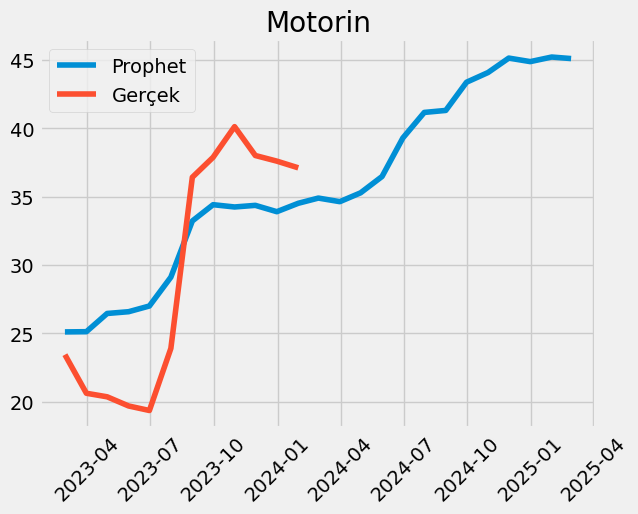

In [127]:
plt.title("Motorin")
plt.plot(predictions["yhat"][-25:],label="Prophet")
plt.plot(motorin1["Motorin"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [135]:
"""
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping

train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli optimize etmek için kullanılabilecek farklı parametre kombinasyonlarını deneme
layer_units = [64, 128]  # LSTM katmanındaki nöron sayısı
dense_units = [16,32,64,128]  # Yoğun katmandaki nöron sayısı
activations = ['relu', 'tanh','sigmoid','elu','selu']  # Aktivasyon fonksiyonları
learning_rates = [0.001, 0.01]  # Öğrenme hızı
optimizers = ['adam', 'sgd']  # Optimizer'lar

best_mse = float('inf')
best_model = None

for lstm_units in layer_units:
    for dense_unit in dense_units:
        for activation in activations:
            for learning_rate in learning_rates:
                for optimizer_name in optimizers:
                    try:
                        # Modeli oluşturma
                        model = Sequential()
                        model.add(LSTM(units=lstm_units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
                        model.add(Dense(units=dense_unit, activation=activation))
                        model.add(Dense(units=1))
                        
                        # Optimizer'ı ve learning rate'i ayarlama
                        if optimizer_name == 'adam':
                            optimizer = Adam(learning_rate=learning_rate)
                        elif optimizer_name == 'sgd':
                            optimizer = SGD(learning_rate=learning_rate)  # SGD için gerekirse import etmeyi unutmayın
                        
                        model.compile(optimizer=optimizer, loss='mean_squared_error')
                        
                        # Modeli eğitme ve early stopping uygulama
                        model.fit(X_train, y_train, epochs=250, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=1)
                        
                        # Modeli değerlendirme
                        y_pred = model.predict(X_test)
                        mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))
                        
                        # En iyi modeli güncelleme
                        if mse < best_mse:
                            best_mse = mse
                            best_model = model
                    except Exception as e:
                        print(f'Hata oluştu: {e}')

# En iyi modelin MSE değerini ve kullanılan optimizer'ı yazdırma
print(f'En İyi Modelin Ortalama Kare Hatası (MSE): {best_mse}')
if best_model is not None:
    print(f'En İyi Modelde Kullanılan Optimizer: {best_model.optimizer.get_config()["name"]}')    

Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu: tuple index out of range
Hata oluştu:

In [203]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(motorin1)

# LSTM için veriyi hazırlama
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # Örnek olarak 12 aylık bir dönemi kullanıyoruz
X, y = prepare_data(df_scaled, time_steps)
train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
keras.utils.set_random_seed(7)
model = Sequential()
model.add(LSTM(units=128, activation='elu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=128, activation='elu'))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/100
6/6 [==============================] - 2s 53ms/step - loss: 0.0050 - val_loss: 0.0982
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0772
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0248
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 9.3472e-04 - val_loss: 0.0261
Epoch 5/100
6/6 [==============================] - 0s 17ms/step - loss: 9.5769e-04 - val_loss: 0.0318
Epoch 6/100
6/6 [==============================] - 0s 15ms/step - loss: 7.0745e-04 - val_loss: 0.0232
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 6.7385e-04 - val_loss: 0.0203
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 6.2322e-04 - val_loss: 0.0224
Epoch 9/100
6/6 [==============================] - 0s 18ms/step - loss: 5.8634e-04 - val_loss: 0.0312
Epoch 10/100
6/6 [==============================] - 0s 17ms/step - loss: 5.5412e-04 - val_loss

1/1 [==============================] - 0s 192ms/step


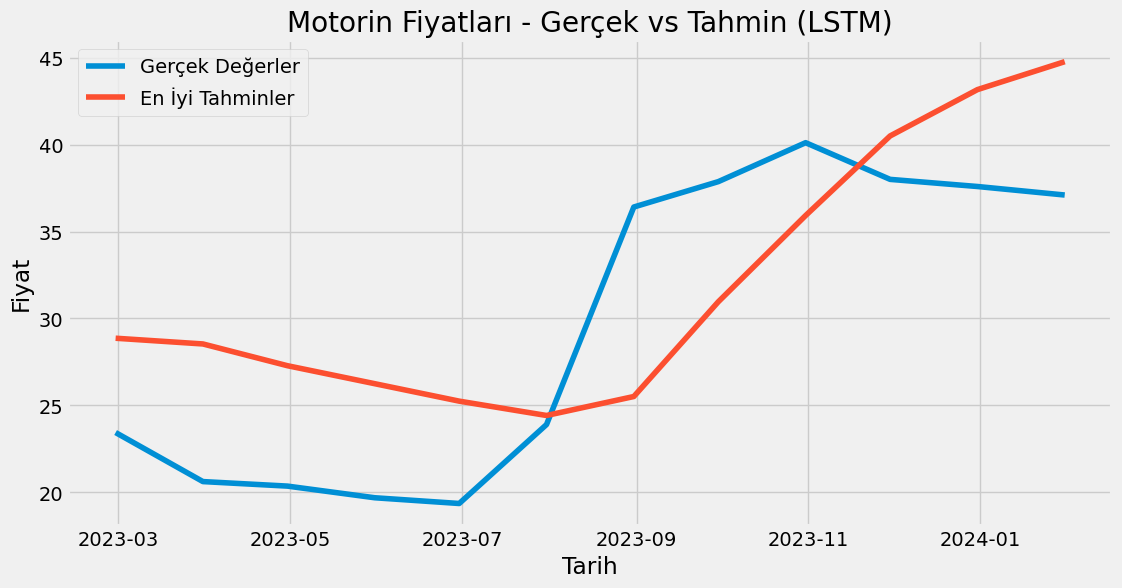

In [204]:
pred=scaler.inverse_transform(model.predict(X_test))
plt.figure(figsize=(12, 6))
plt.plot(motorin1.index[-len(y_test):], scaler.inverse_transform(y_test), label='Gerçek Değerler')
plt.plot(motorin1.index[-len(y_test):], pred, label='En İyi Tahminler')
plt.title('Motorin Fiyatları - Gerçek vs Tahmin (LSTM)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

In [206]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(motorin1)

# LSTM için veriyi hazırlama
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # Örnek olarak 12 aylık bir dönemi kullanıyoruz
X, y = prepare_data(df_scaled, time_steps)
train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [222]:
# generate the input and output sequences
n_lookback = 25  # length of input sequences (lookback period)
n_forecast = 25  # length of output sequences (forecast period)
X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)
keras.utils.set_random_seed(0)
# fit the model
model = Sequential()
model.add(LSTM(units=128, activation='selu', return_sequences=True, input_shape=(n_lookback, 1)))
model.add(Dense(units=128, activation='selu'))  # Dense katmanı eklendi
model.add(Dense(units=1))  # Çıkış birimi sayısını 1 olarak değiştirildi

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=500, batch_size=16, verbose=1)

# generate the forecasts
X_ = y[-n_lookback:]  # last available input sequence
#X_ = X_.reshape(1, n_lookback, 1)

# Tahmin yaparken çıkış şeklini düzenle
Y_ = model.predict(X_).reshape(1, n_forecast)

# Orijinal ölçekleme işlemi
Y_ = scaler.inverse_transform(Y_)

print(Y_)



Epoch 1/500
4/4 [==============================] - 2s 9ms/step - loss: 0.0360
Epoch 2/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0288
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0244
Epoch 4/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0183
Epoch 5/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0156
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 7/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0159
Epoch 8/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0125
Epoch 9/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0114
Epoch 10/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 11/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0105
Epoch 12/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0095
Epoch 13/500
4/4 [==============================] - 0s 10

4/4 [==============================] - 0s 9ms/step - loss: 0.0060
Epoch 105/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0058
Epoch 106/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 107/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0051
Epoch 108/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0044
Epoch 109/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 110/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0042
Epoch 111/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 112/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0038
Epoch 113/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0039
Epoch 114/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0036
Epoch 115/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 116/500
4/4 [==============================]

4/4 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 206/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0027
Epoch 207/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 208/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0026
Epoch 209/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 210/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 211/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 212/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0028
Epoch 213/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 214/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 215/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 216/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0040
Epoch 217/500
4/4 [============================

4/4 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 307/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 308/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 309/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 310/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 311/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 312/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 313/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 314/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 315/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 316/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 317/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 318/500
4/4 [==============================]

4/4 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 408/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0025
Epoch 409/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0021
Epoch 410/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 411/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0025
Epoch 412/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0033
Epoch 413/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0039
Epoch 414/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0038
Epoch 415/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0032
Epoch 416/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0030
Epoch 417/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0029
Epoch 418/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 419/500
4/4 [========================

In [223]:
Y_=np.array(Y_).reshape(-1,1)

In [224]:
future=pd.DataFrame()
future["Motorin"]=motorin1["Motorin"]
Y_=pd.DataFrame(Y_)
Y_.columns=["Motorin"]
Y_=Y_.set_index(pd.date_range(start="2024-02-29",periods=25,freq="M"))
future=pd.concat([future,Y_],axis=0)
future

,Motorin
2014-01-31,4.660000
2014-02-28,4.770000
2014-03-31,4.730000
2014-04-30,4.350000
2014-05-31,4.340000
...,...
2025-10-31,-2.329658
2025-11-30,-3.027451
2025-12-31,-2.370262
2026-01-31,-2.242168


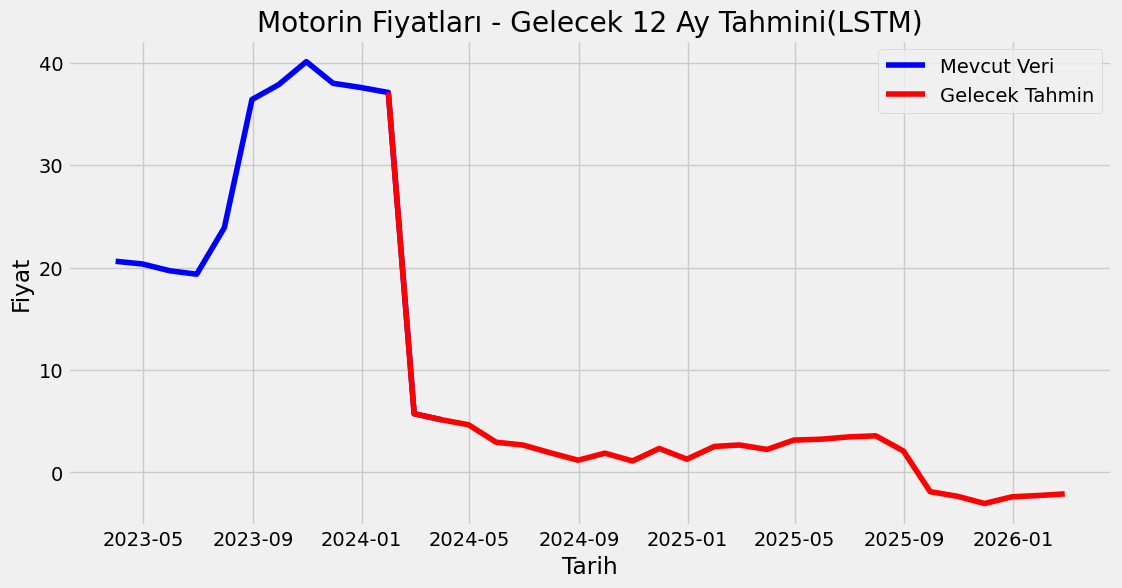

In [228]:
plt.figure(figsize=(12, 6))
#plt.plot(pred,label='Test Tahmini',color='green')
plt.plot(future["Motorin"][-36:-23], label='Mevcut Veri',color='blue')
plt.plot(future["Motorin"][-26:] ,label='Gelecek Tahmin',color='red')
plt.title('Motorin Fiyatları - Gelecek 12 Ay Tahmini(LSTM)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()


In [229]:
"""
import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.0001,0.9999),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400),
                'm':trial.suggest_int('m',0,105)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik[params["m"]:].index
    sn["y"]=enf_belirsizlik[params["m"]:].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)

[I 2024-01-18 12:06:07,373] A new study created in memory with name: no-name-b509efec-197b-4da5-90bc-ac28f388408f
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:06:09,330] Trial 0 finished with value: 4.084733274624983 and parameters: {'changepoint_prior_scale': 1.6640251616691126, 'changepoint_range': 0.02371729974741734, 'growth': 'linear', 'seasonality_prior_scale': 2.7601931570523113, 'n_changepoints': 25, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'cap': 190.86386779027862, 'm': 78}. Best is trial 0 with value: 4.084733274624983.
12:06:09 - cmdstanpy - INFO - Chain [1] start processing
12:06:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:06:09,930] Trial 1 finished with value: 0.18390311306110294 and parameters: {'changepoint_prior_scale': 9.411672598663333, 'changepoint_range': 0.8700630909060982, 'growth': 'linear', 'seasonality_prior_scale': 8.451223287102904, 

12:07:05 - cmdstanpy - INFO - Chain [1] start processing
12:07:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:07:05,647] Trial 16 finished with value: 0.2972554156368572 and parameters: {'changepoint_prior_scale': 3.350103966641224, 'changepoint_range': 0.6391924077007239, 'growth': 'linear', 'seasonality_prior_scale': 6.6535258270604185, 'n_changepoints': 37, 'yearly_seasonality': False, 'weekly_seasonality': True, 'cap': 107.74157069950101, 'm': 102}. Best is trial 14 with value: 9.467159033352965e-09.
12:07:05 - cmdstanpy - INFO - Chain [1] start processing
12:07:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:07:16,571] Trial 17 finished with value: 1.642908634436452e-09 and parameters: {'changepoint_prior_scale': 2.9240694339364928, 'changepoint_range': 0.8008948391283074, 'growth': 'linear', 'seasonality_prior_scale': 7.087528874499219, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 142.90420741392995, 'm

12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:09:44,388] Trial 32 finished with value: 5.867067098358199e-09 and parameters: {'changepoint_prior_scale': 5.771950260381903, 'changepoint_range': 0.832229289233891, 'growth': 'logistic', 'seasonality_prior_scale': 8.854829092250881, 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 219.70774752212753, 'm': 97}. Best is trial 17 with value: 1.642908634436452e-09.
12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:09:45,614] Trial 33 finished with value: 0.14683850468925178 and parameters: {'changepoint_prior_scale': 5.807558953705188, 'changepoint_range': 0.8358834849507779, 'growth': 'logistic', 'seasonality_prior_scale': 9.150654648346876, 'n_changepoints': 11, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 214.4646416539298, 'm

12:11:32 - cmdstanpy - INFO - Chain [1] start processing
12:11:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:11:51,639] Trial 48 finished with value: 4.266436893665566e-09 and parameters: {'changepoint_prior_scale': 4.157417656261502, 'changepoint_range': 0.9502033003355181, 'growth': 'linear', 'seasonality_prior_scale': 2.546095821476368, 'n_changepoints': 18, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 133.32698382116416, 'm': 94}. Best is trial 17 with value: 1.642908634436452e-09.
12:11:51 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:12:10,872] Trial 49 finished with value: 4.948042424290595e-10 and parameters: {'changepoint_prior_scale': 4.285389359916476, 'changepoint_range': 0.9424442828725438, 'growth': 'linear', 'seasonality_prior_scale': 1.9353760358843721, 'n_changepoints': 18, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 131.21527426378984, '

12:15:27 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:15:36,505] Trial 64 finished with value: 5.97102450132985e-09 and parameters: {'changepoint_prior_scale': 1.7959027554324418, 'changepoint_range': 0.8629759934930488, 'growth': 'linear', 'seasonality_prior_scale': 3.685912570903717, 'n_changepoints': 8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 138.32178357625494, 'm': 99}. Best is trial 59 with value: 4.046531061163048e-10.
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:15:36,894] Trial 65 finished with value: 4.560854230721226 and parameters: {'changepoint_prior_scale': 1.0644227022191342, 'changepoint_range': 0.9986547453121151, 'growth': 'linear', 'seasonality_prior_scale': 4.7699711545214925, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 162.19798786358587, 'm':

12:17:28 - cmdstanpy - INFO - Chain [1] start processing
12:17:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:17:29,076] Trial 80 finished with value: 0.32435624650434003 and parameters: {'changepoint_prior_scale': 1.3875802093710714, 'changepoint_range': 0.8294855563041182, 'growth': 'linear', 'seasonality_prior_scale': 1.776634316447399, 'n_changepoints': 9, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 67.97126644593389, 'm': 85}. Best is trial 69 with value: 2.2850369300848206e-10.
12:17:29 - cmdstanpy - INFO - Chain [1] start processing
12:17:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:17:38,455] Trial 81 finished with value: 6.577264938531415e-09 and parameters: {'changepoint_prior_scale': 3.200964309254344, 'changepoint_range': 0.8830745265715181, 'growth': 'linear', 'seasonality_prior_scale': 1.186438663117385, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 117.10384326008318, 'm'

12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:18:56,377] Trial 96 finished with value: 3.0985481788438487 and parameters: {'changepoint_prior_scale': 4.625104599557178, 'changepoint_range': 0.8743588761936635, 'growth': 'linear', 'seasonality_prior_scale': 3.1209471807209157, 'n_changepoints': 2, 'yearly_seasonality': False, 'weekly_seasonality': True, 'cap': 144.71588517246312, 'm': 85}. Best is trial 69 with value: 2.2850369300848206e-10.
12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:18:56,826] Trial 97 finished with value: 0.06421241228272524 and parameters: {'changepoint_prior_scale': 2.9687484464625484, 'changepoint_range': 0.964485119708656, 'growth': 'linear', 'seasonality_prior_scale': 1.5585951001248664, 'n_changepoints': 4, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'cap': 156.98412039007027, 'm'

12:20:51 - cmdstanpy - INFO - Chain [1] start processing
12:21:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:21:03,074] Trial 112 finished with value: 3.290735894123701e-09 and parameters: {'changepoint_prior_scale': 4.565141900650685, 'changepoint_range': 0.744472948378025, 'growth': 'linear', 'seasonality_prior_scale': 0.8795959429732367, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 92.95776926149364, 'm': 100}. Best is trial 69 with value: 2.2850369300848206e-10.
12:21:03 - cmdstanpy - INFO - Chain [1] start processing
12:21:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:21:14,222] Trial 113 finished with value: 3.459976161802333e-10 and parameters: {'changepoint_prior_scale': 4.3057610557468555, 'changepoint_range': 0.807869495294915, 'growth': 'linear', 'seasonality_prior_scale': 0.4030665314809122, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 121.64943701812226, 

12:23:15 - cmdstanpy - INFO - Chain [1] start processing
12:23:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:23:27,325] Trial 128 finished with value: 7.621138463131611e-10 and parameters: {'changepoint_prior_scale': 6.0659779793632005, 'changepoint_range': 0.6694802409836335, 'growth': 'linear', 'seasonality_prior_scale': 0.007131402886091154, 'n_changepoints': 41, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 148.50797735698418, 'm': 105}. Best is trial 116 with value: 3.8277235421730496e-11.
12:23:27 - cmdstanpy - INFO - Chain [1] start processing
12:23:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:23:27,763] Trial 129 finished with value: 0.11835034367098336 and parameters: {'changepoint_prior_scale': 5.997210975759682, 'changepoint_range': 0.6258037900022446, 'growth': 'linear', 'seasonality_prior_scale': 0.028653847499481966, 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 205.3071

12:25:18 - cmdstanpy - INFO - Chain [1] start processing
12:25:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:25:26,471] Trial 144 finished with value: 1.646323956257809e-09 and parameters: {'changepoint_prior_scale': 4.064035234381184, 'changepoint_range': 0.8326844978395833, 'growth': 'linear', 'seasonality_prior_scale': 0.5037042944523104, 'n_changepoints': 13, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'cap': 153.2660370371318, 'm': 103}. Best is trial 116 with value: 3.8277235421730496e-11.
12:25:26 - cmdstanpy - INFO - Chain [1] start processing
12:25:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:25:26,956] Trial 145 finished with value: 0.07449622873985941 and parameters: {'changepoint_prior_scale': 4.963172335785365, 'changepoint_range': 0.908721228835315, 'growth': 'linear', 'seasonality_prior_scale': 0.1715794019198127, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': False, 'cap': 137.4897460070057

12:27:54 - cmdstanpy - INFO - Chain [1] start processing
12:28:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:28:13,509] Trial 160 finished with value: 6.228442951139536e-08 and parameters: {'changepoint_prior_scale': 4.239737505202067, 'changepoint_range': 0.7584928931271405, 'growth': 'linear', 'seasonality_prior_scale': 0.3188718895778998, 'n_changepoints': 11, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 179.5501753981274, 'm': 102}. Best is trial 116 with value: 3.8277235421730496e-11.
12:28:13 - cmdstanpy - INFO - Chain [1] start processing
12:28:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:28:13,965] Trial 161 finished with value: 0.4027052928476234 and parameters: {'changepoint_prior_scale': 4.43723980568457, 'changepoint_range': 0.739193541020768, 'growth': 'linear', 'seasonality_prior_scale': 0.22560011402668015, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 157.9945879584048, 'm

12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:31:07,353] Trial 176 finished with value: 1.4693153168861695 and parameters: {'changepoint_prior_scale': 4.29106314104132, 'changepoint_range': 0.7121025004696083, 'growth': 'linear', 'seasonality_prior_scale': 0.3243077883104697, 'n_changepoints': 3, 'yearly_seasonality': False, 'weekly_seasonality': True, 'cap': 171.90115845715485, 'm': 76}. Best is trial 116 with value: 3.8277235421730496e-11.
12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:31:20,194] Trial 177 finished with value: 1.636585989258422e-09 and parameters: {'changepoint_prior_scale': 3.98189562886978, 'changepoint_range': 0.7766186826536932, 'growth': 'linear', 'seasonality_prior_scale': 0.8134468632858485, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 183.61956954819763, 'm

12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:34:04,130] Trial 192 finished with value: 3.8962708509187885e-09 and parameters: {'changepoint_prior_scale': 4.1605475415965145, 'changepoint_range': 0.7809550874502337, 'growth': 'linear', 'seasonality_prior_scale': 0.5654946681640615, 'n_changepoints': 8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 255.21696673419382, 'm': 105}. Best is trial 116 with value: 3.8277235421730496e-11.
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:34:16,102] Trial 193 finished with value: 6.354059759953625e-10 and parameters: {'changepoint_prior_scale': 4.990887160513774, 'changepoint_range': 0.7630860416357141, 'growth': 'linear', 'seasonality_prior_scale': 0.31390118578233706, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 163.3491813679

12:36:57 - cmdstanpy - INFO - Chain [1] start processing
12:37:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:37:15,051] Trial 208 finished with value: 7.233398802364555e-08 and parameters: {'changepoint_prior_scale': 3.9672448247503476, 'changepoint_range': 0.8041797424366696, 'growth': 'linear', 'seasonality_prior_scale': 0.3533092864609932, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 172.4144308452154, 'm': 103}. Best is trial 116 with value: 3.8277235421730496e-11.
12:37:15 - cmdstanpy - INFO - Chain [1] start processing
12:37:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:37:15,493] Trial 209 finished with value: 0.6461883912749541 and parameters: {'changepoint_prior_scale': 6.835445592989942, 'changepoint_range': 0.7450970401252817, 'growth': 'linear', 'seasonality_prior_scale': 0.004658916794800794, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 140.61713331637662

12:39:24 - cmdstanpy - INFO - Chain [1] start processing
12:39:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:39:34,810] Trial 224 finished with value: 6.965319576335851e-11 and parameters: {'changepoint_prior_scale': 3.976733775678115, 'changepoint_range': 0.6143472752908425, 'growth': 'linear', 'seasonality_prior_scale': 0.18769690788965743, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 171.00369576827703, 'm': 105}. Best is trial 116 with value: 3.8277235421730496e-11.
12:39:34 - cmdstanpy - INFO - Chain [1] start processing
12:39:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:39:44,124] Trial 225 finished with value: 1.5509687113097724e-09 and parameters: {'changepoint_prior_scale': 3.6300029507584766, 'changepoint_range': 0.6306291345129221, 'growth': 'linear', 'seasonality_prior_scale': 0.17292172337670844, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 160.724699959

12:41:14 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:41:31,072] Trial 240 finished with value: 9.668543630702281e-11 and parameters: {'changepoint_prior_scale': 3.796036632459665, 'changepoint_range': 0.6694897350077048, 'growth': 'linear', 'seasonality_prior_scale': 0.3590717955511864, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 190.6533698510141, 'm': 102}. Best is trial 116 with value: 3.8277235421730496e-11.
12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 12:41:47,584] Trial 241 finished with value: 3.393069521005087e-10 and parameters: {'changepoint_prior_scale': 3.729526243490439, 'changepoint_range': 0.6682980922664978, 'growth': 'linear', 'seasonality_prior_scale': 0.3778596645159713, 'n_changepoints': 4, 'yearly_seasonality': True, 'weekly_seasonality': True, 'cap': 191.9925913626583,

In [231]:
#study.best_params

{'changepoint_prior_scale': 5.205863735918811,
 'changepoint_range': 0.8381713565799309,
 'growth': 'linear',
 'seasonality_prior_scale': 0.20815509191788228,
 'n_changepoints': 5,
 'yearly_seasonality': True,
 'weekly_seasonality': True,
 'cap': 139.79394355810857,
 'm': 105}

In [230]:
model=auto_arima(enf_belirsizlik,trace=False,information_criterion='aic',seasonal=True,m=5)
enf_belirsizlik1=model.predict(25)
enf_belirsizlik1=pd.DataFrame(enf_belirsizlik1)
enf_belirsizlik1.columns=["Enflasyon Belirsizliği"]
row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik.iloc[-1:,0]},index=pd.date_range(start="2023-12-30",periods=1,freq="1M"))
enf_belirsizlik1=pd.concat([row,enf_belirsizlik1],axis=0)
enf_belirsizlik1


,Enflasyon Belirsizliği
2023-12-31,3.360000
2024-01-31,2.338209
2024-02-29,2.639825
2024-03-31,2.737134
2024-04-30,2.726393
2024-05-31,1.914589
2024-06-30,1.199474
2024-07-31,1.236244
2024-08-31,1.889905
2024-09-30,2.273530


In [232]:
((usdtahmin1[2:].pct_change(periods=1)*100).dropna())

,USD/TRY
2023-11-30,2.840498
2023-12-31,1.528701
2024-01-31,2.872230
2024-02-29,3.185173
2024-03-31,3.801896
2024-04-30,4.112217
2024-05-31,4.236885
2024-06-30,2.502448
2024-07-31,3.043284
2024-08-31,3.375549


In [233]:
((future[-29:-11].pct_change(periods=1)*100).dropna())

,Motorin
2023-11-30,-5.260534
2023-12-31,-1.078947
2024-01-31,-1.303538
2024-02-29,-84.539456
2024-03-31,-10.364990
2024-04-30,-9.340521
2024-05-31,-36.614549
2024-06-30,-9.216988
2024-07-31,-28.514565
2024-08-31,-37.489845


In [234]:

import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["M3 Para Arzi"].index
    sn["y"]=money["M3 Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["M3 Para Arzi"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2024-01-18 13:41:10,863] A new study created in memory with name: no-name-ad5b4e5c-5e36-4d53-86e9-77dad806b51c
13:41:11 - cmdstanpy - INFO - Chain [1] start processing
13:41:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:41:12,576] Trial 0 finished with value: 147.6327675110633 and parameters: {'changepoint_prior_scale': 6.479585859330783, 'changepoint_range': 0.5260063854307927, 'growth': 'linear', 'seasonality_prior_scale': 0.7928683137672037, 'n_changepoints': 46, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 147.6327675110633.
13:41:12 - cmdstanpy - INFO - Chain [1] start processing
13:41:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:41:13,202] Trial 1 finished with value: 258.6925327379012 and parameters: {'changepoint_prior_scale': 7.260316887088183, 'changepoint_range': 0.2740927812527785, 'growth': 'linear', 'seasonality_prior_scale': 0.289739739417799, 'n_changepoints': 49, 'yearly_seasonali

13:41:21 - cmdstanpy - INFO - Chain [1] start processing
13:41:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:41:22,087] Trial 17 finished with value: 198.85446102190508 and parameters: {'changepoint_prior_scale': 9.795565553359278, 'changepoint_range': 0.4257168107902196, 'growth': 'linear', 'seasonality_prior_scale': 8.383365296254311, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 15 with value: 2.3154320965982307.
13:41:22 - cmdstanpy - INFO - Chain [1] start processing
13:41:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:41:22,522] Trial 18 finished with value: 2.665086373864808 and parameters: {'changepoint_prior_scale': 4.853312909451406, 'changepoint_range': 0.8943459398911173, 'growth': 'linear', 'seasonality_prior_scale': 2.323794407144428, 'n_changepoints': 26, 'yearly_seasonality': False, 'weekly_seasonality': False}. Best is trial 15 with value: 2.3154320965982307.
13:41:22 - cmdstanpy - I

13:41:31 - cmdstanpy - INFO - Chain [1] start processing
13:41:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:41:32,133] Trial 34 finished with value: 2.8763662613153316 and parameters: {'changepoint_prior_scale': 0.037737041988969544, 'changepoint_range': 0.8967309419479869, 'growth': 'linear', 'seasonality_prior_scale': 4.595345131169658, 'n_changepoints': 21, 'yearly_seasonality': False, 'weekly_seasonality': False}. Best is trial 15 with value: 2.3154320965982307.
13:41:32 - cmdstanpy - INFO - Chain [1] start processing
13:41:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:41:32,622] Trial 35 finished with value: 77.4826045517258 and parameters: {'changepoint_prior_scale': 1.6962555222180402, 'changepoint_range': 0.6707803126517051, 'growth': 'linear', 'seasonality_prior_scale': 2.9015866146189646, 'n_changepoints': 37, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 15 with value: 2.3154320965982307.
13:41:32 - cmds

13:41:44 - cmdstanpy - INFO - Chain [1] start processing
13:41:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:41:44,594] Trial 51 finished with value: 2.622436241328464 and parameters: {'changepoint_prior_scale': 2.145943189364513, 'changepoint_range': 0.8966445543732193, 'growth': 'linear', 'seasonality_prior_scale': 4.992889519748591, 'n_changepoints': 18, 'yearly_seasonality': 'auto', 'weekly_seasonality': False}. Best is trial 15 with value: 2.3154320965982307.
13:41:44 - cmdstanpy - INFO - Chain [1] start processing
13:41:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:41:45,134] Trial 52 finished with value: 2.5251364140785713 and parameters: {'changepoint_prior_scale': 0.1965912301258783, 'changepoint_range': 0.8997941221513549, 'growth': 'linear', 'seasonality_prior_scale': 5.138709381772463, 'n_changepoints': 17, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 15 with value: 2.3154320965982307.
13:41:45 - cmdsta

13:41:54 - cmdstanpy - INFO - Chain [1] start processing
13:41:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:41:55,336] Trial 68 finished with value: 5.851573301018748 and parameters: {'changepoint_prior_scale': 8.885433370415123, 'changepoint_range': 0.8516373693029671, 'growth': 'linear', 'seasonality_prior_scale': 6.274735360769252, 'n_changepoints': 28, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 15 with value: 2.3154320965982307.
13:41:55 - cmdstanpy - INFO - Chain [1] start processing
13:41:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:41:55,810] Trial 69 finished with value: 22.77142729662224 and parameters: {'changepoint_prior_scale': 9.810430413157318, 'changepoint_range': 0.8003337641833235, 'growth': 'linear', 'seasonality_prior_scale': 5.494399122339572, 'n_changepoints': 20, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 15 with value: 2.3154320965982307.
13:41:55 - cmdstan

13:42:09 - cmdstanpy - INFO - Chain [1] start processing
13:42:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:42:09,838] Trial 85 finished with value: 7.395127692128165 and parameters: {'changepoint_prior_scale': 8.648570524698888, 'changepoint_range': 0.8416911223497943, 'growth': 'linear', 'seasonality_prior_scale': 7.650766550078288, 'n_changepoints': 44, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 74 with value: 2.3015736224618117.
13:42:10 - cmdstanpy - INFO - Chain [1] start processing
13:42:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:42:10,536] Trial 86 finished with value: 24.51928873533195 and parameters: {'changepoint_prior_scale': 8.352759520052693, 'changepoint_range': 0.7875140601949768, 'growth': 'linear', 'seasonality_prior_scale': 7.1765347170049125, 'n_changepoints': 43, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 74 with value: 2.3015736224618117.
13:42:10 - cmdstanp

13:42:21 - cmdstanpy - INFO - Chain [1] start processing
13:42:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:42:22,789] Trial 102 finished with value: 210.20147161103398 and parameters: {'changepoint_prior_scale': 8.51538634374925, 'changepoint_range': 0.39186415582076595, 'growth': 'linear', 'seasonality_prior_scale': 6.401743832092386, 'n_changepoints': 39, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 74 with value: 2.3015736224618117.
13:42:23 - cmdstanpy - INFO - Chain [1] start processing
13:42:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:42:23,434] Trial 103 finished with value: 2.2985121594625593 and parameters: {'changepoint_prior_scale': 9.775147707635108, 'changepoint_range': 0.8991293471329995, 'growth': 'linear', 'seasonality_prior_scale': 8.270219123950206, 'n_changepoints': 45, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 103 with value: 2.2985121594625593.
13:42:23 - cm

13:42:33 - cmdstanpy - INFO - Chain [1] start processing
13:42:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:42:33,912] Trial 119 finished with value: 14.134297928658759 and parameters: {'changepoint_prior_scale': 9.457294595586045, 'changepoint_range': 0.819301572375948, 'growth': 'linear', 'seasonality_prior_scale': 3.8655615651576536, 'n_changepoints': 39, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 113 with value: 2.253762782176981.
13:42:34 - cmdstanpy - INFO - Chain [1] start processing
13:42:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:42:35,412] Trial 120 finished with value: 162.04259433614158 and parameters: {'changepoint_prior_scale': 8.800929136607458, 'changepoint_range': 0.4930258816345607, 'growth': 'linear', 'seasonality_prior_scale': 9.01573154647759, 'n_changepoints': 34, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 113 with value: 2.253762782176981.
13:42:35 - cmds

13:42:47 - cmdstanpy - INFO - Chain [1] start processing
13:42:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:42:48,300] Trial 136 finished with value: 2.766738243244991 and parameters: {'changepoint_prior_scale': 9.725779237772768, 'changepoint_range': 0.8811155245051076, 'growth': 'linear', 'seasonality_prior_scale': 5.634985969425359, 'n_changepoints': 45, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 113 with value: 2.253762782176981.
13:42:48 - cmdstanpy - INFO - Chain [1] start processing
13:42:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:42:48,829] Trial 137 finished with value: 5.083770839542205 and parameters: {'changepoint_prior_scale': 9.987541072387089, 'changepoint_range': 0.8535442337765755, 'growth': 'linear', 'seasonality_prior_scale': 5.9667742882845864, 'n_changepoints': 31, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 113 with value: 2.253762782176981.
13:42:49 - cmds

13:43:00 - cmdstanpy - INFO - Chain [1] start processing
13:43:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:43:00,770] Trial 153 finished with value: 321.5868091423386 and parameters: {'changepoint_prior_scale': 8.315312652422337, 'changepoint_range': 0.10692904956475713, 'growth': 'linear', 'seasonality_prior_scale': 7.5762392198243385, 'n_changepoints': 43, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 141 with value: 2.2365355400267677.
13:43:00 - cmdstanpy - INFO - Chain [1] start processing
13:43:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:43:01,359] Trial 154 finished with value: 2.270953754346694 and parameters: {'changepoint_prior_scale': 9.579329307210768, 'changepoint_range': 0.8997442801002152, 'growth': 'linear', 'seasonality_prior_scale': 7.665982401375749, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 141 with value: 2.2365355400267677.
13:43:01 - cmdst

13:43:12 - cmdstanpy - INFO - Chain [1] start processing
13:43:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:43:12,554] Trial 170 finished with value: 2.143418128961174 and parameters: {'changepoint_prior_scale': 9.171756843448195, 'changepoint_range': 0.8994136698735672, 'growth': 'linear', 'seasonality_prior_scale': 9.412662681491996, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 168 with value: 2.1139276753382394.
13:43:12 - cmdstanpy - INFO - Chain [1] start processing
13:43:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:43:13,164] Trial 171 finished with value: 2.5478845199873095 and parameters: {'changepoint_prior_scale': 9.207416020643596, 'changepoint_range': 0.8846311546919655, 'growth': 'linear', 'seasonality_prior_scale': 9.610939068389722, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 168 with value: 2.1139276753382394.
13:43:13 - cmdstanpy 

13:43:24 - cmdstanpy - INFO - Chain [1] start processing
13:43:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:43:24,789] Trial 187 finished with value: 3.935154533566361 and parameters: {'changepoint_prior_scale': 9.218655002404619, 'changepoint_range': 0.8573674984900475, 'growth': 'linear', 'seasonality_prior_scale': 9.296642297432896, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 168 with value: 2.1139276753382394.
13:43:24 - cmdstanpy - INFO - Chain [1] start processing
13:43:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:43:25,465] Trial 188 finished with value: 2.6271108747827636 and parameters: {'changepoint_prior_scale': 8.98556261476541, 'changepoint_range': 0.8809982388723465, 'growth': 'linear', 'seasonality_prior_scale': 9.449258127411618, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 168 with value: 2.1139276753382394.
13:43:25 - cmdstanpy -

13:43:37 - cmdstanpy - INFO - Chain [1] start processing
13:43:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:43:38,824] Trial 204 finished with value: 2.659792763831081 and parameters: {'changepoint_prior_scale': 9.376968437124733, 'changepoint_range': 0.8789320718441259, 'growth': 'linear', 'seasonality_prior_scale': 9.422792241006993, 'n_changepoints': 46, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 168 with value: 2.1139276753382394.
13:43:38 - cmdstanpy - INFO - Chain [1] start processing
13:43:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:43:39,443] Trial 205 finished with value: 2.6614167220131613 and parameters: {'changepoint_prior_scale': 9.848967116200274, 'changepoint_range': 0.8836857816178636, 'growth': 'linear', 'seasonality_prior_scale': 9.085060191066292, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 168 with value: 2.1139276753382394.
13:43:39 - cmdstanpy 

13:43:50 - cmdstanpy - INFO - Chain [1] start processing
13:43:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:43:50,913] Trial 221 finished with value: 2.3968815387016984 and parameters: {'changepoint_prior_scale': 9.466425313080121, 'changepoint_range': 0.8979367087563793, 'growth': 'linear', 'seasonality_prior_scale': 8.786798886013653, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:43:51 - cmdstanpy - INFO - Chain [1] start processing
13:43:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:43:51,533] Trial 222 finished with value: 2.1740169603794963 and parameters: {'changepoint_prior_scale': 9.283846590856855, 'changepoint_range': 0.8983447619712404, 'growth': 'linear', 'seasonality_prior_scale': 9.03245595332271, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:43:51 - cmdstanpy - 

13:44:02 - cmdstanpy - INFO - Chain [1] start processing
13:44:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:44:02,610] Trial 238 finished with value: 195.0626116251718 and parameters: {'changepoint_prior_scale': 8.830706915965584, 'changepoint_range': 0.4238685056502478, 'growth': 'linear', 'seasonality_prior_scale': 9.129211750096022, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:44:02 - cmdstanpy - INFO - Chain [1] start processing
13:44:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:44:03,356] Trial 239 finished with value: 2.985036813476222 and parameters: {'changepoint_prior_scale': 9.096028107080409, 'changepoint_range': 0.8675000217732538, 'growth': 'linear', 'seasonality_prior_scale': 8.603705062488094, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:44:03 - cmdstanpy - I

13:44:15 - cmdstanpy - INFO - Chain [1] start processing
13:44:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:44:15,677] Trial 255 finished with value: 5.640155908373611 and parameters: {'changepoint_prior_scale': 9.993849991557367, 'changepoint_range': 0.8491920576978098, 'growth': 'linear', 'seasonality_prior_scale': 8.95089251752271, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:44:15 - cmdstanpy - INFO - Chain [1] start processing
13:44:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:44:16,323] Trial 256 finished with value: 2.535341058142288 and parameters: {'changepoint_prior_scale': 9.8916290072485, 'changepoint_range': 0.885371642571846, 'growth': 'linear', 'seasonality_prior_scale': 8.827431588959238, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:44:16 - cmdstanpy - INFO 

13:44:26 - cmdstanpy - INFO - Chain [1] start processing
13:44:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:44:26,742] Trial 272 finished with value: 2.6291971408659682 and parameters: {'changepoint_prior_scale': 9.463559950902052, 'changepoint_range': 0.882223618496406, 'growth': 'linear', 'seasonality_prior_scale': 8.709083428628984, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:44:26 - cmdstanpy - INFO - Chain [1] start processing
13:44:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:44:27,322] Trial 273 finished with value: 2.1794335058644183 and parameters: {'changepoint_prior_scale': 8.737976999142129, 'changepoint_range': 0.8997546167300512, 'growth': 'linear', 'seasonality_prior_scale': 9.320175738311258, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:44:27 - cmdstanpy - 

13:44:40 - cmdstanpy - INFO - Chain [1] start processing
13:44:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:44:41,122] Trial 289 finished with value: 3.194039458000028 and parameters: {'changepoint_prior_scale': 9.98187876614464, 'changepoint_range': 0.8862120320653877, 'growth': 'linear', 'seasonality_prior_scale': 1.0287360818978002, 'n_changepoints': 5, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:44:41 - cmdstanpy - INFO - Chain [1] start processing
13:44:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:44:41,736] Trial 290 finished with value: 2.1422463127060274 and parameters: {'changepoint_prior_scale': 9.531408786308127, 'changepoint_range': 0.8992793896590807, 'growth': 'linear', 'seasonality_prior_scale': 0.9153261458365927, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:44:41 - cmdstanpy - 

13:44:55 - cmdstanpy - INFO - Chain [1] start processing
13:44:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:44:56,412] Trial 306 finished with value: 2.66619794157443 and parameters: {'changepoint_prior_scale': 8.972984536135064, 'changepoint_range': 0.8714946848030377, 'growth': 'linear', 'seasonality_prior_scale': 9.210875264270602, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:44:56 - cmdstanpy - INFO - Chain [1] start processing
13:44:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:44:56,987] Trial 307 finished with value: 2.185087053471813 and parameters: {'changepoint_prior_scale': 6.6290927259842025, 'changepoint_range': 0.8998115745549542, 'growth': 'linear', 'seasonality_prior_scale': 9.694724067242948, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:44:57 - cmdstanpy - I

13:45:10 - cmdstanpy - INFO - Chain [1] start processing
13:45:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:45:10,939] Trial 323 finished with value: 2.1494534630596394 and parameters: {'changepoint_prior_scale': 9.403434399269281, 'changepoint_range': 0.8997538659450109, 'growth': 'linear', 'seasonality_prior_scale': 9.26011035239274, 'n_changepoints': 46, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:45:11 - cmdstanpy - INFO - Chain [1] start processing
13:45:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:45:11,480] Trial 324 finished with value: 273.61748662371747 and parameters: {'changepoint_prior_scale': 9.42412015682909, 'changepoint_range': 0.2450053470126587, 'growth': 'linear', 'seasonality_prior_scale': 9.29304466257775, 'n_changepoints': 46, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:45:11 - cmdstanpy - I

13:45:23 - cmdstanpy - INFO - Chain [1] start processing
13:45:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:45:24,181] Trial 340 finished with value: 2.8755469958788358 and parameters: {'changepoint_prior_scale': 9.686834258428764, 'changepoint_range': 0.8700854216150457, 'growth': 'linear', 'seasonality_prior_scale': 9.996852682163377, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:45:24 - cmdstanpy - INFO - Chain [1] start processing
13:45:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:45:24,833] Trial 341 finished with value: 2.12592604122542 and parameters: {'changepoint_prior_scale': 9.37429896466375, 'changepoint_range': 0.8995229312493324, 'growth': 'linear', 'seasonality_prior_scale': 2.0936607967983516, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:45:25 - cmdstanpy - I

13:45:35 - cmdstanpy - INFO - Chain [1] start processing
13:45:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:45:36,444] Trial 357 finished with value: 2.7733739754967264 and parameters: {'changepoint_prior_scale': 9.457352429226612, 'changepoint_range': 0.8681332973419653, 'growth': 'linear', 'seasonality_prior_scale': 9.193432993121478, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:45:36 - cmdstanpy - INFO - Chain [1] start processing
13:45:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:45:37,167] Trial 358 finished with value: 2.5182515318689487 and parameters: {'changepoint_prior_scale': 9.686042335972125, 'changepoint_range': 0.8857455952679691, 'growth': 'linear', 'seasonality_prior_scale': 8.8655369362402, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:45:37 - cmdstanpy - I

13:45:50 - cmdstanpy - INFO - Chain [1] start processing
13:45:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:45:50,524] Trial 374 finished with value: 6.520556655356198 and parameters: {'changepoint_prior_scale': 9.4150991209861, 'changepoint_range': 0.8456228500681104, 'growth': 'linear', 'seasonality_prior_scale': 9.467760044871564, 'n_changepoints': 35, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:45:50 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:45:52,090] Trial 375 finished with value: 2.2487267847822485 and parameters: {'changepoint_prior_scale': 9.784728508836386, 'changepoint_range': 0.8995354265632207, 'growth': 'linear', 'seasonality_prior_scale': 8.674955175020237, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 209 with value: 2.112722076443267.
13:45:52 - cmdstanpy - I

13:46:03 - cmdstanpy - INFO - Chain [1] start processing
13:46:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:46:03,614] Trial 391 finished with value: 6.3937119793116555 and parameters: {'changepoint_prior_scale': 9.453023993639995, 'changepoint_range': 0.846428984325706, 'growth': 'linear', 'seasonality_prior_scale': 9.54221240877343, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:46:03 - cmdstanpy - INFO - Chain [1] start processing
13:46:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:46:04,229] Trial 392 finished with value: 2.6720239191837556 and parameters: {'changepoint_prior_scale': 9.982657655652776, 'changepoint_range': 0.8765746727517901, 'growth': 'linear', 'seasonality_prior_scale': 8.931851129376735, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:46:04 - cmdstanpy - I

13:46:15 - cmdstanpy - INFO - Chain [1] start processing
13:46:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:46:16,300] Trial 408 finished with value: 4.177911196639717 and parameters: {'changepoint_prior_scale': 9.36177517929156, 'changepoint_range': 0.8596124726953907, 'growth': 'linear', 'seasonality_prior_scale': 9.58213206762035, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:46:16 - cmdstanpy - INFO - Chain [1] start processing
13:46:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:46:16,785] Trial 409 finished with value: 3.1900607091162065 and parameters: {'changepoint_prior_scale': 9.683115360319855, 'changepoint_range': 0.873913099191808, 'growth': 'linear', 'seasonality_prior_scale': 9.034809280875116, 'n_changepoints': 14, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:46:16 - cmdstanpy - INF

13:46:32 - cmdstanpy - INFO - Chain [1] start processing
13:46:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:46:33,271] Trial 425 finished with value: 9.418227336159747 and parameters: {'changepoint_prior_scale': 9.110789985665836, 'changepoint_range': 0.8315144127874317, 'growth': 'linear', 'seasonality_prior_scale': 8.9745861505395, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:46:33 - cmdstanpy - INFO - Chain [1] start processing
13:46:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:46:33,831] Trial 426 finished with value: 2.6382888425290525 and parameters: {'changepoint_prior_scale': 8.882119021783168, 'changepoint_range': 0.8869796684652449, 'growth': 'linear', 'seasonality_prior_scale': 8.536732553638622, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:46:33 - cmdstanpy - IN

13:46:45 - cmdstanpy - INFO - Chain [1] start processing
13:46:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:46:47,116] Trial 442 finished with value: 2.1562011536628805 and parameters: {'changepoint_prior_scale': 8.829910247639583, 'changepoint_range': 0.8999854865542339, 'growth': 'linear', 'seasonality_prior_scale': 8.527811208986737, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:46:47 - cmdstanpy - INFO - Chain [1] start processing
13:46:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:46:47,792] Trial 443 finished with value: 4.1337477180779825 and parameters: {'changepoint_prior_scale': 9.293711854952651, 'changepoint_range': 0.8592722648060978, 'growth': 'linear', 'seasonality_prior_scale': 8.925386957044829, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:46:47 - cmdstanpy -

13:46:59 - cmdstanpy - INFO - Chain [1] start processing
13:47:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:47:00,340] Trial 459 finished with value: 5.64353155515711 and parameters: {'changepoint_prior_scale': 9.686942658280051, 'changepoint_range': 0.850847401698969, 'growth': 'linear', 'seasonality_prior_scale': 8.1743105997373, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:47:00 - cmdstanpy - INFO - Chain [1] start processing
13:47:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:47:01,960] Trial 460 finished with value: 2.148134328641068 and parameters: {'changepoint_prior_scale': 9.828088185956805, 'changepoint_range': 0.8998178905728322, 'growth': 'linear', 'seasonality_prior_scale': 8.427617007523144, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 209 with value: 2.112722076443267.
13:47:02 - cmdstanpy - INFO 

13:47:13 - cmdstanpy - INFO - Chain [1] start processing
13:47:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:47:13,644] Trial 476 finished with value: 3.1782338662336382 and parameters: {'changepoint_prior_scale': 8.609400163052717, 'changepoint_range': 0.8737340240721774, 'growth': 'linear', 'seasonality_prior_scale': 8.649317681419664, 'n_changepoints': 49, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:47:13 - cmdstanpy - INFO - Chain [1] start processing
13:47:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:47:14,338] Trial 477 finished with value: 4.144661644414338 and parameters: {'changepoint_prior_scale': 9.390655641299592, 'changepoint_range': 0.857104069398205, 'growth': 'linear', 'seasonality_prior_scale': 8.975552926596798, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:47:14 - cmdstanpy - 

13:47:25 - cmdstanpy - INFO - Chain [1] start processing
13:47:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:47:26,341] Trial 493 finished with value: 2.1456713800447558 and parameters: {'changepoint_prior_scale': 9.999130217254873, 'changepoint_range': 0.8995312356976548, 'growth': 'linear', 'seasonality_prior_scale': 9.00924383107478, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:47:26 - cmdstanpy - INFO - Chain [1] start processing
13:47:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:47:27,029] Trial 494 finished with value: 255.19978653207545 and parameters: {'changepoint_prior_scale': 9.597701825296799, 'changepoint_range': 0.28298090256628805, 'growth': 'linear', 'seasonality_prior_scale': 8.358745650527057, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:47:27 - cmdstanpy -

13:47:37 - cmdstanpy - INFO - Chain [1] start processing
13:47:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:47:37,981] Trial 510 finished with value: 2.176811228908515 and parameters: {'changepoint_prior_scale': 9.798785046998939, 'changepoint_range': 0.8998921652196851, 'growth': 'linear', 'seasonality_prior_scale': 8.438458535663981, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:47:38 - cmdstanpy - INFO - Chain [1] start processing
13:47:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:47:38,693] Trial 511 finished with value: 2.834399194034567 and parameters: {'changepoint_prior_scale': 2.4928984194205928, 'changepoint_range': 0.8765509606412345, 'growth': 'linear', 'seasonality_prior_scale': 9.251237636747039, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:47:38 - cmdstanpy - 

13:47:48 - cmdstanpy - INFO - Chain [1] start processing
13:47:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:47:49,079] Trial 527 finished with value: 2.807187246864513 and parameters: {'changepoint_prior_scale': 9.649990569665079, 'changepoint_range': 0.8723706514121214, 'growth': 'linear', 'seasonality_prior_scale': 9.114047469523536, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:47:49 - cmdstanpy - INFO - Chain [1] start processing
13:47:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:47:49,722] Trial 528 finished with value: 2.6643626586981757 and parameters: {'changepoint_prior_scale': 9.997457038693552, 'changepoint_range': 0.8859649706617018, 'growth': 'linear', 'seasonality_prior_scale': 9.595520667467538, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 468 with value: 2.104849573100106.
13:47:49 - cmdstanpy -

13:48:00 - cmdstanpy - INFO - Chain [1] start processing
13:48:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:48:01,112] Trial 544 finished with value: 4.277579224586564 and parameters: {'changepoint_prior_scale': 4.315056342847621, 'changepoint_range': 0.8610095731585605, 'growth': 'linear', 'seasonality_prior_scale': 8.796973968472235, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:48:01 - cmdstanpy - INFO - Chain [1] start processing
13:48:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:48:01,850] Trial 545 finished with value: 2.5873014523974587 and parameters: {'changepoint_prior_scale': 9.262220671887098, 'changepoint_range': 0.8836805232113397, 'growth': 'linear', 'seasonality_prior_scale': 9.126835784234606, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:48:02 - cmdstanpy - 

13:48:12 - cmdstanpy - INFO - Chain [1] start processing
13:48:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:48:13,038] Trial 561 finished with value: 4.157216786499197 and parameters: {'changepoint_prior_scale': 9.006292612631107, 'changepoint_range': 0.8568853424222729, 'growth': 'linear', 'seasonality_prior_scale': 8.857721170972605, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:48:13 - cmdstanpy - INFO - Chain [1] start processing
13:48:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:48:13,595] Trial 562 finished with value: 2.8255917011907816 and parameters: {'changepoint_prior_scale': 9.477840765332523, 'changepoint_range': 0.8843117682246749, 'growth': 'linear', 'seasonality_prior_scale': 9.073142067160495, 'n_changepoints': 49, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:48:13 - cmdstanpy -

13:48:24 - cmdstanpy - INFO - Chain [1] start processing
13:48:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:48:24,596] Trial 578 finished with value: 2.4817284283915275 and parameters: {'changepoint_prior_scale': 9.146338358574852, 'changepoint_range': 0.8854289802540742, 'growth': 'linear', 'seasonality_prior_scale': 9.070469686976718, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:48:24 - cmdstanpy - INFO - Chain [1] start processing
13:48:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:48:25,321] Trial 579 finished with value: 2.12935691380121 and parameters: {'changepoint_prior_scale': 9.994736139370547, 'changepoint_range': 0.8996855095991427, 'growth': 'linear', 'seasonality_prior_scale': 9.21696809717776, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:48:25 - cmdstanpy - IN

13:48:35 - cmdstanpy - INFO - Chain [1] start processing
13:48:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:48:35,832] Trial 595 finished with value: 2.267390303335293 and parameters: {'changepoint_prior_scale': 9.994781523011024, 'changepoint_range': 0.8996957754856036, 'growth': 'linear', 'seasonality_prior_scale': 9.02984060708542, 'n_changepoints': 30, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:48:36 - cmdstanpy - INFO - Chain [1] start processing
13:48:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:48:36,400] Trial 596 finished with value: 5.1867166990657765 and parameters: {'changepoint_prior_scale': 9.725945431750656, 'changepoint_range': 0.8544669570625943, 'growth': 'linear', 'seasonality_prior_scale': 9.790864558945694, 'n_changepoints': 22, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:48:36 - cmdstanpy - I

13:48:46 - cmdstanpy - INFO - Chain [1] start processing
13:48:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:48:46,776] Trial 612 finished with value: 31.212637144577336 and parameters: {'changepoint_prior_scale': 9.683050571587343, 'changepoint_range': 0.7670568015959117, 'growth': 'linear', 'seasonality_prior_scale': 9.52856570744605, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:48:46 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:48:47,474] Trial 613 finished with value: 4.171734258708444 and parameters: {'changepoint_prior_scale': 9.378805114800587, 'changepoint_range': 0.8593409639319507, 'growth': 'linear', 'seasonality_prior_scale': 9.206921163644438, 'n_changepoints': 45, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:48:47 - cmdstanpy - I

13:48:57 - cmdstanpy - INFO - Chain [1] start processing
13:48:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:48:57,739] Trial 629 finished with value: 6.4463485201121165 and parameters: {'changepoint_prior_scale': 9.99281401198723, 'changepoint_range': 0.8460825752971615, 'growth': 'linear', 'seasonality_prior_scale': 9.06527896598234, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:48:57 - cmdstanpy - INFO - Chain [1] start processing
13:48:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:48:58,360] Trial 630 finished with value: 2.1193540280709176 and parameters: {'changepoint_prior_scale': 9.204247742243135, 'changepoint_range': 0.8999152354010745, 'growth': 'linear', 'seasonality_prior_scale': 9.22513323572759, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:48:58 - cmdstanpy - IN

13:49:08 - cmdstanpy - INFO - Chain [1] start processing
13:49:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:49:09,083] Trial 646 finished with value: 2.7218019066788735 and parameters: {'changepoint_prior_scale': 9.112834005652868, 'changepoint_range': 0.8722369452379245, 'growth': 'linear', 'seasonality_prior_scale': 8.977439867946714, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:49:09 - cmdstanpy - INFO - Chain [1] start processing
13:49:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:49:09,685] Trial 647 finished with value: 2.5729724500671107 and parameters: {'changepoint_prior_scale': 9.55431897185291, 'changepoint_range': 0.8854948206599685, 'growth': 'linear', 'seasonality_prior_scale': 9.48642171960987, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:49:09 - cmdstanpy - I

13:49:19 - cmdstanpy - INFO - Chain [1] start processing
13:49:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:49:20,369] Trial 663 finished with value: 2.138486434533375 and parameters: {'changepoint_prior_scale': 9.567255219975975, 'changepoint_range': 0.8999823478136302, 'growth': 'linear', 'seasonality_prior_scale': 9.636075416196787, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:49:20 - cmdstanpy - INFO - Chain [1] start processing
13:49:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:49:21,049] Trial 664 finished with value: 2.1391692160631965 and parameters: {'changepoint_prior_scale': 9.705641688909594, 'changepoint_range': 0.8997097323510514, 'growth': 'linear', 'seasonality_prior_scale': 9.316187501519062, 'n_changepoints': 49, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:49:21 - cmdstanpy 

13:49:31 - cmdstanpy - INFO - Chain [1] start processing
13:49:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:49:32,105] Trial 680 finished with value: 2.56918210152225 and parameters: {'changepoint_prior_scale': 9.492831146564104, 'changepoint_range': 0.8869771764931541, 'growth': 'linear', 'seasonality_prior_scale': 9.540258131333724, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:49:32 - cmdstanpy - INFO - Chain [1] start processing
13:49:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:49:32,762] Trial 681 finished with value: 6.425664929030624 and parameters: {'changepoint_prior_scale': 8.867497711133803, 'changepoint_range': 0.8463135511736175, 'growth': 'linear', 'seasonality_prior_scale': 9.819325287312745, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:49:32 - cmdstanpy - IN

13:49:43 - cmdstanpy - INFO - Chain [1] start processing
13:49:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:49:43,817] Trial 697 finished with value: 2.507821859450132 and parameters: {'changepoint_prior_scale': 9.810231352267305, 'changepoint_range': 0.885277114550652, 'growth': 'linear', 'seasonality_prior_scale': 9.596566352684777, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:49:44 - cmdstanpy - INFO - Chain [1] start processing
13:49:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:49:44,491] Trial 698 finished with value: 2.1614285257658388 and parameters: {'changepoint_prior_scale': 9.501911720724705, 'changepoint_range': 0.8995394475846016, 'growth': 'linear', 'seasonality_prior_scale': 7.656756304680632, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:49:44 - cmdstanpy - I

13:49:55 - cmdstanpy - INFO - Chain [1] start processing
13:49:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:49:56,089] Trial 714 finished with value: 2.595173828062897 and parameters: {'changepoint_prior_scale': 9.283467932691838, 'changepoint_range': 0.8752849480254214, 'growth': 'linear', 'seasonality_prior_scale': 9.314233775799233, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:49:56 - cmdstanpy - INFO - Chain [1] start processing
13:49:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:49:56,743] Trial 715 finished with value: 2.62206548685675 and parameters: {'changepoint_prior_scale': 9.548938902891827, 'changepoint_range': 0.8854627899168813, 'growth': 'linear', 'seasonality_prior_scale': 5.611724749791042, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:49:56 - cmdstanpy - IN

13:50:07 - cmdstanpy - INFO - Chain [1] start processing
13:50:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:50:08,258] Trial 731 finished with value: 2.6346705313345407 and parameters: {'changepoint_prior_scale': 9.828372632178926, 'changepoint_range': 0.8706389100518469, 'growth': 'linear', 'seasonality_prior_scale': 8.90842062420948, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:50:08 - cmdstanpy - INFO - Chain [1] start processing
13:50:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:50:08,866] Trial 732 finished with value: 2.218198376002628 and parameters: {'changepoint_prior_scale': 9.99897319831714, 'changepoint_range': 0.8995734273860517, 'growth': 'linear', 'seasonality_prior_scale': 9.340199528929737, 'n_changepoints': 44, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:50:09 - cmdstanpy - IN

13:50:19 - cmdstanpy - INFO - Chain [1] start processing
13:50:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:50:20,285] Trial 748 finished with value: 2.6268672482108117 and parameters: {'changepoint_prior_scale': 9.652714066656713, 'changepoint_range': 0.8862912340441219, 'growth': 'linear', 'seasonality_prior_scale': 9.118492520285066, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:50:20 - cmdstanpy - INFO - Chain [1] start processing
13:50:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:50:21,093] Trial 749 finished with value: 2.6574369307025982 and parameters: {'changepoint_prior_scale': 9.999420001509705, 'changepoint_range': 0.8709519522304171, 'growth': 'linear', 'seasonality_prior_scale': 8.794443755827096, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:50:21 - cmdstanpy -

13:50:31 - cmdstanpy - INFO - Chain [1] start processing
13:50:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:50:31,916] Trial 765 finished with value: 5.66207338354331 and parameters: {'changepoint_prior_scale': 9.998171475625425, 'changepoint_range': 0.8508706738158641, 'growth': 'linear', 'seasonality_prior_scale': 9.404006948594555, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 468 with value: 2.104849573100106.
13:50:32 - cmdstanpy - INFO - Chain [1] start processing
13:50:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:50:32,523] Trial 766 finished with value: 2.145087790100584 and parameters: {'changepoint_prior_scale': 9.347466983499013, 'changepoint_range': 0.8991453964749517, 'growth': 'linear', 'seasonality_prior_scale': 0.2490420453255584, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:50:32 - cmdstanpy - 

13:50:42 - cmdstanpy - INFO - Chain [1] start processing
13:50:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:50:43,127] Trial 782 finished with value: 2.1392175084578726 and parameters: {'changepoint_prior_scale': 9.991716097888537, 'changepoint_range': 0.8995915355291303, 'growth': 'linear', 'seasonality_prior_scale': 9.257405734370575, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:50:43 - cmdstanpy - INFO - Chain [1] start processing
13:50:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:50:43,867] Trial 783 finished with value: 51.095967454809916 and parameters: {'changepoint_prior_scale': 9.262844072882668, 'changepoint_range': 0.7219381994833092, 'growth': 'linear', 'seasonality_prior_scale': 9.7246572500964, 'n_changepoints': 49, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:50:44 - cmdstanpy - 

13:50:53 - cmdstanpy - INFO - Chain [1] start processing
13:50:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:50:54,353] Trial 799 finished with value: 4.160077249724828 and parameters: {'changepoint_prior_scale': 9.631038240477146, 'changepoint_range': 0.8588127634664436, 'growth': 'linear', 'seasonality_prior_scale': 8.902323146946255, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:50:54 - cmdstanpy - INFO - Chain [1] start processing
13:50:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:50:54,989] Trial 800 finished with value: 2.2159391554964745 and parameters: {'changepoint_prior_scale': 3.363051474364762, 'changepoint_range': 0.8999569601442972, 'growth': 'linear', 'seasonality_prior_scale': 3.0167062428996463, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:50:55 - cmdstanpy -

13:51:05 - cmdstanpy - INFO - Chain [1] start processing
13:51:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:51:06,267] Trial 816 finished with value: 2.126334130160736 and parameters: {'changepoint_prior_scale': 9.21275648549284, 'changepoint_range': 0.8997164015668107, 'growth': 'linear', 'seasonality_prior_scale': 9.450179135973114, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:51:06 - cmdstanpy - INFO - Chain [1] start processing
13:51:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:51:06,912] Trial 817 finished with value: 9.632526663500627 and parameters: {'changepoint_prior_scale': 8.65593895232327, 'changepoint_range': 0.8322638997575308, 'growth': 'linear', 'seasonality_prior_scale': 9.069827469406533, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 468 with value: 2.104849573100106.
13:51:07 - cmdstanpy - I

13:51:16 - cmdstanpy - INFO - Chain [1] start processing
13:51:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:51:17,389] Trial 833 finished with value: 2.1737722791524594 and parameters: {'changepoint_prior_scale': 8.809458661296704, 'changepoint_range': 0.899938712261689, 'growth': 'linear', 'seasonality_prior_scale': 9.998248576182652, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:51:17 - cmdstanpy - INFO - Chain [1] start processing
13:51:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:51:18,030] Trial 834 finished with value: 2.6865785293865097 and parameters: {'changepoint_prior_scale': 9.320595617496533, 'changepoint_range': 0.8728521942215025, 'growth': 'linear', 'seasonality_prior_scale': 8.803840012883683, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:51:18 - cmdstanpy - 

13:51:28 - cmdstanpy - INFO - Chain [1] start processing
13:51:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:51:29,210] Trial 850 finished with value: 3.167822398126365 and parameters: {'changepoint_prior_scale': 9.196088245973932, 'changepoint_range': 0.8732092511539673, 'growth': 'linear', 'seasonality_prior_scale': 9.609100632211184, 'n_changepoints': 50, 'yearly_seasonality': False, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:51:29 - cmdstanpy - INFO - Chain [1] start processing
13:51:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:51:29,882] Trial 851 finished with value: 2.615626610510399 and parameters: {'changepoint_prior_scale': 9.333395059968076, 'changepoint_range': 0.8854324238410921, 'growth': 'linear', 'seasonality_prior_scale': 9.1717854329636, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:51:30 - cmdstanpy - IN

13:51:40 - cmdstanpy - INFO - Chain [1] start processing
13:51:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:51:40,547] Trial 867 finished with value: 3.471038950301593 and parameters: {'changepoint_prior_scale': 9.199341016837998, 'changepoint_range': 0.8637092997342491, 'growth': 'linear', 'seasonality_prior_scale': 9.228073053484849, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:51:40 - cmdstanpy - INFO - Chain [1] start processing
13:51:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:51:41,251] Trial 868 finished with value: 2.6607951450826057 and parameters: {'changepoint_prior_scale': 9.475681118602687, 'changepoint_range': 0.8849226252184141, 'growth': 'linear', 'seasonality_prior_scale': 9.50789476286002, 'n_changepoints': 40, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:51:41 - cmdstanpy - I

13:51:51 - cmdstanpy - INFO - Chain [1] start processing
13:51:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:51:51,712] Trial 884 finished with value: 2.5535561301955574 and parameters: {'changepoint_prior_scale': 9.22500496910393, 'changepoint_range': 0.8854813819924737, 'growth': 'linear', 'seasonality_prior_scale': 9.497781407239867, 'n_changepoints': 48, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:51:51 - cmdstanpy - INFO - Chain [1] start processing
13:51:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:51:52,474] Trial 885 finished with value: 2.8734678261266606 and parameters: {'changepoint_prior_scale': 8.547619077372715, 'changepoint_range': 0.8684243410593132, 'growth': 'linear', 'seasonality_prior_scale': 8.992192012061015, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:51:52 - cmdstanpy 

13:52:02 - cmdstanpy - INFO - Chain [1] start processing
13:52:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:52:02,763] Trial 901 finished with value: 2.5504429831163913 and parameters: {'changepoint_prior_scale': 9.389237406521403, 'changepoint_range': 0.8848537965230673, 'growth': 'linear', 'seasonality_prior_scale': 9.500689062189567, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:52:03 - cmdstanpy - INFO - Chain [1] start processing
13:52:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:52:03,517] Trial 902 finished with value: 2.606712036024507 and parameters: {'changepoint_prior_scale': 8.937536555507153, 'changepoint_range': 0.8845926292782099, 'growth': 'linear', 'seasonality_prior_scale': 9.009618467536406, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:52:03 - cmdstanpy - 

13:52:14 - cmdstanpy - INFO - Chain [1] start processing
13:52:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:52:14,637] Trial 918 finished with value: 61.478410133767646 and parameters: {'changepoint_prior_scale': 9.359264664407323, 'changepoint_range': 0.6972405483457889, 'growth': 'linear', 'seasonality_prior_scale': 8.823805656776774, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:52:14 - cmdstanpy - INFO - Chain [1] start processing
13:52:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:52:15,251] Trial 919 finished with value: 2.571457932905588 and parameters: {'changepoint_prior_scale': 9.808080690084092, 'changepoint_range': 0.8845463138498729, 'growth': 'linear', 'seasonality_prior_scale': 9.092426480119862, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:52:15 - cmdstanpy - 

13:52:25 - cmdstanpy - INFO - Chain [1] start processing
13:52:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:52:25,876] Trial 935 finished with value: 2.2133807258409615 and parameters: {'changepoint_prior_scale': 9.825602064701664, 'changepoint_range': 0.8995331616126855, 'growth': 'linear', 'seasonality_prior_scale': 9.816866002005009, 'n_changepoints': 45, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:52:26 - cmdstanpy - INFO - Chain [1] start processing
13:52:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:52:26,567] Trial 936 finished with value: 4.84874166370184 and parameters: {'changepoint_prior_scale': 9.033821930980732, 'changepoint_range': 0.856440500944695, 'growth': 'linear', 'seasonality_prior_scale': 9.187497988476691, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:52:26 - cmdstanpy - IN

13:52:37 - cmdstanpy - INFO - Chain [1] start processing
13:52:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:52:38,342] Trial 952 finished with value: 2.2037397465081483 and parameters: {'changepoint_prior_scale': 8.920583904324182, 'changepoint_range': 0.8999378114383355, 'growth': 'linear', 'seasonality_prior_scale': 9.265012633500803, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:52:38 - cmdstanpy - INFO - Chain [1] start processing
13:52:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:52:39,037] Trial 953 finished with value: 2.1349491668903178 and parameters: {'changepoint_prior_scale': 9.298061564002902, 'changepoint_range': 0.8996122192011213, 'growth': 'linear', 'seasonality_prior_scale': 8.856046715079678, 'n_changepoints': 49, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:52:39 - cmdstanpy -

13:52:50 - cmdstanpy - INFO - Chain [1] start processing
13:52:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:52:50,955] Trial 969 finished with value: 2.5808754503643714 and parameters: {'changepoint_prior_scale': 6.294776853819443, 'changepoint_range': 0.8869267854939742, 'growth': 'linear', 'seasonality_prior_scale': 9.616679569426076, 'n_changepoints': 48, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:52:51 - cmdstanpy - INFO - Chain [1] start processing
13:52:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:52:51,642] Trial 970 finished with value: 2.582770161442854 and parameters: {'changepoint_prior_scale': 8.87798754865392, 'changepoint_range': 0.8880461711503549, 'growth': 'linear', 'seasonality_prior_scale': 9.038181723719818, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:52:51 - cmdstanpy - I

13:53:01 - cmdstanpy - INFO - Chain [1] start processing
13:53:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:53:02,264] Trial 986 finished with value: 4.185956907907428 and parameters: {'changepoint_prior_scale': 9.819676022387409, 'changepoint_range': 0.8596420108210754, 'growth': 'linear', 'seasonality_prior_scale': 8.69885880322606, 'n_changepoints': 47, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:53:02 - cmdstanpy - INFO - Chain [1] start processing
13:53:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:53:03,052] Trial 987 finished with value: 2.5847578097998234 and parameters: {'changepoint_prior_scale': 9.661653746717215, 'changepoint_range': 0.8736416074032144, 'growth': 'linear', 'seasonality_prior_scale': 9.449061220480273, 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 468 with value: 2.104849573100106.
13:53:03 - cmdstanpy - I

In [235]:
study.best_params

{'changepoint_prior_scale': 9.475340124954718,
 'changepoint_range': 0.8997114714851835,
 'growth': 'linear',
 'seasonality_prior_scale': 9.013662454861956,
 'n_changepoints': 50,
 'yearly_seasonality': True,
 'weekly_seasonality': True}

In [236]:
sn=pd.DataFrame()
sn["ds"]=money["M3 Para Arzi"].index
sn["y"]=money["M3 Para Arzi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=9.475340124954718,changepoint_range=0.8997114714851835,growth='linear',seasonality_prior_scale=9.013662454861956,n_changepoints=50,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

13:54:53 - cmdstanpy - INFO - Chain [1] start processing
13:54:53 - cmdstanpy - INFO - Chain [1] done processing


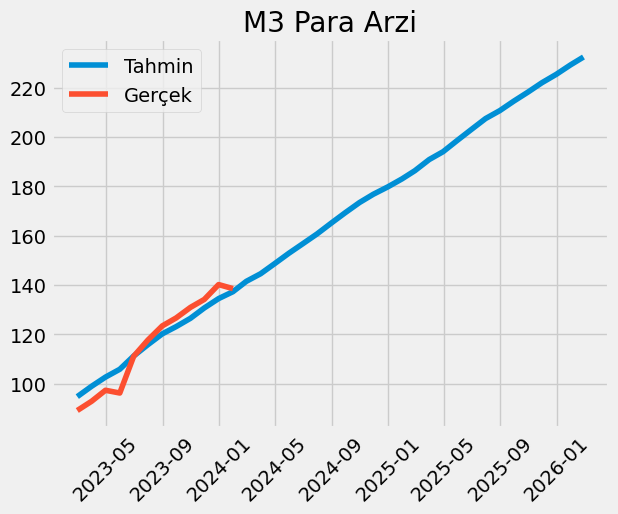

In [237]:
plt.title("M3 Para Arzi")
plt.plot(predictions["yhat"][-37:],label="Tahmin")
plt.plot(money["M3 Para Arzi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [238]:
paraarzitahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(25)
paraarzitahmin

ds
2024-02-29    3.061318
2024-03-31    2.182179
2024-04-30    2.791936
2024-05-31    2.851835
2024-06-30    2.509648
2024-07-31    2.549965
2024-08-31    2.750009
2024-09-30    2.529998
2024-10-31    2.438702
2024-11-30    1.943645
2024-12-31    1.667631
2025-01-31    1.816030
2025-02-28    1.825534
2025-03-31    2.417893
2025-04-30    1.665567
2025-05-31    2.374811
2025-06-30    2.195995
2025-07-31    2.195012
2025-08-31    1.562367
2025-09-30    1.808092
2025-10-31    1.723208
2025-11-30    1.728203
2025-12-31    1.528408
2026-01-31    1.705635
2026-02-28    1.387122
Name: yhat, dtype: float64

In [239]:
paraarzitahmin1 = []
result = money.iloc[-1,0]
for i in range(len(paraarzitahmin)):
    result *= (1 + paraarzitahmin[i] / 100)
    paraarzitahmin1.append(result)

paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["M3 Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-01-30", periods=len(paraarzitahmin1), freq="1M"))
row=pd.DataFrame({"M3 Para Arzi":money.iloc[-4:,0]},index=pd.date_range(start="2023-09-30",periods=4,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
paraarzitahmin1

,M3 Para Arzi
2023-09-30,NaN
2023-10-31,130.934676
2023-11-30,134.161244
2023-12-31,140.183543
2024-01-31,142.773692
2024-02-29,145.889269
2024-03-31,149.962404
2024-04-30,154.239085
2024-05-31,158.109943
2024-06-30,162.141690


In [240]:

def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,200),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi Hacmi"][params["m"]:-12].index
    sn["y"]=df3["Kredi Hacmi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3["Kredi Hacmi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2024-01-18 13:56:13,624] A new study created in memory with name: no-name-4adff0d0-d2e5-4eef-b055-b7a0708a799e
13:56:13 - cmdstanpy - INFO - Chain [1] start processing
13:56:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:56:14,029] Trial 0 finished with value: 17.071054256838682 and parameters: {'changepoint_prior_scale': 0.32857364437177267, 'changepoint_range': 0.8997895271336959, 'growth': 'logistic', 'seasonality_prior_scale': 5.258977102622122, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 82, 'cap': 139.73012014403773}. Best is trial 0 with value: 17.071054256838682.
13:56:14 - cmdstanpy - INFO - Chain [1] start processing
13:56:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:56:14,410] Trial 1 finished with value: 710.3401026779106 and parameters: {'changepoint_prior_scale': 4.45558847164395, 'changepoint_range': 0.10415568057540839, 'growth': 'linear', 'seasonality_prior_scale': 5.249705866793922, 

13:56:22 - cmdstanpy - INFO - Chain [1] start processing
13:56:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:56:23,133] Trial 15 finished with value: 261.8793972996637 and parameters: {'changepoint_prior_scale': 0.6425403685181093, 'changepoint_range': 0.4757173178269327, 'growth': 'linear', 'seasonality_prior_scale': 6.589755269558532, 'n_changepoints': 9, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 158, 'cap': 301.51978417990773}. Best is trial 0 with value: 17.071054256838682.
13:56:23 - cmdstanpy - INFO - Chain [1] start processing
13:56:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:56:23,518] Trial 16 finished with value: 241.28616026312912 and parameters: {'changepoint_prior_scale': 1.5796053556724914, 'changepoint_range': 0.7893497317893894, 'growth': 'linear', 'seasonality_prior_scale': 2.04132175579017, 'n_changepoints': 1, 'yearly_seasonality': False, 'weekly_seasonality': True, 'm': 92, 'cap': 397.7296609028705}. 

13:56:57 - cmdstanpy - INFO - Chain [1] start processing
13:56:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:56:57,262] Trial 31 finished with value: 91.50456980213782 and parameters: {'changepoint_prior_scale': 4.899544564536654, 'changepoint_range': 0.7984009069329759, 'growth': 'logistic', 'seasonality_prior_scale': 6.3986636156492125, 'n_changepoints': 11, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 174, 'cap': 216.30333853228143}. Best is trial 23 with value: 12.286853813901898.
13:56:57 - cmdstanpy - INFO - Chain [1] start processing
13:56:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:56:57,706] Trial 32 finished with value: 81.80690396859649 and parameters: {'changepoint_prior_scale': 4.615797765450639, 'changepoint_range': 0.6304129186499758, 'growth': 'logistic', 'seasonality_prior_scale': 6.120550247629181, 'n_changepoints': 10, 'yearly_seasonality': False, 'weekly_seasonality': 'auto', 'm': 187, 'cap': 234.5847804

13:57:06 - cmdstanpy - INFO - Chain [1] start processing
13:57:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:57:06,472] Trial 47 finished with value: 4.53041950591318 and parameters: {'changepoint_prior_scale': 2.988356349204434, 'changepoint_range': 0.8989591540989756, 'growth': 'logistic', 'seasonality_prior_scale': 3.582564152302798, 'n_changepoints': 6, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 106, 'cap': 354.0216229846892}. Best is trial 42 with value: 3.4735653191481606.
13:57:06 - cmdstanpy - INFO - Chain [1] start processing
13:57:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:57:06,952] Trial 48 finished with value: 575.0510818086146 and parameters: {'changepoint_prior_scale': 2.9036429091370763, 'changepoint_range': 0.2804822444345546, 'growth': 'logistic', 'seasonality_prior_scale': 1.3410116807686676, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 104, 'cap': 343.0007938251814

13:57:14 - cmdstanpy - INFO - Chain [1] start processing
13:57:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:57:14,537] Trial 63 finished with value: 3.2946922280126607 and parameters: {'changepoint_prior_scale': 2.280371044806465, 'changepoint_range': 0.8572949588883438, 'growth': 'logistic', 'seasonality_prior_scale': 4.069974472968272, 'n_changepoints': 8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 97, 'cap': 324.96223570069617}. Best is trial 56 with value: 2.944751770150489.
13:57:14 - cmdstanpy - INFO - Chain [1] start processing
13:57:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:57:15,035] Trial 64 finished with value: 8.440847244785365 and parameters: {'changepoint_prior_scale': 1.8066449779644262, 'changepoint_range': 0.8561526307004766, 'growth': 'logistic', 'seasonality_prior_scale': 3.9866751561579883, 'n_changepoints': 9, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 72, 'cap': 327.3492171645803}. 

13:57:21 - cmdstanpy - INFO - Chain [1] start processing
13:57:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:57:21,905] Trial 79 finished with value: 36.500823584872386 and parameters: {'changepoint_prior_scale': 2.757593817104008, 'changepoint_range': 0.8050091081211667, 'growth': 'logistic', 'seasonality_prior_scale': 4.1044337502408235, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 154, 'cap': 362.4898522098172}. Best is trial 56 with value: 2.944751770150489.
13:57:22 - cmdstanpy - INFO - Chain [1] start processing
13:57:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:57:22,539] Trial 80 finished with value: 10.301860772097601 and parameters: {'changepoint_prior_scale': 3.040628258097743, 'changepoint_range': 0.8341735762046668, 'growth': 'logistic', 'seasonality_prior_scale': 4.762985403792078, 'n_changepoints': 23, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 82, 'cap': 319.28055201945176

13:57:30 - cmdstanpy - INFO - Chain [1] start processing
13:57:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:57:31,229] Trial 95 finished with value: 3.458816575706854 and parameters: {'changepoint_prior_scale': 3.5344935341641044, 'changepoint_range': 0.8717241093951942, 'growth': 'logistic', 'seasonality_prior_scale': 3.5139583256804947, 'n_changepoints': 11, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 81, 'cap': 326.191369336666}. Best is trial 56 with value: 2.944751770150489.
13:57:31 - cmdstanpy - INFO - Chain [1] start processing
13:57:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:57:31,718] Trial 96 finished with value: 77.9110007742641 and parameters: {'changepoint_prior_scale': 3.277155133660348, 'changepoint_range': 0.7541358055987191, 'growth': 'logistic', 'seasonality_prior_scale': 2.3830979003475994, 'n_changepoints': 11, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 97, 'cap': 337.4394584325742}. B

13:57:39 - cmdstanpy - INFO - Chain [1] start processing
13:57:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:57:39,353] Trial 111 finished with value: 73.81515300569079 and parameters: {'changepoint_prior_scale': 3.7085203143249474, 'changepoint_range': 0.8311868588551261, 'growth': 'logistic', 'seasonality_prior_scale': 3.7964976698324384, 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 61, 'cap': 292.9636986690545}. Best is trial 56 with value: 2.944751770150489.
13:57:39 - cmdstanpy - INFO - Chain [1] start processing
13:57:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:57:39,853] Trial 112 finished with value: 3.9012141867897117 and parameters: {'changepoint_prior_scale': 3.9617530279484505, 'changepoint_range': 0.8762109161198773, 'growth': 'logistic', 'seasonality_prior_scale': 3.016381412224234, 'n_changepoints': 15, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 81, 'cap': 302.584320811227

13:58:12 - cmdstanpy - INFO - Chain [1] start processing
13:58:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:58:12,961] Trial 127 finished with value: 3.1277873812471326 and parameters: {'changepoint_prior_scale': 2.526288312750159, 'changepoint_range': 0.8637807536737132, 'growth': 'logistic', 'seasonality_prior_scale': 3.3749624182259192, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 82, 'cap': 296.00027054293355}. Best is trial 56 with value: 2.944751770150489.
13:58:13 - cmdstanpy - INFO - Chain [1] start processing
13:58:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:58:13,424] Trial 128 finished with value: 81.3980463721035 and parameters: {'changepoint_prior_scale': 2.3404637877271424, 'changepoint_range': 0.8669359729400058, 'growth': 'linear', 'seasonality_prior_scale': 2.4586188818665673, 'n_changepoints': 9, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 80, 'cap': 286.49645714929204}.

13:58:21 - cmdstanpy - INFO - Chain [1] start processing
13:58:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:58:21,265] Trial 143 finished with value: 29.651104582341947 and parameters: {'changepoint_prior_scale': 2.1962553038970807, 'changepoint_range': 0.8818619283845772, 'growth': 'logistic', 'seasonality_prior_scale': 3.398500227663177, 'n_changepoints': 2, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 94, 'cap': 333.11116907214534}. Best is trial 56 with value: 2.944751770150489.
13:58:21 - cmdstanpy - INFO - Chain [1] start processing
13:58:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:58:21,768] Trial 144 finished with value: 18.022999157699974 and parameters: {'changepoint_prior_scale': 2.6793802622370255, 'changepoint_range': 0.8994491024731157, 'growth': 'logistic', 'seasonality_prior_scale': 2.5206027335137984, 'n_changepoints': 3, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 68, 'cap': 373.372717745188

13:58:29 - cmdstanpy - INFO - Chain [1] start processing
13:58:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:58:29,230] Trial 159 finished with value: 52.81435697312208 and parameters: {'changepoint_prior_scale': 4.04717518096803, 'changepoint_range': 0.8856364439291535, 'growth': 'logistic', 'seasonality_prior_scale': 2.5630759989421334, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 92, 'cap': 331.3654665703723}. Best is trial 56 with value: 2.944751770150489.
13:58:29 - cmdstanpy - INFO - Chain [1] start processing
13:58:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:58:29,672] Trial 160 finished with value: 3.7601241673161163 and parameters: {'changepoint_prior_scale': 2.40409750923921, 'changepoint_range': 0.865303173368806, 'growth': 'logistic', 'seasonality_prior_scale': 2.322137126344398, 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 74, 'cap': 356.55888320616884}. 

13:58:36 - cmdstanpy - INFO - Chain [1] start processing
13:58:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:58:36,824] Trial 175 finished with value: 3.2330439140394063 and parameters: {'changepoint_prior_scale': 4.379684635503202, 'changepoint_range': 0.8970097497169254, 'growth': 'logistic', 'seasonality_prior_scale': 0.4229554118632249, 'n_changepoints': 9, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 62, 'cap': 281.25270986132045}. Best is trial 56 with value: 2.944751770150489.
13:58:37 - cmdstanpy - INFO - Chain [1] start processing
13:58:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:58:37,371] Trial 176 finished with value: 18.34639203412625 and parameters: {'changepoint_prior_scale': 4.335445850824995, 'changepoint_range': 0.8837188487257113, 'growth': 'logistic', 'seasonality_prior_scale': 0.4761804773941444, 'n_changepoints': 9, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 46, 'cap': 278.8827781483589}

13:58:44 - cmdstanpy - INFO - Chain [1] start processing
13:58:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:58:44,506] Trial 191 finished with value: 3.246499083169304 and parameters: {'changepoint_prior_scale': 4.816017577829939, 'changepoint_range': 0.899358022536507, 'growth': 'logistic', 'seasonality_prior_scale': 0.18579681235911072, 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 67, 'cap': 287.9256077191095}. Best is trial 56 with value: 2.944751770150489.
13:58:44 - cmdstanpy - INFO - Chain [1] start processing
13:58:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:58:45,051] Trial 192 finished with value: 6.9425070725369595 and parameters: {'changepoint_prior_scale': 4.815985303451996, 'changepoint_range': 0.8715054826547087, 'growth': 'logistic', 'seasonality_prior_scale': 0.2738937630906063, 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 68, 'cap': 285.6812602900762

13:58:52 - cmdstanpy - INFO - Chain [1] start processing
13:58:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:58:53,222] Trial 207 finished with value: 3.627062324683246 and parameters: {'changepoint_prior_scale': 4.985618592768064, 'changepoint_range': 0.870277764653902, 'growth': 'logistic', 'seasonality_prior_scale': 0.8158399850878504, 'n_changepoints': 9, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 77, 'cap': 306.8578789170214}. Best is trial 56 with value: 2.944751770150489.
13:58:53 - cmdstanpy - INFO - Chain [1] start processing
13:58:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:58:53,717] Trial 208 finished with value: 3.8058928073189904 and parameters: {'changepoint_prior_scale': 4.12509222892945, 'changepoint_range': 0.8845435842068157, 'growth': 'logistic', 'seasonality_prior_scale': 0.34751624715368856, 'n_changepoints': 12, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 73, 'cap': 263.91412546446094}

13:59:01 - cmdstanpy - INFO - Chain [1] start processing
13:59:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:59:01,779] Trial 223 finished with value: 3.3196041995303815 and parameters: {'changepoint_prior_scale': 3.972748805121405, 'changepoint_range': 0.8996885240767908, 'growth': 'logistic', 'seasonality_prior_scale': 0.4697690698633107, 'n_changepoints': 11, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 60, 'cap': 303.049592613215}. Best is trial 56 with value: 2.944751770150489.
13:59:01 - cmdstanpy - INFO - Chain [1] start processing
13:59:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:59:02,219] Trial 224 finished with value: 4.327607031131097 and parameters: {'changepoint_prior_scale': 1.716902248519212, 'changepoint_range': 0.8746360965971699, 'growth': 'logistic', 'seasonality_prior_scale': 0.24195612979109526, 'n_changepoints': 11, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 72, 'cap': 276.1634755135926

13:59:09 - cmdstanpy - INFO - Chain [1] start processing
13:59:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:59:09,925] Trial 239 finished with value: 8.44070213017512 and parameters: {'changepoint_prior_scale': 4.186542577289567, 'changepoint_range': 0.8680048512302714, 'growth': 'logistic', 'seasonality_prior_scale': 0.4385230044874007, 'n_changepoints': 11, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 62, 'cap': 307.6746290900072}. Best is trial 56 with value: 2.944751770150489.
13:59:10 - cmdstanpy - INFO - Chain [1] start processing
13:59:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:59:10,601] Trial 240 finished with value: 28.02306147783366 and parameters: {'changepoint_prior_scale': 3.8748574549538004, 'changepoint_range': 0.8841109883083392, 'growth': 'logistic', 'seasonality_prior_scale': 0.26336027183023625, 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 149, 'cap': 292.005573068348

13:59:19 - cmdstanpy - INFO - Chain [1] start processing
13:59:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:59:19,453] Trial 255 finished with value: 613.5904757938569 and parameters: {'changepoint_prior_scale': 4.001496927626597, 'changepoint_range': 0.43821069427254555, 'growth': 'logistic', 'seasonality_prior_scale': 0.3148602520038559, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 74, 'cap': 305.7473518601357}. Best is trial 56 with value: 2.944751770150489.
13:59:19 - cmdstanpy - INFO - Chain [1] start processing
13:59:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:59:20,126] Trial 256 finished with value: 395.66078063707886 and parameters: {'changepoint_prior_scale': 4.609605772164752, 'changepoint_range': 0.6093798961977813, 'growth': 'logistic', 'seasonality_prior_scale': 0.5024373906334212, 'n_changepoints': 12, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 67, 'cap': 314.021109318

13:59:30 - cmdstanpy - INFO - Chain [1] start processing
13:59:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:59:30,858] Trial 271 finished with value: 61.23857622635209 and parameters: {'changepoint_prior_scale': 3.9039207910725398, 'changepoint_range': 0.8998460320745648, 'growth': 'logistic', 'seasonality_prior_scale': 0.33419019032071806, 'n_changepoints': 11, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 132, 'cap': 278.1340698965687}. Best is trial 56 with value: 2.944751770150489.
13:59:31 - cmdstanpy - INFO - Chain [1] start processing
13:59:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 13:59:52,851] Trial 272 finished with value: 131.03421321303395 and parameters: {'changepoint_prior_scale': 4.066251755839329, 'changepoint_range': 0.8654128139293357, 'growth': 'logistic', 'seasonality_prior_scale': 0.7117537806023632, 'n_changepoints': 21, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 169, 'cap': 294.8325881

14:00:02 - cmdstanpy - INFO - Chain [1] start processing
14:00:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:00:02,601] Trial 287 finished with value: 3.2112707947608143 and parameters: {'changepoint_prior_scale': 4.032762919576375, 'changepoint_range': 0.8854041527280719, 'growth': 'logistic', 'seasonality_prior_scale': 0.5348996823560719, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 64, 'cap': 269.67267373449386}. Best is trial 56 with value: 2.944751770150489.
14:00:02 - cmdstanpy - INFO - Chain [1] start processing
14:00:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:00:03,023] Trial 288 finished with value: 803.9189818123886 and parameters: {'changepoint_prior_scale': 4.01005424162359, 'changepoint_range': 0.3379675060596163, 'growth': 'logistic', 'seasonality_prior_scale': 0.5577814422758773, 'n_changepoints': 1, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 64, 'cap': 260.62178179930544}

14:00:24 - cmdstanpy - INFO - Chain [1] start processing
14:00:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:00:25,952] Trial 303 finished with value: 86.75983914941371 and parameters: {'changepoint_prior_scale': 3.9495724675017465, 'changepoint_range': 0.8739136728094894, 'growth': 'logistic', 'seasonality_prior_scale': 0.8620812231929887, 'n_changepoints': 12, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 153, 'cap': 287.48580006188445}. Best is trial 56 with value: 2.944751770150489.
14:00:26 - cmdstanpy - INFO - Chain [1] start processing
14:00:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:00:26,481] Trial 304 finished with value: 30.44414147046051 and parameters: {'changepoint_prior_scale': 3.7402524908595782, 'changepoint_range': 0.8477333244530143, 'growth': 'logistic', 'seasonality_prior_scale': 1.8427217648239644, 'n_changepoints': 13, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 64, 'cap': 281.8600564518

14:01:03 - cmdstanpy - INFO - Chain [1] start processing
14:01:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:01:04,282] Trial 319 finished with value: 3.3552468454984186 and parameters: {'changepoint_prior_scale': 4.798619353680747, 'changepoint_range': 0.8999915729312502, 'growth': 'logistic', 'seasonality_prior_scale': 0.40666041507671136, 'n_changepoints': 12, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 64, 'cap': 281.00332419040245}. Best is trial 56 with value: 2.944751770150489.
14:01:04 - cmdstanpy - INFO - Chain [1] start processing
14:01:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:01:22,053] Trial 320 finished with value: 384.73690745355566 and parameters: {'changepoint_prior_scale': 4.033566074147883, 'changepoint_range': 0.8804791658715975, 'growth': 'logistic', 'seasonality_prior_scale': 0.5420956920590535, 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 187, 'cap': 297.497990245

14:02:02 - cmdstanpy - INFO - Chain [1] start processing
14:02:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:02:03,707] Trial 335 finished with value: 8.972929405459256 and parameters: {'changepoint_prior_scale': 1.7228468258429444, 'changepoint_range': 0.8704056360353207, 'growth': 'logistic', 'seasonality_prior_scale': 1.2799419119709943, 'n_changepoints': 11, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 65, 'cap': 302.8048863555927}. Best is trial 56 with value: 2.944751770150489.
14:02:03 - cmdstanpy - INFO - Chain [1] start processing
14:02:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:02:04,217] Trial 336 finished with value: 3.887715685311896 and parameters: {'changepoint_prior_scale': 3.7884892917236916, 'changepoint_range': 0.8998275050497974, 'growth': 'logistic', 'seasonality_prior_scale': 0.9904133110964606, 'n_changepoints': 12, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 70, 'cap': 276.680678394547

14:02:52 - cmdstanpy - INFO - Chain [1] start processing
14:02:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:02:54,008] Trial 351 finished with value: 42.84266131304107 and parameters: {'changepoint_prior_scale': 4.099661832288804, 'changepoint_range': 0.8995464703450389, 'growth': 'logistic', 'seasonality_prior_scale': 0.7969178149878972, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 128, 'cap': 305.9758955846264}. Best is trial 56 with value: 2.944751770150489.
14:02:54 - cmdstanpy - INFO - Chain [1] start processing
14:02:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:02:54,551] Trial 352 finished with value: 3.410637658851 and parameters: {'changepoint_prior_scale': 4.411837715856051, 'changepoint_range': 0.883059880408287, 'growth': 'logistic', 'seasonality_prior_scale': 0.35934018058409295, 'n_changepoints': 12, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 74, 'cap': 284.41766668051685}. 

14:03:02 - cmdstanpy - INFO - Chain [1] start processing
14:03:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:03,078] Trial 367 finished with value: 5.362511120092306 and parameters: {'changepoint_prior_scale': 4.00636752522701, 'changepoint_range': 0.8661675590220987, 'growth': 'logistic', 'seasonality_prior_scale': 0.01550295457349643, 'n_changepoints': 11, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 73, 'cap': 286.75693085550034}. Best is trial 56 with value: 2.944751770150489.
14:03:03 - cmdstanpy - INFO - Chain [1] start processing
14:03:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:03,546] Trial 368 finished with value: 1747.897553341815 and parameters: {'changepoint_prior_scale': 4.393503837408527, 'changepoint_range': 0.275383387462219, 'growth': 'linear', 'seasonality_prior_scale': 0.35989051457519305, 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 79, 'cap': 302.60051648187545}

14:03:11 - cmdstanpy - INFO - Chain [1] start processing
14:03:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:12,128] Trial 383 finished with value: 399.60360375777253 and parameters: {'changepoint_prior_scale': 4.095176704309902, 'changepoint_range': 0.5120626400950905, 'growth': 'logistic', 'seasonality_prior_scale': 1.405377392467324, 'n_changepoints': 12, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 94, 'cap': 297.58298305142154}. Best is trial 56 with value: 2.944751770150489.
14:03:12 - cmdstanpy - INFO - Chain [1] start processing
14:03:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:12,664] Trial 384 finished with value: 14.45980769230394 and parameters: {'changepoint_prior_scale': 4.190091822453077, 'changepoint_range': 0.8865793452891255, 'growth': 'logistic', 'seasonality_prior_scale': 0.010160655066185298, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': 'auto', 'm': 48, 'cap': 282.8943814701

14:03:20 - cmdstanpy - INFO - Chain [1] start processing
14:03:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:20,251] Trial 399 finished with value: 30.438015529399124 and parameters: {'changepoint_prior_scale': 4.381110453739071, 'changepoint_range': 0.8153373552293232, 'growth': 'logistic', 'seasonality_prior_scale': 0.1480343373340775, 'n_changepoints': 7, 'yearly_seasonality': True, 'weekly_seasonality': True, 'm': 91, 'cap': 278.3530962618193}. Best is trial 56 with value: 2.944751770150489.
14:03:20 - cmdstanpy - INFO - Chain [1] start processing
14:03:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:20,799] Trial 400 finished with value: 8.576730294738864 and parameters: {'changepoint_prior_scale': 4.100882445775409, 'changepoint_range': 0.8413754308000309, 'growth': 'logistic', 'seasonality_prior_scale': 0.2929021595040049, 'n_changepoints': 12, 'yearly_seasonality': True, 'weekly_seasonality': False, 'm': 87, 'cap': 268.3431162071780

14:03:28 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:28,653] Trial 415 finished with value: 5.548131325134893 and parameters: {'changepoint_prior_scale': 4.450685490728867, 'changepoint_range': 0.8632904728826116, 'growth': 'logistic', 'seasonality_prior_scale': 0.4452522417487883, 'n_changepoints': 9, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 78, 'cap': 304.9856032715956}. Best is trial 56 with value: 2.944751770150489.
14:03:28 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:29,075] Trial 416 finished with value: 3.1308345667442183 and parameters: {'changepoint_prior_scale': 4.542744460519826, 'changepoint_range': 0.8776390425874737, 'growth': 'logistic', 'seasonality_prior_scale': 0.5962391488965857, 'n_changepoints': 10, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 82, 'cap': 289.4395584241

14:03:35 - cmdstanpy - INFO - Chain [1] start processing
14:03:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:36,133] Trial 431 finished with value: 3.381054776213844 and parameters: {'changepoint_prior_scale': 4.398778221071191, 'changepoint_range': 0.8577125476696902, 'growth': 'logistic', 'seasonality_prior_scale': 0.26774745230434915, 'n_changepoints': 9, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'm': 98, 'cap': 289.6592646781472}. Best is trial 56 with value: 2.944751770150489.
14:03:36 - cmdstanpy - INFO - Chain [1] start processing
14:03:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:36,617] Trial 432 finished with value: 3.249371407216792 and parameters: {'changepoint_prior_scale': 4.828924767612744, 'changepoint_range': 0.8763773692957624, 'growth': 'logistic', 'seasonality_prior_scale': 0.41278992931299846, 'n_changepoints': 10, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 88, 'cap': 281.7311245

14:03:43 - cmdstanpy - INFO - Chain [1] start processing
14:03:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:44,052] Trial 447 finished with value: 31.223795714179015 and parameters: {'changepoint_prior_scale': 4.146686559036895, 'changepoint_range': 0.8072377175121177, 'growth': 'logistic', 'seasonality_prior_scale': 0.6336553655616007, 'n_changepoints': 9, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 95, 'cap': 284.0009187577656}. Best is trial 56 with value: 2.944751770150489.
14:03:44 - cmdstanpy - INFO - Chain [1] start processing
14:03:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:44,566] Trial 448 finished with value: 372.8654157486945 and parameters: {'changepoint_prior_scale': 4.409205937715097, 'changepoint_range': 0.5795102182901636, 'growth': 'logistic', 'seasonality_prior_scale': 0.9453199222728823, 'n_changepoints': 4, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 89, 'cap': 261.45948219831

14:03:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:53,928] Trial 462 finished with value: 14.42862502563198 and parameters: {'changepoint_prior_scale': 4.530010658150029, 'changepoint_range': 0.8297370366776039, 'growth': 'logistic', 'seasonality_prior_scale': 1.108804374090472, 'n_changepoints': 9, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 87, 'cap': 297.3803064318236}. Best is trial 56 with value: 2.944751770150489.
14:03:54 - cmdstanpy - INFO - Chain [1] start processing
14:03:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:03:54,465] Trial 463 finished with value: 82.84234129992605 and parameters: {'changepoint_prior_scale': 4.652175189265099, 'changepoint_range': 0.8105520778530032, 'growth': 'logistic', 'seasonality_prior_scale': 1.2587181300314443, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 91, 'cap': 180.40428765590903}. Best is trial 56 with value: 2.944751770150489.
14:03

14:04:01 - cmdstanpy - INFO - Chain [1] start processing
14:04:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:01,976] Trial 478 finished with value: 3.3613402028685524 and parameters: {'changepoint_prior_scale': 4.65547763057556, 'changepoint_range': 0.8457824428143802, 'growth': 'logistic', 'seasonality_prior_scale': 1.5908668640556742, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 94, 'cap': 333.0945686874466}. Best is trial 56 with value: 2.944751770150489.
14:04:02 - cmdstanpy - INFO - Chain [1] start processing
14:04:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:02,455] Trial 479 finished with value: 4.599912806379984 and parameters: {'changepoint_prior_scale': 4.870558036564729, 'changepoint_range': 0.8348374104841182, 'growth': 'logistic', 'seasonality_prior_scale': 1.4225400953353904, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 98, 'cap': 323.635623144455

14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:10,030] Trial 494 finished with value: 15.84964290354659 and parameters: {'changepoint_prior_scale': 4.56936471100254, 'changepoint_range': 0.853741160916467, 'growth': 'logistic', 'seasonality_prior_scale': 1.065592400155443, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 94, 'cap': 201.40215122565053}. Best is trial 56 with value: 2.944751770150489.
14:04:10 - cmdstanpy - INFO - Chain [1] start processing
14:04:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:10,524] Trial 495 finished with value: 3.088713139215741 and parameters: {'changepoint_prior_scale': 4.739089835297831, 'changepoint_range': 0.8713006086123635, 'growth': 'logistic', 'seasonality_prior_scale': 1.6186538689093106, 'n_changepoints': 9, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 85, 'cap': 301.8214731546599}

14:04:17 - cmdstanpy - INFO - Chain [1] start processing
14:04:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:18,007] Trial 510 finished with value: 4.880348164476113 and parameters: {'changepoint_prior_scale': 2.7817101857949815, 'changepoint_range': 0.8528544796616793, 'growth': 'logistic', 'seasonality_prior_scale': 1.5696755134551486, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 87, 'cap': 321.643078380005}. Best is trial 56 with value: 2.944751770150489.
14:04:18 - cmdstanpy - INFO - Chain [1] start processing
14:04:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:18,524] Trial 511 finished with value: 3.139147564824301 and parameters: {'changepoint_prior_scale': 4.688993639550623, 'changepoint_range': 0.8666784912481335, 'growth': 'logistic', 'seasonality_prior_scale': 1.9173516755770779, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 84, 'cap': 307.890097167239

14:04:26 - cmdstanpy - INFO - Chain [1] start processing
14:04:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:26,876] Trial 526 finished with value: 13.172760775291602 and parameters: {'changepoint_prior_scale': 3.167889974862898, 'changepoint_range': 0.849704003228737, 'growth': 'logistic', 'seasonality_prior_scale': 1.4326913402189543, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'm': 84, 'cap': 306.6914020292125}. Best is trial 56 with value: 2.944751770150489.
14:04:27 - cmdstanpy - INFO - Chain [1] start processing
14:04:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:27,386] Trial 527 finished with value: 3.659240060006214 and parameters: {'changepoint_prior_scale': 3.0546700152700335, 'changepoint_range': 0.856200563989407, 'growth': 'logistic', 'seasonality_prior_scale': 2.2248620492790834, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 87, 'cap': 305.4151527782

14:04:35 - cmdstanpy - INFO - Chain [1] start processing
14:04:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:35,271] Trial 542 finished with value: 3.451458430258088 and parameters: {'changepoint_prior_scale': 4.988139436929472, 'changepoint_range': 0.8839135785661387, 'growth': 'logistic', 'seasonality_prior_scale': 2.348137728062674, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 83, 'cap': 292.0496725760386}. Best is trial 56 with value: 2.944751770150489.
14:04:35 - cmdstanpy - INFO - Chain [1] start processing
14:04:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:35,778] Trial 543 finished with value: 3.532103581740841 and parameters: {'changepoint_prior_scale': 4.908180109222258, 'changepoint_range': 0.8831681024824974, 'growth': 'logistic', 'seasonality_prior_scale': 2.442047724931818, 'n_changepoints': 4, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 83, 'cap': 292.1904613244189

14:04:44 - cmdstanpy - INFO - Chain [1] start processing
14:04:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:44,935] Trial 558 finished with value: 3.3866315658086634 and parameters: {'changepoint_prior_scale': 2.6268696071301627, 'changepoint_range': 0.8672394748651568, 'growth': 'logistic', 'seasonality_prior_scale': 2.1963431685110395, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 89, 'cap': 294.1453157940576}. Best is trial 56 with value: 2.944751770150489.
14:04:45 - cmdstanpy - INFO - Chain [1] start processing
14:04:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:45,476] Trial 559 finished with value: 3.027507945415545 and parameters: {'changepoint_prior_scale': 2.7506144798966474, 'changepoint_range': 0.8854477522904426, 'growth': 'logistic', 'seasonality_prior_scale': 2.4025317017252044, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 84, 'cap': 285.933054480

14:04:53 - cmdstanpy - INFO - Chain [1] start processing
14:04:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:53,867] Trial 574 finished with value: 3.8257882346963346 and parameters: {'changepoint_prior_scale': 2.8783213630260955, 'changepoint_range': 0.8969572753756523, 'growth': 'logistic', 'seasonality_prior_scale': 2.748830797811004, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 76, 'cap': 268.2405181058833}. Best is trial 568 with value: 2.9240396694635655.
14:04:54 - cmdstanpy - INFO - Chain [1] start processing
14:04:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:04:54,377] Trial 575 finished with value: 3.356190201379387 and parameters: {'changepoint_prior_scale': 2.998866224267432, 'changepoint_range': 0.8988414543005289, 'growth': 'logistic', 'seasonality_prior_scale': 3.032327134091097, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'm': 77, 'cap': 264.29714884

14:05:01 - cmdstanpy - INFO - Chain [1] start processing
14:05:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:05:01,983] Trial 590 finished with value: 3.6636035874230743 and parameters: {'changepoint_prior_scale': 2.957895362797995, 'changepoint_range': 0.8868386260149469, 'growth': 'logistic', 'seasonality_prior_scale': 2.73245195456431, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 81, 'cap': 260.54193582095394}. Best is trial 583 with value: 2.8543188455141446.
14:05:02 - cmdstanpy - INFO - Chain [1] start processing
14:05:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:05:02,651] Trial 591 finished with value: 3.309285669359332 and parameters: {'changepoint_prior_scale': 3.0148854864736205, 'changepoint_range': 0.8986341606729816, 'growth': 'logistic', 'seasonality_prior_scale': 3.038815698658628, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 79, 'cap': 254.305179504

14:05:12 - cmdstanpy - INFO - Chain [1] start processing
14:05:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:05:12,947] Trial 606 finished with value: 96.65542149780367 and parameters: {'changepoint_prior_scale': 3.3586958442801196, 'changepoint_range': 0.8979747344107174, 'growth': 'logistic', 'seasonality_prior_scale': 2.4791045232476256, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 138, 'cap': 260.5392630784471}. Best is trial 583 with value: 2.8543188455141446.
14:05:13 - cmdstanpy - INFO - Chain [1] start processing
14:05:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:05:13,499] Trial 607 finished with value: 2.9436627728401397 and parameters: {'changepoint_prior_scale': 3.0586891123945206, 'changepoint_range': 0.8986175959849683, 'growth': 'logistic', 'seasonality_prior_scale': 2.930120683247202, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 76, 'cap': 270.1959448

14:05:21 - cmdstanpy - INFO - Chain [1] start processing
14:05:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:05:21,463] Trial 622 finished with value: 3.2389476981427627 and parameters: {'changepoint_prior_scale': 2.603266011183896, 'changepoint_range': 0.8995693185750676, 'growth': 'logistic', 'seasonality_prior_scale': 3.180471535039462, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 78, 'cap': 258.88433805521305}. Best is trial 583 with value: 2.8543188455141446.
14:05:21 - cmdstanpy - INFO - Chain [1] start processing
14:05:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:05:22,020] Trial 623 finished with value: 4.442451014800458 and parameters: {'changepoint_prior_scale': 2.5485380022653157, 'changepoint_range': 0.8980651646620204, 'growth': 'logistic', 'seasonality_prior_scale': 3.150206280489529, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 72, 'cap': 241.592896385

14:05:29 - cmdstanpy - INFO - Chain [1] start processing
14:05:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:05:30,060] Trial 638 finished with value: 8.064214572293167 and parameters: {'changepoint_prior_scale': 2.769208657232813, 'changepoint_range': 0.8802398522850199, 'growth': 'logistic', 'seasonality_prior_scale': 2.817502054267069, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 78, 'cap': 255.0392869852626}. Best is trial 583 with value: 2.8543188455141446.
14:05:30 - cmdstanpy - INFO - Chain [1] start processing
14:05:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:05:30,551] Trial 639 finished with value: 656.9925997562563 and parameters: {'changepoint_prior_scale': 2.8855170847616316, 'changepoint_range': 0.37722421963806824, 'growth': 'logistic', 'seasonality_prior_scale': 3.125795136115619, 'n_changepoints': 5, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 83, 'cap': 268.4314477179

14:05:38 - cmdstanpy - INFO - Chain [1] start processing
14:05:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:05:38,357] Trial 654 finished with value: 5.310386971894856 and parameters: {'changepoint_prior_scale': 2.958178950633789, 'changepoint_range': 0.8848856444119788, 'growth': 'logistic', 'seasonality_prior_scale': 2.3567159074783173, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 80, 'cap': 256.70779608440216}. Best is trial 583 with value: 2.8543188455141446.
14:05:38 - cmdstanpy - INFO - Chain [1] start processing
14:05:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:05:38,920] Trial 655 finished with value: 3.4678666811714263 and parameters: {'changepoint_prior_scale': 3.1597466383464923, 'changepoint_range': 0.8995985286127528, 'growth': 'logistic', 'seasonality_prior_scale': 2.604015214674355, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 72, 'cap': 265.66335687

14:06:06 - cmdstanpy - INFO - Chain [1] start processing
14:06:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:06:07,080] Trial 670 finished with value: 8.056118829217635 and parameters: {'changepoint_prior_scale': 3.024517444245516, 'changepoint_range': 0.8863068162463441, 'growth': 'logistic', 'seasonality_prior_scale': 2.738710740710652, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 71, 'cap': 263.0134737599464}. Best is trial 583 with value: 2.8543188455141446.
14:06:07 - cmdstanpy - INFO - Chain [1] start processing
14:06:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:06:07,604] Trial 671 finished with value: 1349.8618574709617 and parameters: {'changepoint_prior_scale': 3.199390357682648, 'changepoint_range': 0.46700500049659616, 'growth': 'linear', 'seasonality_prior_scale': 2.942771507361678, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 77, 'cap': 236.492148877443

14:06:15 - cmdstanpy - INFO - Chain [1] start processing
14:06:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:06:16,022] Trial 686 finished with value: 517.3475076790403 and parameters: {'changepoint_prior_scale': 3.2335121737900865, 'changepoint_range': 0.49411483554792784, 'growth': 'logistic', 'seasonality_prior_scale': 2.2474376222162977, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 85, 'cap': 269.15352217615805}. Best is trial 583 with value: 2.8543188455141446.
14:06:16 - cmdstanpy - INFO - Chain [1] start processing
14:06:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:06:16,562] Trial 687 finished with value: 18.426894452022903 and parameters: {'changepoint_prior_scale': 3.00675791614493, 'changepoint_range': 0.872595448858024, 'growth': 'logistic', 'seasonality_prior_scale': 2.7867322599671, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'm': 70, 'cap': 257.742631292

14:06:38 - cmdstanpy - INFO - Chain [1] start processing
14:06:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:06:38,661] Trial 702 finished with value: 5.264998000263667 and parameters: {'changepoint_prior_scale': 3.0948048471172047, 'changepoint_range': 0.8845666126789817, 'growth': 'logistic', 'seasonality_prior_scale': 2.943079322631002, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 81, 'cap': 228.14504837389987}. Best is trial 583 with value: 2.8543188455141446.
14:06:38 - cmdstanpy - INFO - Chain [1] start processing
14:06:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:06:39,177] Trial 703 finished with value: 16.92769808703735 and parameters: {'changepoint_prior_scale': 2.915113466995836, 'changepoint_range': 0.8688923643107344, 'growth': 'logistic', 'seasonality_prior_scale': 2.519843082529783, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 69, 'cap': 258.4483600992

14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:06:46,286] Trial 718 finished with value: 14.714619440166729 and parameters: {'changepoint_prior_scale': 3.0395668440359556, 'changepoint_range': 0.8688807025680445, 'growth': 'logistic', 'seasonality_prior_scale': 6.883024172145313, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 74, 'cap': 262.17531118130046}. Best is trial 583 with value: 2.8543188455141446.
14:06:46 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:06:46,716] Trial 719 finished with value: 3.093970965570943 and parameters: {'changepoint_prior_scale': 3.1251385316408453, 'changepoint_range': 0.8996186084494718, 'growth': 'logistic', 'seasonality_prior_scale': 2.221725734298079, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 83, 'cap': 269.05503234

14:06:53 - cmdstanpy - INFO - Chain [1] start processing
14:06:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:06:53,875] Trial 734 finished with value: 4.06717518347119 and parameters: {'changepoint_prior_scale': 3.051284750388214, 'changepoint_range': 0.899390510379111, 'growth': 'logistic', 'seasonality_prior_scale': 2.6568180578330542, 'n_changepoints': 4, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 75, 'cap': 277.34665139489516}. Best is trial 583 with value: 2.8543188455141446.
14:06:54 - cmdstanpy - INFO - Chain [1] start processing
14:06:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:06:54,316] Trial 735 finished with value: 24.64322963860606 and parameters: {'changepoint_prior_scale': 2.924879014641058, 'changepoint_range': 0.8615438209608091, 'growth': 'logistic', 'seasonality_prior_scale': 2.779962963937218, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 73, 'cap': 259.849419674980

14:07:01 - cmdstanpy - INFO - Chain [1] start processing
14:07:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:01,435] Trial 750 finished with value: 6.183725405666071 and parameters: {'changepoint_prior_scale': 2.985814551578108, 'changepoint_range': 0.8692588324601545, 'growth': 'logistic', 'seasonality_prior_scale': 2.669099884350097, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 83, 'cap': 268.7936217942702}. Best is trial 583 with value: 2.8543188455141446.
14:07:01 - cmdstanpy - INFO - Chain [1] start processing
14:07:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:01,906] Trial 751 finished with value: 5.729197886609779 and parameters: {'changepoint_prior_scale': 2.686100569640235, 'changepoint_range': 0.8844081132380238, 'growth': 'logistic', 'seasonality_prior_scale': 3.9068213069928093, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 69, 'cap': 257.16096613434

14:07:09 - cmdstanpy - INFO - Chain [1] start processing
14:07:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:09,296] Trial 766 finished with value: 67.17984869034153 and parameters: {'changepoint_prior_scale': 3.1014805401871337, 'changepoint_range': 0.8725956053452399, 'growth': 'linear', 'seasonality_prior_scale': 2.639763051041649, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 83, 'cap': 273.87536151916134}. Best is trial 583 with value: 2.8543188455141446.
14:07:09 - cmdstanpy - INFO - Chain [1] start processing
14:07:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:09,724] Trial 767 finished with value: 3.211452017781147 and parameters: {'changepoint_prior_scale': 2.7922885720840847, 'changepoint_range': 0.8995947626723029, 'growth': 'logistic', 'seasonality_prior_scale': 2.1940833314038333, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 88, 'cap': 279.0994369321

14:07:16 - cmdstanpy - INFO - Chain [1] start processing
14:07:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:16,824] Trial 782 finished with value: 2.9707233576669676 and parameters: {'changepoint_prior_scale': 3.2413215895205116, 'changepoint_range': 0.8856278970371197, 'growth': 'logistic', 'seasonality_prior_scale': 3.204542074166026, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 86, 'cap': 272.76975232674647}. Best is trial 583 with value: 2.8543188455141446.
14:07:17 - cmdstanpy - INFO - Chain [1] start processing
14:07:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:17,250] Trial 783 finished with value: 15.832527719051981 and parameters: {'changepoint_prior_scale': 3.2258310782376634, 'changepoint_range': 0.8541135540010415, 'growth': 'logistic', 'seasonality_prior_scale': 3.5279278958446367, 'n_changepoints': 6, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 87, 'cap': 257.209641

14:07:25 - cmdstanpy - INFO - Chain [1] start processing
14:07:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:25,390] Trial 798 finished with value: 8.359532659748893 and parameters: {'changepoint_prior_scale': 3.0142937810075687, 'changepoint_range': 0.8678086276083269, 'growth': 'logistic', 'seasonality_prior_scale': 4.204289032826978, 'n_changepoints': 7, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'm': 77, 'cap': 272.08440794129086}. Best is trial 583 with value: 2.8543188455141446.
14:07:25 - cmdstanpy - INFO - Chain [1] start processing
14:07:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:25,942] Trial 799 finished with value: 3.6233347119280896 and parameters: {'changepoint_prior_scale': 2.44698201818125, 'changepoint_range': 0.899932243192421, 'growth': 'logistic', 'seasonality_prior_scale': 2.7717351554948264, 'n_changepoints': 8, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 73, 'cap': 243.05914460

14:07:33 - cmdstanpy - INFO - Chain [1] start processing
14:07:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:34,270] Trial 814 finished with value: 3.129830005190134 and parameters: {'changepoint_prior_scale': 2.4146096033802356, 'changepoint_range': 0.8644439873026613, 'growth': 'logistic', 'seasonality_prior_scale': 3.408596095260314, 'n_changepoints': 5, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 112, 'cap': 237.8400511093327}. Best is trial 812 with value: 2.73350869064115.
14:07:34 - cmdstanpy - INFO - Chain [1] start processing
14:07:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:34,813] Trial 815 finished with value: 3.343925417427679 and parameters: {'changepoint_prior_scale': 2.440526220695737, 'changepoint_range': 0.8673974382913616, 'growth': 'logistic', 'seasonality_prior_scale': 3.855235954516404, 'n_changepoints': 3, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 134, 'cap': 260.1801983431

14:07:44 - cmdstanpy - INFO - Chain [1] start processing
14:07:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:45,237] Trial 830 finished with value: 2.91036961461273 and parameters: {'changepoint_prior_scale': 2.868015106912999, 'changepoint_range': 0.8428216932218007, 'growth': 'logistic', 'seasonality_prior_scale': 4.031709614593248, 'n_changepoints': 5, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 119, 'cap': 258.96602965412535}. Best is trial 812 with value: 2.73350869064115.
14:07:45 - cmdstanpy - INFO - Chain [1] start processing
14:07:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:45,903] Trial 831 finished with value: 3.715294166937229 and parameters: {'changepoint_prior_scale': 2.656009246753125, 'changepoint_range': 0.8323644155623479, 'growth': 'logistic', 'seasonality_prior_scale': 3.7625258693990324, 'n_changepoints': 4, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 126, 'cap': 235.84967804190

14:07:54 - cmdstanpy - INFO - Chain [1] start processing
14:07:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:55,104] Trial 846 finished with value: 3.9781887236896645 and parameters: {'changepoint_prior_scale': 2.5430804075660953, 'changepoint_range': 0.8247574335512683, 'growth': 'logistic', 'seasonality_prior_scale': 4.339413167641401, 'n_changepoints': 5, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 120, 'cap': 238.41602424087344}. Best is trial 812 with value: 2.73350869064115.
14:07:55 - cmdstanpy - INFO - Chain [1] start processing
14:07:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:07:55,682] Trial 847 finished with value: 3.2518006540855104 and parameters: {'changepoint_prior_scale': 2.7044377838108327, 'changepoint_range': 0.849821742408557, 'growth': 'logistic', 'seasonality_prior_scale': 4.5344337108327935, 'n_changepoints': 5, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 113, 'cap': 247.1565987

14:08:05 - cmdstanpy - INFO - Chain [1] start processing
14:08:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:08:05,767] Trial 862 finished with value: 3.9173225706162085 and parameters: {'changepoint_prior_scale': 2.001682720311514, 'changepoint_range': 0.827026701874228, 'growth': 'logistic', 'seasonality_prior_scale': 4.6034877480417205, 'n_changepoints': 5, 'yearly_seasonality': 'auto', 'weekly_seasonality': False, 'm': 124, 'cap': 241.8938349610993}. Best is trial 812 with value: 2.73350869064115.
14:08:06 - cmdstanpy - INFO - Chain [1] start processing
14:08:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:08:06,376] Trial 863 finished with value: 3.320851964110656 and parameters: {'changepoint_prior_scale': 2.1839893376735735, 'changepoint_range': 0.8320891071314407, 'growth': 'logistic', 'seasonality_prior_scale': 4.294475902606832, 'n_changepoints': 5, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 117, 'cap': 254.395016918

14:08:14 - cmdstanpy - INFO - Chain [1] start processing
14:08:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:08:15,318] Trial 878 finished with value: 2.8279723010676565 and parameters: {'changepoint_prior_scale': 1.9636496855595127, 'changepoint_range': 0.8449972260338563, 'growth': 'logistic', 'seasonality_prior_scale': 5.290288853521163, 'n_changepoints': 5, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 127, 'cap': 262.95362057966776}. Best is trial 873 with value: 2.596778339499536.
14:08:15 - cmdstanpy - INFO - Chain [1] start processing
14:08:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:08:15,964] Trial 879 finished with value: 3.474300328037193 and parameters: {'changepoint_prior_scale': 1.7622241293547278, 'changepoint_range': 0.8273160534649695, 'growth': 'logistic', 'seasonality_prior_scale': 5.3356372554209806, 'n_changepoints': 5, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 129, 'cap': 242.965221

14:08:24 - cmdstanpy - INFO - Chain [1] start processing
14:08:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:08:25,183] Trial 894 finished with value: 2.4536573713128695 and parameters: {'changepoint_prior_scale': 2.1963570805367105, 'changepoint_range': 0.8202517450342802, 'growth': 'logistic', 'seasonality_prior_scale': 5.7926661720117725, 'n_changepoints': 4, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 134, 'cap': 262.5498368412541}. Best is trial 894 with value: 2.4536573713128695.
14:08:25 - cmdstanpy - INFO - Chain [1] start processing
14:08:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:08:25,808] Trial 895 finished with value: 2.606202977171214 and parameters: {'changepoint_prior_scale': 2.2051864305961866, 'changepoint_range': 0.8178388490375452, 'growth': 'logistic', 'seasonality_prior_scale': 4.105379125965454, 'n_changepoints': 4, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 136, 'cap': 245.083705

14:08:35 - cmdstanpy - INFO - Chain [1] start processing
14:08:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:08:36,282] Trial 910 finished with value: 3.5069792664898234 and parameters: {'changepoint_prior_scale': 2.196998414398496, 'changepoint_range': 0.7761057969069781, 'growth': 'logistic', 'seasonality_prior_scale': 5.261738706689045, 'n_changepoints': 4, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 147, 'cap': 239.50620300788808}. Best is trial 902 with value: 2.1668430254901234.
14:08:36 - cmdstanpy - INFO - Chain [1] start processing
14:08:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:08:36,989] Trial 911 finished with value: 3.9360932011575738 and parameters: {'changepoint_prior_scale': 2.2843480749675127, 'changepoint_range': 0.7853396596189152, 'growth': 'logistic', 'seasonality_prior_scale': 5.6438433251305185, 'n_changepoints': 3, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 142, 'cap': 220.59230

14:08:45 - cmdstanpy - INFO - Chain [1] start processing
14:08:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:08:45,814] Trial 926 finished with value: 2.174071025414568 and parameters: {'changepoint_prior_scale': 2.1129709233525418, 'changepoint_range': 0.7959110961848698, 'growth': 'logistic', 'seasonality_prior_scale': 7.42930396430881, 'n_changepoints': 3, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 145, 'cap': 242.56761793382952}. Best is trial 902 with value: 2.1668430254901234.
14:08:46 - cmdstanpy - INFO - Chain [1] start processing
14:08:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:08:46,472] Trial 927 finished with value: 3.925176029759667 and parameters: {'changepoint_prior_scale': 2.1953953398638473, 'changepoint_range': 0.7712031481223326, 'growth': 'logistic', 'seasonality_prior_scale': 7.444264887970255, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 149, 'cap': 219.48143848

14:08:55 - cmdstanpy - INFO - Chain [1] start processing
14:08:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:08:55,391] Trial 942 finished with value: 2.8661886235126555 and parameters: {'changepoint_prior_scale': 2.248775574067511, 'changepoint_range': 0.7635507402268299, 'growth': 'logistic', 'seasonality_prior_scale': 7.441000098010985, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 142, 'cap': 233.29363807337688}. Best is trial 937 with value: 2.1241984942076373.
14:08:55 - cmdstanpy - INFO - Chain [1] start processing
14:08:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:08:55,957] Trial 943 finished with value: 5.036662732761958 and parameters: {'changepoint_prior_scale': 2.271401799501195, 'changepoint_range': 0.7661526556714187, 'growth': 'logistic', 'seasonality_prior_scale': 7.637770280213663, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 156, 'cap': 216.25974622

14:09:04 - cmdstanpy - INFO - Chain [1] start processing
14:09:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:09:05,209] Trial 958 finished with value: 3.192237876709802 and parameters: {'changepoint_prior_scale': 2.1779926324440506, 'changepoint_range': 0.8016865786582893, 'growth': 'logistic', 'seasonality_prior_scale': 6.818398523531717, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 152, 'cap': 234.65218994462484}. Best is trial 937 with value: 2.1241984942076373.
14:09:05 - cmdstanpy - INFO - Chain [1] start processing
14:09:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:09:05,872] Trial 959 finished with value: 5.744469460183075 and parameters: {'changepoint_prior_scale': 2.031602507188121, 'changepoint_range': 0.8088159475518744, 'growth': 'logistic', 'seasonality_prior_scale': 6.399284853040567, 'n_changepoints': 4, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'm': 146, 'cap': 241.413424

14:09:14 - cmdstanpy - INFO - Chain [1] start processing
14:09:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:09:15,584] Trial 974 finished with value: 12.436819533938655 and parameters: {'changepoint_prior_scale': 2.099993405383287, 'changepoint_range': 0.8121801716126041, 'growth': 'logistic', 'seasonality_prior_scale': 6.944325775885351, 'n_changepoints': 1, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 148, 'cap': 209.60000222867959}. Best is trial 966 with value: 2.099861834224845.
14:09:15 - cmdstanpy - INFO - Chain [1] start processing
14:09:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:09:16,283] Trial 975 finished with value: 2.6358512504686087 and parameters: {'changepoint_prior_scale': 2.008688217877304, 'changepoint_range': 0.811505697544188, 'growth': 'logistic', 'seasonality_prior_scale': 6.763845427972208, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 145, 'cap': 219.354176202

14:09:25 - cmdstanpy - INFO - Chain [1] start processing
14:09:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:09:25,949] Trial 990 finished with value: 6.9418852513661635 and parameters: {'changepoint_prior_scale': 2.24880083384189, 'changepoint_range': 0.7521269010012455, 'growth': 'logistic', 'seasonality_prior_scale': 6.503918784230909, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 149, 'cap': 212.14764566398196}. Best is trial 966 with value: 2.099861834224845.
14:09:26 - cmdstanpy - INFO - Chain [1] start processing
14:09:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-01-18 14:09:26,519] Trial 991 finished with value: 4.285989807030082 and parameters: {'changepoint_prior_scale': 2.2063651149979013, 'changepoint_range': 0.7779785904017181, 'growth': 'logistic', 'seasonality_prior_scale': 6.382741956160633, 'n_changepoints': 2, 'yearly_seasonality': 'auto', 'weekly_seasonality': True, 'm': 155, 'cap': 221.820821333

In [241]:
study.best_params

{'changepoint_prior_scale': 2.1811150354797206,
 'changepoint_range': 0.8088906416424912,
 'growth': 'logistic',
 'seasonality_prior_scale': 7.352493720906756,
 'n_changepoints': 2,
 'yearly_seasonality': 'auto',
 'weekly_seasonality': True,
 'm': 144,
 'cap': 238.6148053576198}

In [242]:
sn=pd.DataFrame()
sn["ds"]=df3["Kredi Hacmi"][150:].index
sn["y"]=df3["Kredi Hacmi"][150:].values
sn["cap"]=238.6148053576198
prophet=Prophet(changepoint_prior_scale=2.1811150354797206,changepoint_range=0.8088906416424912,growth='logistic',seasonality_prior_scale=7.352493720906756,n_changepoints=2,yearly_seasonality='auto',weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=238.6148053576198
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] done processing


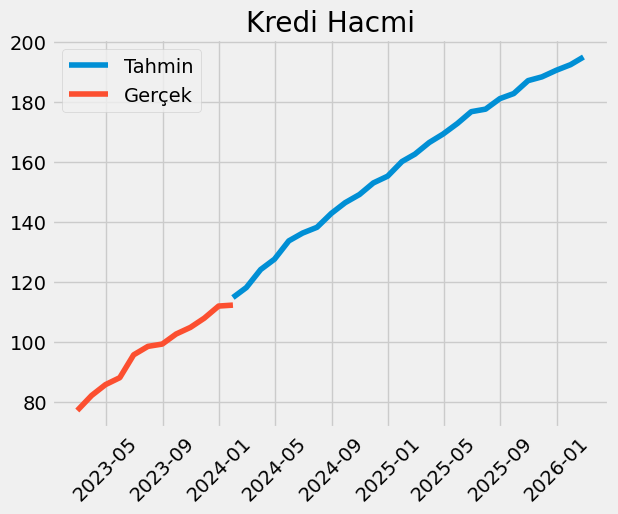

In [249]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"][-26:],label="Tahmin")
plt.plot(df3["Kredi Hacmi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [250]:
kreditahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(25)
kreditahmin

ds
2024-02-29    2.891247
2024-03-31    5.079256
2024-04-30    2.788415
2024-05-31    4.783152
2024-06-30    1.951180
2024-07-31    1.403183
2024-08-31    3.345983
2024-09-30    2.503491
2024-10-31    1.860318
2024-11-30    2.587520
2024-12-31    1.476490
2025-01-31    3.138199
2025-02-28    1.535067
2025-03-31    2.384318
2025-04-30    1.700175
2025-05-31    2.078911
2025-06-30    2.275106
2025-07-31    0.478534
2025-08-31    1.972756
2025-09-30    0.933320
2025-10-31    2.355253
2025-11-30    0.671789
2025-12-31    1.163697
2026-01-31    0.983258
2026-02-28    1.322886
Name: yhat, dtype: float64

In [251]:
kreditahmin1 = []
result = df3.iloc[-1,0]
for i in range(len(kreditahmin)):
    result *= (1 + kreditahmin[i] / 100)
    kreditahmin1.append(result)

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi Hacmi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-01-30", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi Hacmi":df3.iloc[-3:,0]},index=pd.date_range(start="2023-10-30",periods=3,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi Hacmi
2023-10-31,NaN
2023-11-30,107.866144
2023-12-31,111.894756
2024-01-31,115.455286
2024-02-29,121.319555
2024-03-31,124.702448
2024-04-30,130.667155
2024-05-31,133.216707
2024-06-30,135.085981
2024-07-31,139.605935


In [256]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TRY"].rolling(3).mean(),paraarzitahmin1["M3 Para Arzi"].shift(1),kreditahmin1.rolling(2).mean()],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enf_belirsizlik1["Enflasyon Belirsizliği"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["Politika Faizi"]=faiztahmin["Faiz"]




tahmindf["Politika Faizi"]=[42.5,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45]
tahmindf=tahmindf[['USD/TRY', 'Kredi Faizi','Enflasyon Belirsizliği', 'M3 Para Arzi', 'Kredi Hacmi', 'Mevduat Faizi','İşsizlik','Politika Faizi']]

tahmindf.columns=['USD/TRY', 'Kredi Faizi','Enflasyon Belirsizliği', 'M3 Para Arzi', 'Kredi Hacmi', 'Mevduat Faizi','İşsizlik','Politika Faizi']
tahmindf=tahmindf.dropna(axis=0)





#tahmindf.iloc[0,1]=-3.34
#tahmindf.iloc[1,1]=5.76
#tahmindf.iloc[0,9]=2.675
#tahmindf.iloc[-1,4]=25
tahmindf

,USD/TRY,Kredi Faizi,Enflasyon Belirsizliği,M3 Para Arzi,Kredi Hacmi,Mevduat Faizi,İşsizlik,Politika Faizi
2024-01-31,2.412210,62.080000,2.338209,4.488851,3.453363,51.290000,8.756800,45.0
2024-02-29,2.539954,62.487036,2.639825,1.847685,4.145502,50.758418,8.901400,45.0
2024-03-31,3.295748,63.739910,2.737134,2.182179,3.905466,52.269808,8.952587,45.0
2024-04-30,3.710259,63.140805,2.726393,2.791936,3.799497,52.226070,8.965938,45.0
2024-05-31,4.055914,63.980462,1.914589,2.851835,3.334093,51.606011,9.061040,45.0
2024-06-30,3.594943,63.245752,1.199474,2.509648,1.674534,51.962263,9.105634,45.0
2024-07-31,3.245755,64.009176,1.236244,2.549965,2.381351,52.032439,9.136871,45.0
2024-08-31,2.981656,63.268563,1.889905,2.750009,2.917805,51.842460,9.192203,45.0
2024-09-30,3.302151,64.006409,2.273530,2.529998,2.177929,51.916006,9.230379,45.0
2024-10-31,3.147756,63.278946,1.941599,2.438702,2.227270,51.956895,9.263083,45.0


In [257]:
features=['USD/TRY', 'Kredi Faizi','Enflasyon Belirsizliği', 'M3 Para Arzi',
          'Kredi Hacmi', 'Mevduat Faizi','İşsizlik','Politika Faizi']


In [259]:
import keras
import keras.optimizers
prediction_list=[]
for i in range(10):
   keras.utils.set_random_seed(i)
   X = data.drop(['TÜFE'], axis=1).values
   y = data['TÜFE'].values
   X=data[features].values

   X_scaled = scaler.fit_transform(X)
   y_scaled = scaler.fit_transform(y.reshape(-1, 1))

   model = tf.keras.Sequential()
   model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(8,1)))
   model.add(tf.keras.layers.Dense(64,activation='selu'))
   model.add(tf.keras.layers.Dense(64,activation='elu'))
   model.add(tf.keras.layers.Dense(1))
   rms = keras.optimizers.RMSprop(learning_rate=0.01)
   model.compile(optimizer=rms, loss='mean_squared_error')
   model.fit(X_scaled, y_scaled, epochs=100, batch_size=32)
   tahmin=tahmindf[features].values
   X_scaled = scaler.fit_transform(X)
   tahmin_scaled = scaler.transform(tahmin)
   pred = model.predict(tahmin_scaled)
   y_scaled = scaler.fit_transform(y.reshape(-1, 1))
   pred = scaler.inverse_transform(pred)
   prediction_list.append(pred)
columns = [f'Prediction_{i+1}' for i in range(10)]
predictions_df = pd.DataFrame(np.column_stack(prediction_list), columns=columns)

Epoch 1/100
4/4 [==============================] - 1s 7ms/step - loss: 8.1988
Epoch 2/100
4/4 [==============================] - 0s 6ms/step - loss: 0.2038
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0329
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0295
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0236
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0243
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0239
Epoch 9/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0347
Epoch 10/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0432
Epoch 11/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0220
Epoch 12/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0239
Epoch 13/100
4/4 [==============================] - 0s 8ms/s

4/4 [==============================] - 0s 8ms/step - loss: 0.0246
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0237
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0244
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0254
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0225
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0222
Epoch 10/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 11/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0439
Epoch 12/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 13/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0727
Epoch 14/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0233
Epoch 15/100
4/4 [==============================] - 0s 5ms/step - loss: 0.0223
Epoch 16/100
4/4 [==============================] - 0s 5ms/step - loss

4/4 [==============================] - 0s 6ms/step - loss: 0.0331
Epoch 8/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0252
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0670
Epoch 10/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0317
Epoch 11/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0230
Epoch 12/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0676
Epoch 13/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0206
Epoch 14/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0395
Epoch 15/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0438
Epoch 16/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0205
Epoch 17/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0286
Epoch 18/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0350
Epoch 19/100
4/4 [==============================] - 0s 8ms/step 

4/4 [==============================] - 0s 8ms/step - loss: 0.0220
Epoch 11/100
4/4 [==============================] - 0s 7ms/step - loss: 0.1105
Epoch 12/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0217
Epoch 13/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0292
Epoch 14/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0330
Epoch 15/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0241
Epoch 16/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0357
Epoch 17/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0475
Epoch 18/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0233
Epoch 19/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0271
Epoch 20/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0322
Epoch 21/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0256
Epoch 22/100
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 7ms/step - loss: 0.0208
Epoch 14/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0254
Epoch 15/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0310
Epoch 16/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0277
Epoch 17/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0328
Epoch 18/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0302
Epoch 19/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0234
Epoch 20/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0313
Epoch 21/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0180
Epoch 22/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0388
Epoch 23/100
4/4 [==============================] - 0s 12ms/step - loss: 0.1589
Epoch 24/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0510
Epoch 25/100
4/4 [==============================] - 0s 10ms/st

4/4 [==============================] - 0s 7ms/step - loss: 0.0442
Epoch 17/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0233
Epoch 18/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0232
Epoch 19/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0186
Epoch 20/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0383
Epoch 21/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0312
Epoch 22/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0242
Epoch 23/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0289
Epoch 24/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0182
Epoch 25/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0235
Epoch 26/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0268
Epoch 27/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0253
Epoch 28/100
4/4 [==============================] - 0s 8ms/step

4/4 [==============================] - 0s 9ms/step - loss: 0.0383
Epoch 20/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0208
Epoch 21/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0251
Epoch 22/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0266
Epoch 23/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0414
Epoch 24/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0404
Epoch 25/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0246
Epoch 26/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0261
Epoch 27/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0209
Epoch 28/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0170
Epoch 29/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0251
Epoch 30/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0254
Epoch 31/100
4/4 [==============================] - 0s 7ms/step 

4/4 [==============================] - 0s 8ms/step - loss: 0.0200
Epoch 23/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0265
Epoch 24/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0301
Epoch 25/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0270
Epoch 26/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0227
Epoch 27/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0187
Epoch 28/100
4/4 [==============================] - 0s 7ms/step - loss: 0.1694
Epoch 29/100
4/4 [==============================] - 0s 7ms/step - loss: 0.1010
Epoch 30/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0176
Epoch 31/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 32/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 33/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 34/100
4/4 [==============================] - 0s 7ms/step

4/4 [==============================] - 0s 7ms/step - loss: 0.4382
Epoch 25/100
4/4 [==============================] - 0s 10ms/step - loss: 0.1156
Epoch 26/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0207
Epoch 27/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0164
Epoch 28/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0149
Epoch 29/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0189
Epoch 30/100
4/4 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 31/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0221
Epoch 32/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0133
Epoch 33/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 34/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0430
Epoch 35/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0267
Epoch 36/100
4/4 [==============================] - 0s 10ms/st

Epoch 27/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0363
Epoch 28/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0282
Epoch 29/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0268
Epoch 30/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 31/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0482
Epoch 32/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0278
Epoch 33/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0294
Epoch 34/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0251
Epoch 35/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0207
Epoch 36/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0394
Epoch 37/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0500
Epoch 38/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0259
Epoch 39/100
4/4 [==============================] 

In [260]:
pred=predictions_df.iloc[:,:11].mean(axis=1).values
pred

array([4.1031117, 4.155099 , 4.278362 , 4.280135 , 4.3034945, 4.2621346,
       4.140089 , 4.110034 , 4.454597 , 4.255875 , 4.2684546, 4.1859994,
       4.370589 , 4.429365 , 4.0705147, 3.9032378, 3.865628 , 4.0485525,
       4.217506 , 4.0847354, 4.005289 , 4.0202775, 4.3468714, 4.320344 ,
       4.3490896], dtype=float32)

In [261]:
corr=data.corr()["TÜFE"].sort_values(ascending=False)
np.abs(corr).sort_values(ascending=False)

TÜFE                      1.000000
Motorin                   0.643830
Enflasyon Belirsizliği    0.627335
Kredi Faizi               0.507711
USD/TRY                   0.490943
Mevduat Faizi             0.418636
M3 Para Arzi              0.309880
Kredi Hacmi               0.238513
Politika Faizi            0.230953
İşsizlik                  0.200973
Name: TÜFE, dtype: float64

### TÜFE Tahminlerimizi yapıyoruz.

In [262]:
features=['USD/TRY', 'Kredi Faizi','Enflasyon Belirsizliği', 'M3 Para Arzi',
          'Kredi Hacmi', 'Mevduat Faizi','İşsizlik','Politika Faizi']

X = data[features]
y=data["TÜFE"]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1806.50
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin1

,SGD Regressor
2024-01-31,1840.029285
2024-02-29,1879.185126
2024-03-31,1923.193218
2024-04-30,1969.142181
2024-05-31,2014.110233
2024-06-30,2056.997500
2024-07-31,2096.962353
2024-08-31,2139.537936
2024-09-30,2193.248253
2024-10-31,2242.753893


In [263]:
data.columns

Index(['USD/TRY', 'Motorin', 'Kredi Faizi', 'Enflasyon Belirsizliği',
       'M3 Para Arzi', 'Kredi Hacmi', 'Mevduat Faizi', 'İşsizlik',
       'Politika Faizi', 'TÜFE'],
      dtype='object')

In [264]:
features=['USD/TRY', 'Kredi Faizi','Enflasyon Belirsizliği', 'M3 Para Arzi',
          'Kredi Hacmi', 'Mevduat Faizi','İşsizlik','Politika Faizi']


X= data[features]
y=data[["TÜFE"]]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1806.50
lineartahmin = model.predict(np.array(tahmindf[features]))
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin2


,Linear Regression
2024-01-31,1838.738522
2024-02-29,1876.603643
2024-03-31,1919.049514
2024-04-30,1963.072531
2024-05-31,2007.219904
2024-06-30,2048.607883
2024-07-31,2087.613908
2024-08-31,2128.743694
2024-09-30,2181.180032
2024-10-31,2228.904490


In [265]:
features=['USD/TRY', 'Kredi Faizi','Enflasyon Belirsizliği', 'M3 Para Arzi',
          'Kredi Hacmi', 'Mevduat Faizi','İşsizlik','Politika Faizi']


X = data[features]
reg = linear_model.Lasso(alpha=0.001)
reg.fit(X,y)


tüfetahmin5 = []
result = 1806.50
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin5

,Lasso Regression
2024-01-31,1838.758129
2024-02-29,1876.643918
2024-03-31,1919.117844
2024-04-30,1963.166013
2024-05-31,2007.351156
2024-06-30,2048.773198
2024-07-31,2087.826752
2024-08-31,2128.998444
2024-09-30,2181.470509
2024-10-31,2229.234153


In [266]:
features=['USD/TRY', 'Kredi Faizi','Enflasyon Belirsizliği', 'M3 Para Arzi',
          'Kredi Hacmi', 'Mevduat Faizi','İşsizlik','Politika Faizi']




X = data[features]
y=data["TÜFE"]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)



tüfetahmin6 = []
result = 1806.50
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin6


,Lars Regression
2024-01-31,1838.738522
2024-02-29,1876.603643
2024-03-31,1919.049514
2024-04-30,1963.072531
2024-05-31,2007.219904
2024-06-30,2048.607883
2024-07-31,2087.613908
2024-08-31,2128.743694
2024-09-30,2181.180032
2024-10-31,2228.904490


In [267]:
features=['USD/TRY', 'Kredi Faizi','Enflasyon Belirsizliği', 'M3 Para Arzi',
          'Kredi Hacmi', 'Mevduat Faizi','İşsizlik','Politika Faizi']




X = data[features]
y=data["TÜFE"]
krr = KernelRidge()
krr.fit(X, y)

tüfetahmin7 = []
result = 1806.50
krrtahmin=krr.predict(tahmindf[features])
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin7

,Kernel Regression
2024-01-31,1838.567240
2024-02-29,1876.594950
2024-03-31,1919.280482
2024-04-30,1963.420509
2024-05-31,2007.923393
2024-06-30,2049.489371
2024-07-31,2088.901910
2024-08-31,2130.339380
2024-09-30,2183.076085
2024-10-31,2231.078768


In [268]:
features=['USD/TRY', 'Kredi Faizi','Enflasyon Belirsizliği', 'M3 Para Arzi',
          'Kredi Hacmi', 'Mevduat Faizi','İşsizlik','Politika Faizi']





X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
y=data["TÜFE"]
gpr.fit(X, y) 


tüfe = 1806.50  
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2024-01-31",periods=len(tüfetahmin1),freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2024-01-31,1838.803079
2024-02-29,1877.101933
2024-03-31,1920.066466
2024-04-30,1964.484166
2024-05-31,2009.290604
2024-06-30,2051.144097
2024-07-31,2090.882913
2024-08-31,2132.647552
2024-09-30,2185.699865
2024-10-31,2234.035976


In [269]:
features=['USD/TRY', 'Kredi Faizi','Enflasyon Belirsizliği', 'M3 Para Arzi',
          'Kredi Hacmi', 'Mevduat Faizi','İşsizlik','Politika Faizi']

X = data[features]
y=data["TÜFE"]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1806.50 
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2024-01-31",periods=len(tüfetahmin1),freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2024-01-31,1847.908723
2024-02-29,1896.224577
2024-03-31,1949.673999
2024-04-30,2004.660188
2024-05-31,2061.194403
2024-06-30,2114.459395
2024-07-31,2167.122813
2024-08-31,2221.825200
2024-09-30,2287.444789
2024-10-31,2349.130762


In [270]:
pred1=pd.DataFrame(pred,index=pd.date_range(start="2023-12-30",periods=25,freq="1M"))
pred1=pred1[0]

In [271]:
tüfetahmin19 = []
result = 1806.50
lstmtahmin=pred1
for i in range(len(lstmtahmin)):
    result *= (1 + lstmtahmin[i] / 100)
    tüfetahmin19.append(result)

tüfetahmin19 = np.array(tüfetahmin19).reshape(-1, 1)
tüfetahmin19 = pd.DataFrame(tüfetahmin19)
tüfetahmin19.columns = ["LSTM"]
tüfetahmin19 = tüfetahmin19.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin19), freq="1M"))
tüfetahmin19

,LSTM
2024-01-31,1880.622714
2024-02-29,1958.764448
2024-03-31,2042.567477
2024-04-30,2129.992126
2024-05-31,2221.656219
2024-06-30,2316.346196
2024-07-31,2412.244991
2024-08-31,2511.389080
2024-09-30,2623.261343
2024-10-31,2734.904070


In [272]:
features=['USD/TRY', 'Kredi Faizi','Enflasyon Belirsizliği', 'M3 Para Arzi',
          'Kredi Hacmi', 'Mevduat Faizi','İşsizlik','Politika Faizi']

X = data[features]
y=data[["TÜFE"]]
model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
# Modeli uydurun
results = model.fit()

robusttahmin=results.predict(tahmindf[features])

tüfetahmin21 = []
result = 1806.50
for i in range(len(robusttahmin)):
    result *= (1 + robusttahmin[i] / 100)
    tüfetahmin21.append(result)

tüfetahmin21 = np.array(tüfetahmin21).reshape(-1, 1)
tüfetahmin21 = pd.DataFrame(tüfetahmin21)
tüfetahmin21.columns = ["Robust Regression"]
tüfetahmin21 = tüfetahmin21.set_index(pd.date_range(start="2024-01-31", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin21

,Robust Regression
2024-01-31,1844.595951
2024-02-29,1890.802085
2024-03-31,1941.122434
2024-04-30,1992.500461
2024-05-31,2043.225312
2024-06-30,2090.326908
2024-07-31,2136.766638
2024-08-31,2186.232699
2024-09-30,2245.107353
2024-10-31,2300.571685


In [273]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["LSTM"]=tüfetahmin19["LSTM"]
tüfetahmin["Robust Regression"]=tüfetahmin21["Robust Regression"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2024-01-31,1840.029285,1838.738522,1838.758129,1838.738522,1838.567240,1838.803079,1847.908723,1880.622714,1844.595951,1845.195796
2024-02-29,1879.185126,1876.603643,1876.643918,1876.603643,1876.594950,1877.101933,1896.224577,1958.764448,1890.802085,1889.836036
2024-03-31,1923.193218,1919.049514,1919.117844,1919.049514,1919.280482,1920.066466,1949.673999,2042.567477,1941.122434,1939.235661
2024-04-30,1969.142181,1963.072531,1963.166013,1963.072531,1963.420509,1964.484166,2004.660188,2129.992126,1992.500461,1990.390078
2024-05-31,2014.110233,2007.219904,2007.351156,2007.219904,2007.923393,2009.290604,2061.194403,2221.656219,2043.225312,2042.132348
2024-06-30,2056.997500,2048.607883,2048.773198,2048.607883,2049.489371,2051.144097,2114.459395,2316.346196,2090.326908,2091.639159
2024-07-31,2096.962353,2087.613908,2087.826752,2087.613908,2088.901910,2090.882913,2167.122813,2412.244991,2136.766638,2139.548465
2024-08-31,2139.537936,2128.743694,2128.998444,2128.743694,2130.339380,2132.647552,2221.825200,2511.389080,2186.232699,2189.828631
2024-09-30,2193.248253,2181.180032,2181.470509,2181.180032,2183.076085,2185.699865,2287.444789,2623.261343,2245.107353,2251.296473
2024-10-31,2242.753893,2228.904490,2229.234153,2228.904490,2231.078768,2234.035976,2349.130762,2734.904070,2300.571685,2308.835365


In [274]:
dates=pd.date_range('2006-02-01','2024-01-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas9,dfas10],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [275]:

tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2024-01-31,1840.029285,1838.738522,1838.758129,1838.738522,1838.567240,1838.803079,1847.908723,1880.622714,1844.595951,1845.195796
2024-02-29,1879.185126,1876.603643,1876.643918,1876.603643,1876.594950,1877.101933,1896.224577,1958.764448,1890.802085,1889.836036
2024-03-31,1923.193218,1919.049514,1919.117844,1919.049514,1919.280482,1920.066466,1949.673999,2042.567477,1941.122434,1939.235661
2024-04-30,1969.142181,1963.072531,1963.166013,1963.072531,1963.420509,1964.484166,2004.660188,2129.992126,1992.500461,1990.390078
2024-05-31,2014.110233,2007.219904,2007.351156,2007.219904,2007.923393,2009.290604,2061.194403,2221.656219,2043.225312,2042.132348
2024-06-30,2056.997500,2048.607883,2048.773198,2048.607883,2049.489371,2051.144097,2114.459395,2316.346196,2090.326908,2091.639159
2024-07-31,2096.962353,2087.613908,2087.826752,2087.613908,2088.901910,2090.882913,2167.122813,2412.244991,2136.766638,2139.548465
2024-08-31,2139.537936,2128.743694,2128.998444,2128.743694,2130.339380,2132.647552,2221.825200,2511.389080,2186.232699,2189.828631
2024-09-30,2193.248253,2181.180032,2181.470509,2181.180032,2183.076085,2185.699865,2287.444789,2623.261343,2245.107353,2251.296473
2024-10-31,2242.753893,2228.904490,2229.234153,2228.904490,2231.078768,2234.035976,2349.130762,2734.904070,2300.571685,2308.835365


In [276]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin.iloc[4,:]=aylıktahmin.iloc[4,:]+0.50
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2024-02-29,2.128001,2.059299,2.060401,2.059299,2.068334,2.082814,2.614623,4.155099,2.504946,2.419268
2024-03-31,2.341871,2.261845,2.263292,2.261845,2.274627,2.288876,2.818728,4.278362,2.661323,2.613964
2024-04-30,2.389202,2.294001,2.295230,2.294001,2.299822,2.313342,2.820276,4.280135,2.646821,2.637865
2024-05-31,2.283637,2.248892,2.250708,2.248892,2.266600,2.280825,2.820140,4.303494,2.545789,2.599604
2024-06-30,2.629341,2.561955,2.563517,2.561955,2.570098,2.582998,3.084181,4.762135,2.805257,2.924270
2024-07-31,1.942873,1.904026,1.906192,1.904026,1.923042,1.937398,2.490633,4.140089,2.221649,2.290515
2024-08-31,2.030346,1.970182,1.971988,1.970182,1.983696,1.997464,2.524194,4.110034,2.314996,2.350036
2024-09-30,2.510370,2.463253,2.464636,2.463253,2.475507,2.487627,2.953409,4.454597,2.692973,2.806970
2024-10-31,2.257184,2.188011,2.189516,2.188011,2.198855,2.211471,2.696720,4.255875,2.470453,2.555811
2024-11-30,2.174685,2.182292,2.184222,2.182292,2.207646,2.221125,2.736902,4.268455,2.444061,2.554826


In [277]:
aylıktahmin.to_csv('modelaylık.csv')

In [278]:
std=aylıktahmin.std(axis=1)
std

2024-02-29    0.647009
2024-03-31    0.621793
2024-04-30    0.611423
2024-05-31    0.635319
2024-06-30    0.677838
2024-07-31    0.690150
2024-08-31    0.659434
2024-09-30    0.614056
2024-10-31    0.636419
2024-11-30    0.646177
2024-12-31    0.630310
2025-01-31    0.606929
2025-02-28    0.589738
2025-03-31    0.693775
2025-04-30    0.698194
2025-05-31    0.715187
2025-06-30    0.688564
2025-07-31    0.672676
2025-08-31    0.665376
2025-09-30    0.685076
2025-10-31    0.668297
2025-11-30    0.641420
2025-12-31    0.623844
2026-01-31    0.628810
Freq: M, dtype: float64

In [279]:
aylıktahmin["Maksimum"]=aylıktahmin["Bayessian Regression"]+std
aylıktahmin["Minimum"]=aylıktahmin["LSTM"]-std
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama,Maksimum,Minimum
2024-02-29,2.128001,2.059299,2.060401,2.059299,2.068334,2.082814,2.614623,4.155099,2.504946,2.419268,3.261632,3.508090
2024-03-31,2.341871,2.261845,2.263292,2.261845,2.274627,2.288876,2.818728,4.278362,2.661323,2.613964,3.440522,3.656568
2024-04-30,2.389202,2.294001,2.295230,2.294001,2.299822,2.313342,2.820276,4.280135,2.646821,2.637865,3.431699,3.668712
2024-05-31,2.283637,2.248892,2.250708,2.248892,2.266600,2.280825,2.820140,4.303494,2.545789,2.599604,3.455459,3.668175
2024-06-30,2.629341,2.561955,2.563517,2.561955,2.570098,2.582998,3.084181,4.762135,2.805257,2.924270,3.762019,4.084297
2024-07-31,1.942873,1.904026,1.906192,1.904026,1.923042,1.937398,2.490633,4.140089,2.221649,2.290515,3.180783,3.449939
2024-08-31,2.030346,1.970182,1.971988,1.970182,1.983696,1.997464,2.524194,4.110034,2.314996,2.350036,3.183628,3.450600
2024-09-30,2.510370,2.463253,2.464636,2.463253,2.475507,2.487627,2.953409,4.454597,2.692973,2.806970,3.567465,3.840541
2024-10-31,2.257184,2.188011,2.189516,2.188011,2.198855,2.211471,2.696720,4.255875,2.470453,2.555811,3.333139,3.619456
2024-11-30,2.174685,2.182292,2.184222,2.182292,2.207646,2.221125,2.736902,4.268455,2.444061,2.554826,3.383080,3.622277


In [280]:
tüfe = 1859.38# İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin10),freq="1M"))
tüfetahmin10.columns=["CPI"]

tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [281]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin12),freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(38))


In [282]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin13),freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(38))


In [283]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin14),freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [284]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin15),freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [285]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin16 = []
kerneltahmin=aylıktahmin["Kernel Regression"]
kerneltahmin=1+(kerneltahmin/100)
for elem in kerneltahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin16),freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))

In [286]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin17),freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [287]:
tüfe = 1859.38# İlk değeri 1691 ile başlatıyoruz
tüfetahmin18 = []
lineartahmin=aylıktahmin["Linear Regression"]
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin18),freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))


In [288]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin20 = []
lstmtahmin=aylıktahmin["LSTM"]
lstmtahmin=1+(lstmtahmin/100)
for elem in lstmtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin20.append(tüfe)
tüfetahmin20=pd.DataFrame(tüfetahmin20)
tüfetahmin20=tüfetahmin20.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin20),freq="1M"))
tüfetahmin20.columns=["CPI"]
tüfetahmin20=pd.concat([df["CPI"],tüfetahmin20["CPI"]],axis=0)
tüfetahmin20=pd.DataFrame((tüfetahmin20.pct_change(periods=12)*100).tail(38))

In [289]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin22 = []
robusttahmin=aylıktahmin["Robust Regression"]
robusttahmin=1+(robusttahmin/100)
for elem in robusttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin22.append(tüfe)
tüfetahmin22=pd.DataFrame(tüfetahmin22)
tüfetahmin22=tüfetahmin22.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin22),freq="1M"))
tüfetahmin22.columns=["CPI"]
tüfetahmin22=pd.concat([df["CPI"],tüfetahmin22["CPI"]],axis=0)
tüfetahmin22=pd.DataFrame((tüfetahmin22.pct_change(periods=12)*100).tail(38))


In [290]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin23 = []
maxtahmin=aylıktahmin["Maksimum"]
maxtahmin=1+(maxtahmin/100)
for elem in maxtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin23.append(tüfe)
tüfetahmin23=pd.DataFrame(tüfetahmin23)
tüfetahmin23=tüfetahmin23.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin23),freq="1M"))
tüfetahmin23.columns=["CPI"]
tüfetahmin23=pd.concat([df["CPI"],tüfetahmin23["CPI"]],axis=0)
tüfetahmin23=pd.DataFrame((tüfetahmin23.pct_change(periods=12)*100).tail(38))


In [291]:
tüfe = 1859.38 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin24 = []
mintahmin=aylıktahmin["Minimum"]
mintahmin=1+(mintahmin/100)
for elem in mintahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin24.append(tüfe)
tüfetahmin24=pd.DataFrame(tüfetahmin24)
tüfetahmin24=tüfetahmin24.set_index(pd.date_range(start="2024-01-30",periods=len(tüfetahmin24),freq="1M"))
tüfetahmin24.columns=["CPI"]
tüfetahmin24=pd.concat([df["CPI"],tüfetahmin24["CPI"]],axis=0)
tüfetahmin24=pd.DataFrame((tüfetahmin24.pct_change(periods=12)*100).tail(38))
tüfetahmin24

,CPI
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511
2023-04-30,43.684170
2023-05-31,39.585301
2023-06-30,38.213519
2023-07-31,47.831733
2023-08-31,58.943534


In [292]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)
ekim=pd.DataFrame({"TÜFE":[3.28,2.93]},index=pd.date_range(start="2023-11-30",periods=2,freq="1M"))
aylık=pd.concat([aylık,ekim],axis=0)

In [293]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]])
aylık1=pd.DataFrame(aylık1)
#aylık1=aylık1.set_index(pd.date_range(start="2014-01-30",end="2025-02-27",freq="1M"))
aylık1.head(132).to_csv('aylik.csv')

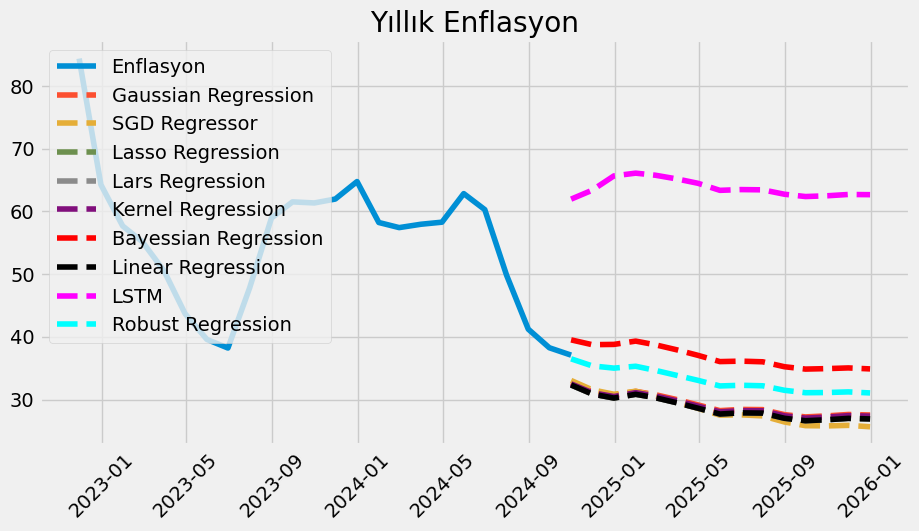

In [303]:
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Gaussian Regression"]=tüfetahmin12["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Kernel Regression"]=tüfetahmin16["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["LSTM"]=tüfetahmin20["CPI"]
yıllıktahmin["Robust Regression"]=tüfetahmin22["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[0:24],label="Enflasyon")
plt.plot(yıllıktahmin["Gaussian Regression"].iloc[23:],'--',label="Gaussian Regression")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[23:],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[23:],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[23:],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Kernel Regression"].iloc[23:],'--',label="Kernel Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[23:],'--',label="Bayessian Regression",color="red")
plt.plot(yıllıktahmin["Linear Regression"].iloc[23:],'--',label="Linear Regression",color="black")
plt.plot(yıllıktahmin["LSTM"].iloc[23:],'--',label="LSTM",color="magenta")
plt.plot(yıllıktahmin["Robust Regression"].iloc[23:],'--',label="Robust Regression",color="cyan")
plt.legend(loc=0)
plt.xticks(rotation=45)
#plt.xticks(pd.date_range(start="2022-12-30",end="2025-01-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [304]:
yıllıktahmin["Maksimum"]=tüfetahmin23["CPI"]
yıllıktahmin["Minimum"]=tüfetahmin24["CPI"]
yıllıktahmin

,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Maksimum,Minimum
2022-11-30,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260
2022-12-31,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597
2023-01-31,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481
2023-02-28,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828
2023-03-31,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511
2023-04-30,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170
2023-05-31,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301
2023-06-30,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519
2023-07-31,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733
2023-08-31,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534


In [305]:
yıllıktahmin["Ortalama"]=yıllıktahmin.iloc[:,1:10].mean(axis=1)
yıllıktahmin.to_csv('modelyilliktahmin.csv')
yıllıktahmin


,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Maksimum,Minimum
2022-11-30,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260
2022-12-31,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597
2023-01-31,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481
2023-02-28,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828
2023-03-31,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511
2023-04-30,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170
2023-05-31,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301
2023-06-30,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519
2023-07-31,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733
2023-08-31,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534
